##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

# 3D 畳み込みニューラルネットワークによる動画分類

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

- 入力パイプラインを構築する
- Keras Functional API を使って残差接続を伴う 3D 畳み込みニューラルネットワークモデルを構築する
- モデルをトレーニングする
- モデルを評価してテストする

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## セットアップ

まず、ZIP ファイルの内容を検査するための [remotezip](https://github.com/gtsystem/python-remotezip)、進捗バーを使用するための [tqdm](https://github.com/tqdm/tqdm)、動画ファイルを処理するための [OpenCV](https://opencv.org/)、より複雑なテンソル演算を実行するための [einops](https://github.com/arogozhnikov/einops/tree/master/docs)、Jupyter ノートブックにデータを埋め込むための [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) を含む、必要なライブラリのインストールとインポートを行います。

**注意**: このチュートリアルは、TensorFlow 2.10 を使って実行します。TensorFlow 2.10 より後のバージョンでは、正しく実行しない可能性があります。

In [2]:
!pip install remotezip tqdm opencv-python einops

  Using cached remotezip-0.12.2-py3-none-any.whl


  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)


  Using cached einops-0.7.0-py3-none-any.whl.metadata (13 kB)


  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (62.2 MB)


Using cached einops-0.7.0-py3-none-any.whl (44 kB)


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


2024-01-11 19:24:24.449591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:24:24.449639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:24:24.451390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 動画データを読み込んで前処理する

以下の非表示セルは、UCF-101 データセットからデータスライスをダウンロードして `tf.data.Dataset` に読み込むヘルパー関数を定義します。具体的な前処理手順については、[動画データの読み込みチュートリアル](../load_data/video.ipynb)をご覧ください。このコードを手順を追ってより詳しく説明しています。

ここでは、非表示ブロックの最後にある `FrameGenerator` クラスが最も重要なユーティリティです。TensorFlow データパイプラインにデータをフィードでキルイテレート可能なオブジェクトを作成します。特に、このクラスには、エンコードされたラベルとともに動画フレームを読み込む Python ジェネレータが含まれます。このジェネレータ（`__call__`）関数は、`frames_from_video_file` とフレームセットに関連するラベルのワンホットエンコードのベクトルを生成します。

In [4]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<00:36,  8.28it/s]

  1%|          | 3/300 [00:00<00:33,  8.80it/s]

  2%|▏         | 5/300 [00:00<00:25, 11.75it/s]

  2%|▏         | 7/300 [00:00<00:23, 12.68it/s]

  3%|▎         | 9/300 [00:00<00:20, 13.93it/s]

  4%|▎         | 11/300 [00:00<00:19, 14.56it/s]

  4%|▍         | 13/300 [00:00<00:19, 15.04it/s]

  5%|▌         | 15/300 [00:01<00:19, 14.89it/s]

  6%|▌         | 17/300 [00:01<00:18, 15.47it/s]

  6%|▋         | 19/300 [00:01<00:17, 16.23it/s]

  7%|▋         | 21/300 [00:01<00:16, 16.61it/s]

  8%|▊         | 23/300 [00:01<00:16, 16.43it/s]

  8%|▊         | 25/300 [00:01<00:16, 16.69it/s]

  9%|▉         | 27/300 [00:01<00:16, 16.83it/s]

 10%|▉         | 29/300 [00:01<00:15, 17.20it/s]

 10%|█         | 31/300 [00:02<00:18, 14.34it/s]

 11%|█         | 33/300 [00:02<00:22, 12.02it/s]

 12%|█▏        | 35/300 [00:02<00:21, 12.21it/s]

 12%|█▏        | 37/300 [00:02<00:20, 13.03it/s]

 13%|█▎        | 39/300 [00:02<00:18, 13.86it/s]

 14%|█▎        | 41/300 [00:02<00:17, 14.84it/s]

 14%|█▍        | 43/300 [00:02<00:17, 14.85it/s]

 15%|█▌        | 45/300 [00:03<00:16, 15.59it/s]

 16%|█▌        | 47/300 [00:03<00:16, 15.37it/s]

 16%|█▋        | 49/300 [00:03<00:15, 15.92it/s]

 17%|█▋        | 51/300 [00:03<00:15, 15.79it/s]

 18%|█▊        | 53/300 [00:03<00:14, 16.51it/s]

 18%|█▊        | 55/300 [00:03<00:14, 16.56it/s]

 19%|█▉        | 57/300 [00:03<00:14, 16.86it/s]

 20%|█▉        | 59/300 [00:03<00:14, 16.78it/s]

 20%|██        | 61/300 [00:04<00:14, 16.06it/s]

 21%|██        | 63/300 [00:04<00:18, 12.75it/s]

 22%|██▏       | 65/300 [00:04<00:22, 10.50it/s]

 22%|██▏       | 67/300 [00:04<00:19, 11.90it/s]

 23%|██▎       | 69/300 [00:04<00:17, 12.99it/s]

 24%|██▎       | 71/300 [00:05<00:19, 11.86it/s]

 24%|██▍       | 73/300 [00:05<00:22, 10.31it/s]

 25%|██▌       | 75/300 [00:05<00:19, 11.55it/s]

 26%|██▌       | 77/300 [00:05<00:18, 12.11it/s]

 26%|██▋       | 79/300 [00:05<00:17, 12.99it/s]

 27%|██▋       | 81/300 [00:05<00:16, 13.64it/s]

 28%|██▊       | 83/300 [00:05<00:14, 14.49it/s]

 28%|██▊       | 85/300 [00:06<00:14, 15.15it/s]

 29%|██▉       | 87/300 [00:06<00:14, 15.11it/s]

 30%|██▉       | 89/300 [00:06<00:13, 16.13it/s]

 30%|███       | 91/300 [00:06<00:13, 15.10it/s]

 31%|███       | 93/300 [00:06<00:14, 14.34it/s]

 32%|███▏      | 95/300 [00:06<00:14, 14.41it/s]

 32%|███▏      | 97/300 [00:06<00:14, 14.08it/s]

 33%|███▎      | 99/300 [00:06<00:13, 14.76it/s]

 34%|███▎      | 101/300 [00:07<00:12, 15.41it/s]

 34%|███▍      | 103/300 [00:07<00:12, 15.77it/s]

 35%|███▌      | 105/300 [00:07<00:12, 15.57it/s]

 36%|███▌      | 107/300 [00:07<00:12, 15.09it/s]

 36%|███▋      | 109/300 [00:07<00:12, 15.43it/s]

 37%|███▋      | 111/300 [00:07<00:12, 15.29it/s]

 38%|███▊      | 113/300 [00:07<00:11, 15.74it/s]

 38%|███▊      | 115/300 [00:08<00:11, 15.68it/s]

 39%|███▉      | 117/300 [00:08<00:11, 16.29it/s]

 40%|███▉      | 119/300 [00:08<00:11, 15.84it/s]

 40%|████      | 121/300 [00:08<00:11, 15.85it/s]

 41%|████      | 123/300 [00:08<00:12, 14.55it/s]

 42%|████▏     | 125/300 [00:08<00:13, 12.98it/s]

 42%|████▏     | 127/300 [00:08<00:12, 13.82it/s]

 43%|████▎     | 129/300 [00:08<00:11, 14.50it/s]

 44%|████▎     | 131/300 [00:09<00:11, 15.25it/s]

 44%|████▍     | 133/300 [00:09<00:10, 15.71it/s]

 45%|████▌     | 135/300 [00:09<00:10, 16.40it/s]

 46%|████▌     | 137/300 [00:09<00:09, 16.62it/s]

 46%|████▋     | 139/300 [00:09<00:09, 16.31it/s]

 47%|████▋     | 141/300 [00:09<00:11, 14.20it/s]

 48%|████▊     | 143/300 [00:09<00:10, 14.59it/s]

 48%|████▊     | 145/300 [00:10<00:10, 15.04it/s]

 49%|████▉     | 147/300 [00:10<00:09, 16.23it/s]

 50%|████▉     | 149/300 [00:10<00:09, 16.42it/s]

 50%|█████     | 151/300 [00:10<00:11, 13.03it/s]

 51%|█████     | 153/300 [00:10<00:14, 10.26it/s]

 52%|█████▏    | 155/300 [00:10<00:13, 10.61it/s]

 52%|█████▏    | 157/300 [00:11<00:14,  9.72it/s]

 53%|█████▎    | 159/300 [00:11<00:13, 10.53it/s]

 54%|█████▎    | 161/300 [00:11<00:13, 10.65it/s]

 54%|█████▍    | 163/300 [00:11<00:11, 11.88it/s]

 55%|█████▌    | 165/300 [00:11<00:13,  9.68it/s]

 56%|█████▌    | 167/300 [00:12<00:12, 10.91it/s]

 56%|█████▋    | 169/300 [00:12<00:10, 12.02it/s]

 57%|█████▋    | 171/300 [00:12<00:10, 12.24it/s]

 58%|█████▊    | 173/300 [00:12<00:09, 13.04it/s]

 58%|█████▊    | 175/300 [00:12<00:09, 13.38it/s]

 59%|█████▉    | 177/300 [00:12<00:08, 14.07it/s]

 60%|█████▉    | 179/300 [00:12<00:08, 13.86it/s]

 60%|██████    | 181/300 [00:13<00:10, 11.39it/s]

 61%|██████    | 183/300 [00:13<00:10, 11.13it/s]

 62%|██████▏   | 185/300 [00:13<00:10, 11.30it/s]

 62%|██████▏   | 187/300 [00:13<00:09, 12.16it/s]

 63%|██████▎   | 189/300 [00:13<00:08, 12.67it/s]

 64%|██████▎   | 191/300 [00:13<00:08, 13.18it/s]

 64%|██████▍   | 193/300 [00:14<00:07, 13.96it/s]

 65%|██████▌   | 195/300 [00:14<00:07, 14.82it/s]

 66%|██████▌   | 197/300 [00:14<00:06, 15.69it/s]

 66%|██████▋   | 199/300 [00:14<00:06, 15.95it/s]

 67%|██████▋   | 201/300 [00:14<00:05, 16.50it/s]

 68%|██████▊   | 203/300 [00:14<00:05, 16.51it/s]

 68%|██████▊   | 205/300 [00:14<00:05, 16.37it/s]

 69%|██████▉   | 207/300 [00:14<00:05, 16.24it/s]

 70%|██████▉   | 209/300 [00:14<00:05, 16.13it/s]

 70%|███████   | 211/300 [00:15<00:05, 15.62it/s]

 71%|███████   | 213/300 [00:15<00:08,  9.75it/s]

 72%|███████▏  | 215/300 [00:15<00:09,  8.63it/s]

 72%|███████▏  | 217/300 [00:15<00:08, 10.25it/s]

 73%|███████▎  | 219/300 [00:16<00:06, 11.59it/s]

 74%|███████▎  | 221/300 [00:16<00:06, 12.67it/s]

 74%|███████▍  | 223/300 [00:16<00:06, 11.92it/s]

 75%|███████▌  | 225/300 [00:16<00:05, 13.03it/s]

 76%|███████▌  | 227/300 [00:16<00:05, 13.76it/s]

 76%|███████▋  | 229/300 [00:16<00:04, 14.76it/s]

 77%|███████▋  | 231/300 [00:16<00:05, 13.64it/s]

 78%|███████▊  | 233/300 [00:16<00:04, 14.40it/s]

 78%|███████▊  | 235/300 [00:17<00:04, 14.81it/s]

 79%|███████▉  | 237/300 [00:17<00:04, 15.68it/s]

 80%|███████▉  | 239/300 [00:17<00:03, 16.17it/s]

 80%|████████  | 241/300 [00:17<00:04, 12.27it/s]

 81%|████████  | 243/300 [00:17<00:06,  9.48it/s]

 82%|████████▏ | 245/300 [00:18<00:06,  9.11it/s]

 82%|████████▏ | 247/300 [00:18<00:04, 10.82it/s]

 83%|████████▎ | 249/300 [00:18<00:04, 11.69it/s]

 84%|████████▎ | 251/300 [00:18<00:03, 12.77it/s]

 84%|████████▍ | 253/300 [00:18<00:03, 13.74it/s]

 85%|████████▌ | 255/300 [00:18<00:03, 14.20it/s]

 86%|████████▌ | 257/300 [00:18<00:02, 14.46it/s]

 86%|████████▋ | 259/300 [00:19<00:02, 15.38it/s]

 87%|████████▋ | 261/300 [00:19<00:02, 15.84it/s]

 88%|████████▊ | 263/300 [00:19<00:02, 16.07it/s]

 88%|████████▊ | 265/300 [00:19<00:02, 16.58it/s]

 89%|████████▉ | 267/300 [00:19<00:01, 16.69it/s]

 90%|████████▉ | 269/300 [00:19<00:01, 17.11it/s]

 90%|█████████ | 271/300 [00:19<00:02, 12.48it/s]

 91%|█████████ | 273/300 [00:20<00:02, 12.70it/s]

 92%|█████████▏| 275/300 [00:20<00:01, 13.21it/s]

 92%|█████████▏| 277/300 [00:20<00:01, 12.34it/s]

 93%|█████████▎| 279/300 [00:20<00:01, 11.40it/s]

 94%|█████████▎| 281/300 [00:20<00:01, 12.59it/s]

 94%|█████████▍| 283/300 [00:20<00:01, 13.52it/s]

 95%|█████████▌| 285/300 [00:20<00:01, 12.90it/s]

 96%|█████████▌| 287/300 [00:21<00:00, 13.87it/s]

 96%|█████████▋| 289/300 [00:21<00:00, 14.78it/s]

 97%|█████████▋| 291/300 [00:21<00:00, 14.95it/s]

 98%|█████████▊| 293/300 [00:21<00:00, 15.43it/s]

 98%|█████████▊| 295/300 [00:21<00:00, 15.43it/s]

 99%|█████████▉| 297/300 [00:21<00:00, 15.08it/s]

100%|█████████▉| 299/300 [00:21<00:00, 15.04it/s]

100%|██████████| 300/300 [00:21<00:00, 13.70it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:10,  9.23it/s]

  4%|▍         | 4/100 [00:00<00:07, 13.01it/s]

  6%|▌         | 6/100 [00:00<00:07, 12.22it/s]

  8%|▊         | 8/100 [00:00<00:06, 13.84it/s]

 10%|█         | 10/100 [00:00<00:05, 15.27it/s]

 12%|█▏        | 12/100 [00:00<00:06, 13.98it/s]

 14%|█▍        | 14/100 [00:01<00:06, 13.71it/s]

 16%|█▌        | 16/100 [00:01<00:06, 12.61it/s]

 18%|█▊        | 18/100 [00:01<00:06, 13.47it/s]

 20%|██        | 20/100 [00:01<00:05, 14.44it/s]

 22%|██▏       | 22/100 [00:01<00:07, 10.95it/s]

 24%|██▍       | 24/100 [00:01<00:06, 11.31it/s]

 26%|██▌       | 26/100 [00:02<00:06, 11.39it/s]

 28%|██▊       | 28/100 [00:02<00:05, 12.61it/s]

 30%|███       | 30/100 [00:02<00:05, 12.11it/s]

 32%|███▏      | 32/100 [00:02<00:06, 11.05it/s]

 34%|███▍      | 34/100 [00:02<00:05, 11.51it/s]

 36%|███▌      | 36/100 [00:02<00:04, 12.82it/s]

 38%|███▊      | 38/100 [00:02<00:04, 13.81it/s]

 40%|████      | 40/100 [00:03<00:05, 11.74it/s]

 42%|████▏     | 42/100 [00:03<00:05, 11.46it/s]

 44%|████▍     | 44/100 [00:03<00:05, 10.99it/s]

 46%|████▌     | 46/100 [00:03<00:04, 11.52it/s]

 48%|████▊     | 48/100 [00:03<00:04, 12.70it/s]

 50%|█████     | 50/100 [00:03<00:03, 13.84it/s]

 52%|█████▏    | 52/100 [00:04<00:04, 10.82it/s]

 54%|█████▍    | 54/100 [00:04<00:03, 11.80it/s]

 56%|█████▌    | 56/100 [00:04<00:03, 12.74it/s]

 58%|█████▊    | 58/100 [00:04<00:03, 12.15it/s]

 60%|██████    | 60/100 [00:04<00:03, 12.72it/s]

 62%|██████▏   | 62/100 [00:04<00:02, 13.56it/s]

 64%|██████▍   | 64/100 [00:05<00:02, 14.23it/s]

 66%|██████▌   | 66/100 [00:05<00:02, 14.72it/s]

 68%|██████▊   | 68/100 [00:05<00:02, 15.61it/s]

 70%|███████   | 70/100 [00:05<00:01, 15.68it/s]

 72%|███████▏  | 72/100 [00:05<00:01, 16.58it/s]

 74%|███████▍  | 74/100 [00:05<00:01, 17.37it/s]

 76%|███████▌  | 76/100 [00:05<00:01, 17.22it/s]

 78%|███████▊  | 78/100 [00:05<00:01, 17.68it/s]

 80%|████████  | 80/100 [00:06<00:01, 17.47it/s]

 82%|████████▏ | 82/100 [00:06<00:01, 17.45it/s]

 84%|████████▍ | 84/100 [00:06<00:00, 17.28it/s]

 86%|████████▌ | 86/100 [00:06<00:00, 17.29it/s]

 88%|████████▊ | 88/100 [00:06<00:00, 17.01it/s]

 90%|█████████ | 90/100 [00:06<00:00, 16.93it/s]

 92%|█████████▏| 92/100 [00:06<00:00, 16.81it/s]

 94%|█████████▍| 94/100 [00:06<00:00, 16.74it/s]

 96%|█████████▌| 96/100 [00:06<00:00, 16.84it/s]

 98%|█████████▊| 98/100 [00:07<00:00, 16.20it/s]

100%|██████████| 100/100 [00:07<00:00, 16.26it/s]

100%|██████████| 100/100 [00:07<00:00, 13.84it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:06, 16.19it/s]

  4%|▍         | 4/100 [00:00<00:05, 16.75it/s]

  6%|▌         | 6/100 [00:00<00:05, 16.34it/s]

  8%|▊         | 8/100 [00:00<00:05, 17.13it/s]

 10%|█         | 10/100 [00:00<00:05, 17.34it/s]

 12%|█▏        | 12/100 [00:00<00:05, 17.41it/s]

 14%|█▍        | 14/100 [00:00<00:05, 17.12it/s]

 16%|█▌        | 16/100 [00:00<00:04, 17.73it/s]

 18%|█▊        | 18/100 [00:01<00:04, 18.31it/s]

 20%|██        | 20/100 [00:01<00:04, 18.27it/s]

 22%|██▏       | 22/100 [00:01<00:05, 15.42it/s]

 24%|██▍       | 24/100 [00:01<00:06, 11.90it/s]

 26%|██▌       | 26/100 [00:01<00:05, 13.02it/s]

 29%|██▉       | 29/100 [00:01<00:04, 15.38it/s]

 31%|███       | 31/100 [00:02<00:05, 13.24it/s]

 33%|███▎      | 33/100 [00:02<00:04, 14.23it/s]

 35%|███▌      | 35/100 [00:02<00:04, 15.07it/s]

 37%|███▋      | 37/100 [00:02<00:04, 15.10it/s]

 39%|███▉      | 39/100 [00:02<00:03, 15.83it/s]

 41%|████      | 41/100 [00:02<00:03, 16.22it/s]

 43%|████▎     | 43/100 [00:02<00:03, 16.80it/s]

 45%|████▌     | 45/100 [00:02<00:03, 16.50it/s]

 47%|████▋     | 47/100 [00:02<00:03, 17.10it/s]

 49%|████▉     | 49/100 [00:03<00:03, 16.51it/s]

 51%|█████     | 51/100 [00:03<00:03, 14.26it/s]

 53%|█████▎    | 53/100 [00:03<00:03, 12.77it/s]

 55%|█████▌    | 55/100 [00:03<00:03, 11.69it/s]

 57%|█████▋    | 57/100 [00:03<00:03, 12.33it/s]

 59%|█████▉    | 59/100 [00:03<00:03, 12.08it/s]

 61%|██████    | 61/100 [00:04<00:03, 12.43it/s]

 63%|██████▎   | 63/100 [00:04<00:02, 13.76it/s]

 65%|██████▌   | 65/100 [00:04<00:02, 15.07it/s]

 67%|██████▋   | 67/100 [00:04<00:02, 15.62it/s]

 69%|██████▉   | 69/100 [00:04<00:01, 16.51it/s]

 71%|███████   | 71/100 [00:04<00:01, 16.84it/s]

 73%|███████▎  | 73/100 [00:04<00:01, 17.18it/s]

 75%|███████▌  | 75/100 [00:04<00:01, 17.45it/s]

 77%|███████▋  | 77/100 [00:05<00:01, 17.81it/s]

 79%|███████▉  | 79/100 [00:05<00:01, 15.98it/s]

 81%|████████  | 81/100 [00:05<00:01, 16.21it/s]

 83%|████████▎ | 83/100 [00:05<00:01, 16.50it/s]

 85%|████████▌ | 85/100 [00:05<00:00, 16.73it/s]

 87%|████████▋ | 87/100 [00:05<00:00, 16.14it/s]

 89%|████████▉ | 89/100 [00:05<00:00, 15.80it/s]

 91%|█████████ | 91/100 [00:05<00:00, 16.50it/s]

 93%|█████████▎| 93/100 [00:06<00:00, 16.66it/s]

 95%|█████████▌| 95/100 [00:06<00:00, 16.37it/s]

 97%|█████████▋| 97/100 [00:06<00:00, 16.98it/s]

 99%|█████████▉| 99/100 [00:06<00:00, 16.85it/s]

100%|██████████| 100/100 [00:06<00:00, 15.52it/s]

トレーニング、検証、およびテストのセット（`train_ds`、`val_ds`、`test_ds`）を作成します。

In [6]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## モデルを作成する

以下の 3D 畳み込みニューラルネットワークモデルは、D. Tran et al. が 2017 年に発表した「[A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3)」という論文を基に作られています。この論文では、様々なバージョンの 3D ResNet が比較されています。標準的な ResNet のように次元 `(height, width)` を伴う単一の画像で演算するのではなく、これらは動画ボリューム `(time, height, width)` で演算します。この問題への最も明確なアプローチは、それぞれの 2D 畳み込み（`layers.Conv2D`）を 3D 畳み込み（`layers.Conv3D`）と入れ替えることです。

このチュートリアルでは、[残差接続](https://arxiv.org/abs/1512.03385)を伴う (2 + 1)D 畳み込みを使用します。(2 + 1)D 畳み込みの場合、空間次元と時間次元の分解が可能であるため、2 つのステップが作成されます。このアプローチには、畳み込みを空間次元と時間次元に因数分解することでパラメータを節約できるというメリットがあります。

3D 畳み込みは、出力位置ごとに、ボリュームの 3D パッチからのすべてのベクトルを結合して、出力ボリュームに 1 つのベクトルを作成します。

![3D 畳み込み](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

この演算は `time * height * width * channels` の入力を取って `channels` 出力を生成します（入力チャンネル数と出力チャンネル数が同じであることが前提です）。つまり、カーネルサイズが `(3 x 3 x 3)` の 3D 畳み込みレイヤーには、`27 * channels ** 2` のエントリを持つ重み行列が必要となります。基準とする論文では、畳み込みを因数分解することがより効果的で効率的なアプローチという結果が導かれています。単一の 3D 畳み込みで時間次元と空間次元を処理するのではなく、空間と時間の次元を個別に処理する "(2+1)D" 畳み込みが提案されています。以下の図は、空間と時間で因数分解した (2 + 1)D 畳み込みを示しています。

![(2+1)D 畳み込み](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

このアプローチの主なメリットは、パラメータ数が減ることにあります。(2 + 1)D 畳み込みでは、空間畳み込みは形状 `(1, width, height)` のデータを取るのに対し、時間畳み込みは形状 `(time, 1, 1)` のデータを取ります。たとえば、カーネルサイズが `(3 x 3 x 3)` の (2 + 1)D 畳み込みでは、サイズ `(9 * channels**2) + (3 * channels**2)` の重み行列が必要となり、これは、完全な 3D 畳み込みの半分です。このチュートリアルでは、ResNet の各畳み込みを (2+1)D 畳み込みが置き換わった (2 + 1)D ResNet18 を実装します。

In [7]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [8]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

ResNet モデルは、一連の残差ブロックから作られています。残差ブロックには 2 つの分岐があります。メインの分岐は計算を実行しますが、勾配を流すのが困難です。残差分岐はメインの計算をバイパスして、ほぼ入力をメイン分岐の出力に追加するだけです。勾配は、この文器を容易に流れるため、損失関数からすべての残差ブロックのメイン分岐にたどり着く簡単な経路は存在することになります。これにより、勾配消失の問題が回避されます。

残差ブロックのメイン分岐を次のクラスで作成します。標準的な ResNet の構造とは対照に、これは `layers.Conv2D` ではなく `Conv2Plus1D` レイヤーを使用します。

In [9]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

メイン分岐に残差分岐を追加するには、同じサイズである必要があります。以下の `Project` レイヤーは、チャンネルの数が分岐で変更されるケースに対処するものです。具体的には、一連の密結合レイヤーと正規化が追加されています。 

In [10]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

`add_residual_block` を使用して、モデルのレイヤー間にスキップ結合を導入します。

In [11]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

データのダウンサンプリングを行うには、動画サイズの変更が必要です。特に、動画フレームをダウンサンプリングすると、モデルがフレームの特定の箇所を調べてある行動に固有の可能性のあるパターンを検出することができます。重要でない情報は、ダウンサンプリングを通じて破棄することが可能です。さらに、動画のサイズを変更することで、次元を縮小できるため、モデルでの処理が高速化されます。

In [12]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

[Keras Functional API](https://www.tensorflow.org/guide/keras/functional) を使って、残差ネットワークを構築します。

In [13]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

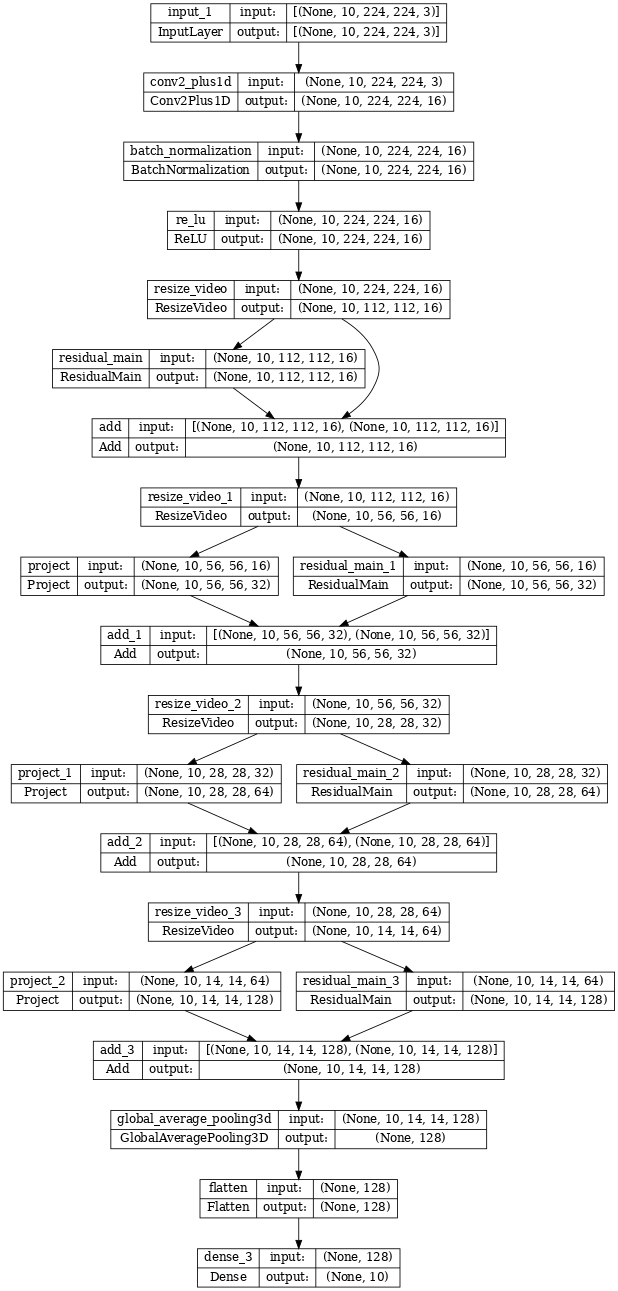

In [15]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## モデルのトレーニング

このチュートリアルでは、`tf.keras.optimizers.Adam` オプティマイザと `tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を選択します。`metrics` 引数を使用して、各ステップでのモデルパフォーマンスの精度を確認します。

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Keras `Model.fit` メソッドを使って、モデルを 50 エポック、トレーニングします。

注意: このサンプルモデルは、このチュートリアルに合理的な時間でトレーニングできるように、より少ないデータポイント（300 個のトレーニングサンプルと 100 個の検証サンプル）でトレーニングされています。また、このサンプルモデルのトレーニングには 1 時間以上かかる可能性があります。

In [17]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


I0000 00:00:1705001118.350866  129571 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      1/Unknown - 19s 19s/step - loss: 3.7456 - accuracy: 0.1250

      2/Unknown - 19s 510ms/step - loss: 3.5514 - accuracy: 0.0625

      3/Unknown - 20s 787ms/step - loss: 3.4892 - accuracy: 0.0417

      4/Unknown - 22s 962ms/step - loss: 3.3879 - accuracy: 0.0312

      5/Unknown - 23s 1s/step - loss: 3.2871 - accuracy: 0.0250   

      6/Unknown - 24s 1s/step - loss: 3.1641 - accuracy: 0.0208

      7/Unknown - 26s 1s/step - loss: 3.0875 - accuracy: 0.0179

      8/Unknown - 27s 1s/step - loss: 2.9699 - accuracy: 0.0312

      9/Unknown - 28s 1s/step - loss: 2.9269 - accuracy: 0.0417

     10/Unknown - 29s 1s/step - loss: 2.9605 - accuracy: 0.0375

     11/Unknown - 31s 1s/step - loss: 2.9218 - accuracy: 0.0341

     12/Unknown - 32s 1s/step - loss: 2.9366 - accuracy: 0.0312

     13/Unknown - 33s 1s/step - loss: 2.9005 - accuracy: 0.0288

     14/Unknown - 35s 1s/step - loss: 2.8859 - accuracy: 0.0268

     15/Unknown - 36s 1s/step - loss: 2.8616 - accuracy: 0.0333

     16/Unknown - 37s 1s/step - loss: 2.8398 - accuracy: 0.0391

     17/Unknown - 38s 1s/step - loss: 2.8150 - accuracy: 0.0515

     18/Unknown - 39s 1s/step - loss: 2.7946 - accuracy: 0.0556

     19/Unknown - 41s 1s/step - loss: 2.7876 - accuracy: 0.0592

     20/Unknown - 42s 1s/step - loss: 2.7438 - accuracy: 0.0812

     21/Unknown - 43s 1s/step - loss: 2.7416 - accuracy: 0.0833

     22/Unknown - 45s 1s/step - loss: 2.7449 - accuracy: 0.0852

     23/Unknown - 46s 1s/step - loss: 2.7403 - accuracy: 0.0870

     24/Unknown - 47s 1s/step - loss: 2.7300 - accuracy: 0.0833

     25/Unknown - 48s 1s/step - loss: 2.7144 - accuracy: 0.0900

     26/Unknown - 49s 1s/step - loss: 2.7136 - accuracy: 0.0865

     27/Unknown - 51s 1s/step - loss: 2.7152 - accuracy: 0.0880

     28/Unknown - 52s 1s/step - loss: 2.7088 - accuracy: 0.0893

     29/Unknown - 54s 1s/step - loss: 2.6947 - accuracy: 0.0905

     30/Unknown - 55s 1s/step - loss: 2.6857 - accuracy: 0.0917

     31/Unknown - 56s 1s/step - loss: 2.6643 - accuracy: 0.0887

     32/Unknown - 57s 1s/step - loss: 2.6648 - accuracy: 0.0938

     33/Unknown - 58s 1s/step - loss: 2.6541 - accuracy: 0.0947

     34/Unknown - 60s 1s/step - loss: 2.6465 - accuracy: 0.0919

     35/Unknown - 61s 1s/step - loss: 2.6451 - accuracy: 0.0929

     36/Unknown - 62s 1s/step - loss: 2.6312 - accuracy: 0.0972

     37/Unknown - 63s 1s/step - loss: 2.6190 - accuracy: 0.1014

     38/Unknown - 68s 1s/step - loss: 2.6245 - accuracy: 0.1000

38/38 [==============================] - 81s 2s/step - loss: 2.6245 - accuracy: 0.1000 - val_loss: 2.5623 - val_accuracy: 0.1000


Epoch 2/50


 1/38 [..............................] - ETA: 42s - loss: 2.8259 - accuracy: 0.0000e+00

 2/38 [>.............................] - ETA: 48s - loss: 2.4272 - accuracy: 0.1250    

 3/38 [=>............................] - ETA: 46s - loss: 2.3648 - accuracy: 0.2083

 4/38 [==>...........................] - ETA: 43s - loss: 2.3105 - accuracy: 0.1875

 5/38 [==>...........................] - ETA: 43s - loss: 2.3200 - accuracy: 0.1750

 6/38 [===>..........................] - ETA: 41s - loss: 2.3676 - accuracy: 0.1667

 7/38 [====>.........................] - ETA: 40s - loss: 2.3492 - accuracy: 0.1607

 8/38 [=====>........................] - ETA: 38s - loss: 2.4249 - accuracy: 0.1562

 9/38 [======>.......................] - ETA: 36s - loss: 2.4341 - accuracy: 0.1667

10/38 [======>.......................] - ETA: 35s - loss: 2.4480 - accuracy: 0.1500

11/38 [=======>......................] - ETA: 34s - loss: 2.4179 - accuracy: 0.1477

12/38 [========>.....................] - ETA: 32s - loss: 2.3872 - accuracy: 0.1667

13/38 [=========>....................] - ETA: 31s - loss: 2.3806 - accuracy: 0.1538

14/38 [==========>...................] - ETA: 30s - loss: 2.3682 - accuracy: 0.1696

15/38 [==========>...................] - ETA: 29s - loss: 2.3583 - accuracy: 0.1667

16/38 [===========>..................] - ETA: 27s - loss: 2.3422 - accuracy: 0.1719

17/38 [============>.................] - ETA: 26s - loss: 2.3515 - accuracy: 0.1765

18/38 [=============>................] - ETA: 25s - loss: 2.3547 - accuracy: 0.1806

19/38 [==============>...............] - ETA: 23s - loss: 2.3467 - accuracy: 0.1908

20/38 [==============>...............] - ETA: 22s - loss: 2.3557 - accuracy: 0.1813

21/38 [===============>..............] - ETA: 21s - loss: 2.3333 - accuracy: 0.1905

22/38 [================>.............] - ETA: 19s - loss: 2.3333 - accuracy: 0.1875

23/38 [=================>............] - ETA: 18s - loss: 2.3318 - accuracy: 0.1793

24/38 [=================>............] - ETA: 17s - loss: 2.3220 - accuracy: 0.1875

25/38 [==================>...........] - ETA: 16s - loss: 2.3333 - accuracy: 0.1850

26/38 [===================>..........] - ETA: 14s - loss: 2.3268 - accuracy: 0.1827

27/38 [====================>.........] - ETA: 13s - loss: 2.3230 - accuracy: 0.1806

28/38 [=====================>........] - ETA: 12s - loss: 2.3201 - accuracy: 0.1830

29/38 [=====================>........] - ETA: 11s - loss: 2.3331 - accuracy: 0.1853

30/38 [======================>.......] - ETA: 10s - loss: 2.3346 - accuracy: 0.1792

31/38 [=======================>......] - ETA: 8s - loss: 2.3321 - accuracy: 0.1734 

32/38 [========================>.....] - ETA: 7s - loss: 2.3338 - accuracy: 0.1758

33/38 [=========================>....] - ETA: 6s - loss: 2.3335 - accuracy: 0.1705

34/38 [=========================>....] - ETA: 5s - loss: 2.3358 - accuracy: 0.1654

35/38 [==========================>...] - ETA: 3s - loss: 2.3355 - accuracy: 0.1607

36/38 [===========================>..] - ETA: 2s - loss: 2.3232 - accuracy: 0.1632

37/38 [============================>.] - ETA: 1s - loss: 2.3270 - accuracy: 0.1588

38/38 [==============================] - ETA: 0s - loss: 2.3280 - accuracy: 0.1567

38/38 [==============================] - 59s 2s/step - loss: 2.3280 - accuracy: 0.1567 - val_loss: 2.4639 - val_accuracy: 0.1000


Epoch 3/50


 1/38 [..............................] - ETA: 49s - loss: 2.4616 - accuracy: 0.0000e+00

 2/38 [>.............................] - ETA: 46s - loss: 2.3212 - accuracy: 0.1250    

 3/38 [=>............................] - ETA: 46s - loss: 2.2157 - accuracy: 0.1667

 4/38 [==>...........................] - ETA: 43s - loss: 2.1876 - accuracy: 0.1562

 5/38 [==>...........................] - ETA: 42s - loss: 2.1729 - accuracy: 0.2000

 6/38 [===>..........................] - ETA: 40s - loss: 2.2061 - accuracy: 0.1875

 7/38 [====>.........................] - ETA: 39s - loss: 2.2566 - accuracy: 0.1786

 8/38 [=====>........................] - ETA: 38s - loss: 2.2382 - accuracy: 0.1875

 9/38 [======>.......................] - ETA: 36s - loss: 2.3046 - accuracy: 0.1667

10/38 [======>.......................] - ETA: 35s - loss: 2.3435 - accuracy: 0.1500

11/38 [=======>......................] - ETA: 33s - loss: 2.3233 - accuracy: 0.1477

12/38 [========>.....................] - ETA: 32s - loss: 2.2958 - accuracy: 0.1562

13/38 [=========>....................] - ETA: 31s - loss: 2.2624 - accuracy: 0.1827

14/38 [==========>...................] - ETA: 30s - loss: 2.2406 - accuracy: 0.1964

15/38 [==========>...................] - ETA: 29s - loss: 2.2419 - accuracy: 0.2083

16/38 [===========>..................] - ETA: 27s - loss: 2.2424 - accuracy: 0.2188

17/38 [============>.................] - ETA: 26s - loss: 2.2620 - accuracy: 0.2132

18/38 [=============>................] - ETA: 25s - loss: 2.2790 - accuracy: 0.2014

19/38 [==============>...............] - ETA: 23s - loss: 2.2775 - accuracy: 0.1974

20/38 [==============>...............] - ETA: 22s - loss: 2.2659 - accuracy: 0.2000

21/38 [===============>..............] - ETA: 21s - loss: 2.2482 - accuracy: 0.2083

22/38 [================>.............] - ETA: 20s - loss: 2.2643 - accuracy: 0.2045

23/38 [=================>............] - ETA: 18s - loss: 2.2934 - accuracy: 0.2011

24/38 [=================>............] - ETA: 17s - loss: 2.2856 - accuracy: 0.2031

25/38 [==================>...........] - ETA: 16s - loss: 2.2734 - accuracy: 0.2000

26/38 [===================>..........] - ETA: 14s - loss: 2.2644 - accuracy: 0.2019

27/38 [====================>.........] - ETA: 13s - loss: 2.2557 - accuracy: 0.2037

28/38 [=====================>........] - ETA: 12s - loss: 2.2608 - accuracy: 0.1964

29/38 [=====================>........] - ETA: 11s - loss: 2.2528 - accuracy: 0.2026

30/38 [======================>.......] - ETA: 10s - loss: 2.2510 - accuracy: 0.1958

31/38 [=======================>......] - ETA: 8s - loss: 2.2460 - accuracy: 0.1935 

32/38 [========================>.....] - ETA: 7s - loss: 2.2518 - accuracy: 0.1914

33/38 [=========================>....] - ETA: 6s - loss: 2.2485 - accuracy: 0.1932

34/38 [=========================>....] - ETA: 5s - loss: 2.2478 - accuracy: 0.1912

35/38 [==========================>...] - ETA: 3s - loss: 2.2325 - accuracy: 0.2000

36/38 [===========================>..] - ETA: 2s - loss: 2.2303 - accuracy: 0.1979

37/38 [============================>.] - ETA: 1s - loss: 2.2236 - accuracy: 0.1959

38/38 [==============================] - ETA: 0s - loss: 2.2286 - accuracy: 0.1933

38/38 [==============================] - 59s 2s/step - loss: 2.2286 - accuracy: 0.1933 - val_loss: 2.1820 - val_accuracy: 0.2000


Epoch 4/50


 1/38 [..............................] - ETA: 48s - loss: 1.5644 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 2.1674 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 43s - loss: 2.1767 - accuracy: 0.3333

 4/38 [==>...........................] - ETA: 41s - loss: 2.1546 - accuracy: 0.3438

 5/38 [==>...........................] - ETA: 40s - loss: 2.1878 - accuracy: 0.3250

 6/38 [===>..........................] - ETA: 39s - loss: 2.1827 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 37s - loss: 2.1301 - accuracy: 0.3214

 8/38 [=====>........................] - ETA: 36s - loss: 2.1356 - accuracy: 0.3281

 9/38 [======>.......................] - ETA: 35s - loss: 2.1260 - accuracy: 0.3472

10/38 [======>.......................] - ETA: 34s - loss: 2.1046 - accuracy: 0.3375

11/38 [=======>......................] - ETA: 33s - loss: 2.1191 - accuracy: 0.3182

12/38 [========>.....................] - ETA: 32s - loss: 2.1013 - accuracy: 0.3229

13/38 [=========>....................] - ETA: 31s - loss: 2.1257 - accuracy: 0.2981

14/38 [==========>...................] - ETA: 29s - loss: 2.1284 - accuracy: 0.2857

15/38 [==========>...................] - ETA: 28s - loss: 2.1194 - accuracy: 0.3000

16/38 [===========>..................] - ETA: 27s - loss: 2.1286 - accuracy: 0.3047

17/38 [============>.................] - ETA: 26s - loss: 2.1683 - accuracy: 0.2941

18/38 [=============>................] - ETA: 25s - loss: 2.1795 - accuracy: 0.2847

19/38 [==============>...............] - ETA: 24s - loss: 2.1813 - accuracy: 0.2829

20/38 [==============>...............] - ETA: 22s - loss: 2.1724 - accuracy: 0.2812

21/38 [===============>..............] - ETA: 21s - loss: 2.1735 - accuracy: 0.2798

22/38 [================>.............] - ETA: 20s - loss: 2.1753 - accuracy: 0.2727

23/38 [=================>............] - ETA: 19s - loss: 2.1559 - accuracy: 0.2772

24/38 [=================>............] - ETA: 17s - loss: 2.1408 - accuracy: 0.2708

25/38 [==================>...........] - ETA: 16s - loss: 2.1407 - accuracy: 0.2650

26/38 [===================>..........] - ETA: 15s - loss: 2.1200 - accuracy: 0.2788

27/38 [====================>.........] - ETA: 13s - loss: 2.1238 - accuracy: 0.2824

28/38 [=====================>........] - ETA: 12s - loss: 2.1456 - accuracy: 0.2768

29/38 [=====================>........] - ETA: 11s - loss: 2.1465 - accuracy: 0.2759

30/38 [======================>.......] - ETA: 10s - loss: 2.1403 - accuracy: 0.2750

31/38 [=======================>......] - ETA: 8s - loss: 2.1418 - accuracy: 0.2702 

32/38 [========================>.....] - ETA: 7s - loss: 2.1370 - accuracy: 0.2734

33/38 [=========================>....] - ETA: 6s - loss: 2.1362 - accuracy: 0.2727

34/38 [=========================>....] - ETA: 5s - loss: 2.1440 - accuracy: 0.2684

35/38 [==========================>...] - ETA: 3s - loss: 2.1366 - accuracy: 0.2714

36/38 [===========================>..] - ETA: 2s - loss: 2.1378 - accuracy: 0.2708

37/38 [============================>.] - ETA: 1s - loss: 2.1397 - accuracy: 0.2635

38/38 [==============================] - ETA: 0s - loss: 2.1448 - accuracy: 0.2600

38/38 [==============================] - 59s 2s/step - loss: 2.1448 - accuracy: 0.2600 - val_loss: 2.4221 - val_accuracy: 0.1600


Epoch 5/50


 1/38 [..............................] - ETA: 52s - loss: 2.2395 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 43s - loss: 2.2027 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 43s - loss: 2.1582 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 42s - loss: 2.0756 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 40s - loss: 2.0585 - accuracy: 0.2750

 6/38 [===>..........................] - ETA: 39s - loss: 2.0373 - accuracy: 0.2917

 7/38 [====>.........................] - ETA: 38s - loss: 2.0567 - accuracy: 0.3036

 8/38 [=====>........................] - ETA: 37s - loss: 2.0806 - accuracy: 0.2812

 9/38 [======>.......................] - ETA: 35s - loss: 2.0636 - accuracy: 0.2917

10/38 [======>.......................] - ETA: 34s - loss: 2.0328 - accuracy: 0.3000

11/38 [=======>......................] - ETA: 33s - loss: 2.0217 - accuracy: 0.2841

12/38 [========>.....................] - ETA: 32s - loss: 2.0470 - accuracy: 0.2604

13/38 [=========>....................] - ETA: 31s - loss: 2.0540 - accuracy: 0.2404

14/38 [==========>...................] - ETA: 29s - loss: 2.0388 - accuracy: 0.2500

15/38 [==========>...................] - ETA: 28s - loss: 2.0450 - accuracy: 0.2500

16/38 [===========>..................] - ETA: 27s - loss: 2.0241 - accuracy: 0.2578

17/38 [============>.................] - ETA: 25s - loss: 2.0151 - accuracy: 0.2647

18/38 [=============>................] - ETA: 24s - loss: 1.9874 - accuracy: 0.2847

19/38 [==============>...............] - ETA: 23s - loss: 1.9982 - accuracy: 0.2895

20/38 [==============>...............] - ETA: 22s - loss: 1.9906 - accuracy: 0.3000

21/38 [===============>..............] - ETA: 20s - loss: 1.9637 - accuracy: 0.3095

22/38 [================>.............] - ETA: 19s - loss: 1.9627 - accuracy: 0.3068

23/38 [=================>............] - ETA: 18s - loss: 1.9495 - accuracy: 0.3152

24/38 [=================>............] - ETA: 17s - loss: 1.9725 - accuracy: 0.3073

25/38 [==================>...........] - ETA: 16s - loss: 1.9679 - accuracy: 0.3150

26/38 [===================>..........] - ETA: 14s - loss: 1.9836 - accuracy: 0.3125

27/38 [====================>.........] - ETA: 13s - loss: 2.0176 - accuracy: 0.3009

28/38 [=====================>........] - ETA: 12s - loss: 2.0251 - accuracy: 0.2946

29/38 [=====================>........] - ETA: 11s - loss: 2.0174 - accuracy: 0.3060

30/38 [======================>.......] - ETA: 9s - loss: 2.0326 - accuracy: 0.2958 

31/38 [=======================>......] - ETA: 8s - loss: 2.0290 - accuracy: 0.2984

32/38 [========================>.....] - ETA: 7s - loss: 2.0285 - accuracy: 0.2969

33/38 [=========================>....] - ETA: 6s - loss: 2.0164 - accuracy: 0.2992

34/38 [=========================>....] - ETA: 4s - loss: 2.0294 - accuracy: 0.2941

35/38 [==========================>...] - ETA: 3s - loss: 2.0392 - accuracy: 0.2893

36/38 [===========================>..] - ETA: 2s - loss: 2.0224 - accuracy: 0.2917

37/38 [============================>.] - ETA: 1s - loss: 2.0254 - accuracy: 0.2939

38/38 [==============================] - ETA: 0s - loss: 2.0234 - accuracy: 0.2967

38/38 [==============================] - 59s 2s/step - loss: 2.0234 - accuracy: 0.2967 - val_loss: 2.4969 - val_accuracy: 0.2400


Epoch 6/50


 1/38 [..............................] - ETA: 47s - loss: 2.2714 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 49s - loss: 2.1695 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 46s - loss: 2.0480 - accuracy: 0.2500

 4/38 [==>...........................] - ETA: 44s - loss: 1.9622 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 41s - loss: 1.9128 - accuracy: 0.3500

 6/38 [===>..........................] - ETA: 40s - loss: 1.8312 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 38s - loss: 1.8454 - accuracy: 0.4107

 8/38 [=====>........................] - ETA: 37s - loss: 1.8533 - accuracy: 0.3906

 9/38 [======>.......................] - ETA: 36s - loss: 1.8406 - accuracy: 0.3889

10/38 [======>.......................] - ETA: 35s - loss: 1.8848 - accuracy: 0.3500

11/38 [=======>......................] - ETA: 33s - loss: 1.8600 - accuracy: 0.3523

12/38 [========>.....................] - ETA: 32s - loss: 1.8844 - accuracy: 0.3333

13/38 [=========>....................] - ETA: 31s - loss: 1.8701 - accuracy: 0.3558

14/38 [==========>...................] - ETA: 30s - loss: 1.8847 - accuracy: 0.3482

15/38 [==========>...................] - ETA: 28s - loss: 1.8604 - accuracy: 0.3583

16/38 [===========>..................] - ETA: 27s - loss: 1.8819 - accuracy: 0.3594

17/38 [============>.................] - ETA: 26s - loss: 1.8999 - accuracy: 0.3529

18/38 [=============>................] - ETA: 25s - loss: 1.8825 - accuracy: 0.3611

19/38 [==============>...............] - ETA: 23s - loss: 1.8542 - accuracy: 0.3684

20/38 [==============>...............] - ETA: 22s - loss: 1.8673 - accuracy: 0.3625

21/38 [===============>..............] - ETA: 21s - loss: 1.8466 - accuracy: 0.3690

22/38 [================>.............] - ETA: 20s - loss: 1.8602 - accuracy: 0.3580

23/38 [=================>............] - ETA: 18s - loss: 1.8388 - accuracy: 0.3696

24/38 [=================>............] - ETA: 17s - loss: 1.8629 - accuracy: 0.3646

25/38 [==================>...........] - ETA: 16s - loss: 1.8527 - accuracy: 0.3700

26/38 [===================>..........] - ETA: 15s - loss: 1.8447 - accuracy: 0.3750

27/38 [====================>.........] - ETA: 13s - loss: 1.8510 - accuracy: 0.3657

28/38 [=====================>........] - ETA: 12s - loss: 1.8608 - accuracy: 0.3571

29/38 [=====================>........] - ETA: 11s - loss: 1.8685 - accuracy: 0.3578

30/38 [======================>.......] - ETA: 9s - loss: 1.8618 - accuracy: 0.3542 

31/38 [=======================>......] - ETA: 8s - loss: 1.8572 - accuracy: 0.3548

32/38 [========================>.....] - ETA: 7s - loss: 1.8710 - accuracy: 0.3516

33/38 [=========================>....] - ETA: 6s - loss: 1.8782 - accuracy: 0.3485

34/38 [=========================>....] - ETA: 4s - loss: 1.9054 - accuracy: 0.3419

35/38 [==========================>...] - ETA: 3s - loss: 1.9045 - accuracy: 0.3393

36/38 [===========================>..] - ETA: 2s - loss: 1.9165 - accuracy: 0.3333

37/38 [============================>.] - ETA: 1s - loss: 1.9099 - accuracy: 0.3345

38/38 [==============================] - ETA: 0s - loss: 1.9068 - accuracy: 0.3333

38/38 [==============================] - 59s 2s/step - loss: 1.9068 - accuracy: 0.3333 - val_loss: 2.6993 - val_accuracy: 0.1500


Epoch 7/50


 1/38 [..............................] - ETA: 49s - loss: 1.9459 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 47s - loss: 2.0087 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 46s - loss: 2.0918 - accuracy: 0.1667

 4/38 [==>...........................] - ETA: 45s - loss: 2.0717 - accuracy: 0.2500

 5/38 [==>...........................] - ETA: 43s - loss: 1.9883 - accuracy: 0.2750

 6/38 [===>..........................] - ETA: 40s - loss: 1.9778 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 40s - loss: 1.9327 - accuracy: 0.3393

 8/38 [=====>........................] - ETA: 38s - loss: 1.9562 - accuracy: 0.3125

 9/38 [======>.......................] - ETA: 36s - loss: 1.9689 - accuracy: 0.3056

10/38 [======>.......................] - ETA: 35s - loss: 1.9552 - accuracy: 0.3000

11/38 [=======>......................] - ETA: 34s - loss: 1.9553 - accuracy: 0.2841

12/38 [========>.....................] - ETA: 32s - loss: 1.9558 - accuracy: 0.2708

13/38 [=========>....................] - ETA: 31s - loss: 1.9514 - accuracy: 0.2692

14/38 [==========>...................] - ETA: 30s - loss: 1.9341 - accuracy: 0.2857

15/38 [==========>...................] - ETA: 28s - loss: 1.9545 - accuracy: 0.2750

16/38 [===========>..................] - ETA: 27s - loss: 1.9769 - accuracy: 0.2578

17/38 [============>.................] - ETA: 26s - loss: 1.9662 - accuracy: 0.2574

18/38 [=============>................] - ETA: 25s - loss: 1.9661 - accuracy: 0.2500

19/38 [==============>...............] - ETA: 23s - loss: 1.9256 - accuracy: 0.2829

20/38 [==============>...............] - ETA: 22s - loss: 1.9324 - accuracy: 0.2812

21/38 [===============>..............] - ETA: 21s - loss: 1.9202 - accuracy: 0.2857

22/38 [================>.............] - ETA: 19s - loss: 1.9164 - accuracy: 0.2898

23/38 [=================>............] - ETA: 18s - loss: 1.9221 - accuracy: 0.2880

24/38 [=================>............] - ETA: 17s - loss: 1.9253 - accuracy: 0.2865

25/38 [==================>...........] - ETA: 16s - loss: 1.9205 - accuracy: 0.2800

26/38 [===================>..........] - ETA: 14s - loss: 1.9291 - accuracy: 0.2740

27/38 [====================>.........] - ETA: 13s - loss: 1.9424 - accuracy: 0.2778

28/38 [=====================>........] - ETA: 12s - loss: 1.9334 - accuracy: 0.2857

29/38 [=====================>........] - ETA: 11s - loss: 1.9381 - accuracy: 0.2802

30/38 [======================>.......] - ETA: 9s - loss: 1.9551 - accuracy: 0.2792 

31/38 [=======================>......] - ETA: 8s - loss: 1.9732 - accuracy: 0.2702

32/38 [========================>.....] - ETA: 7s - loss: 1.9756 - accuracy: 0.2695

33/38 [=========================>....] - ETA: 6s - loss: 1.9728 - accuracy: 0.2652

34/38 [=========================>....] - ETA: 4s - loss: 1.9661 - accuracy: 0.2721

35/38 [==========================>...] - ETA: 3s - loss: 1.9501 - accuracy: 0.2821

36/38 [===========================>..] - ETA: 2s - loss: 1.9530 - accuracy: 0.2812

37/38 [============================>.] - ETA: 1s - loss: 1.9454 - accuracy: 0.2838

38/38 [==============================] - ETA: 0s - loss: 1.9412 - accuracy: 0.2867

38/38 [==============================] - 59s 2s/step - loss: 1.9412 - accuracy: 0.2867 - val_loss: 2.3172 - val_accuracy: 0.2800


Epoch 8/50


 1/38 [..............................] - ETA: 45s - loss: 1.3210 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 43s - loss: 1.3642 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 44s - loss: 1.4910 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 42s - loss: 1.6229 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 40s - loss: 1.7571 - accuracy: 0.3250

 6/38 [===>..........................] - ETA: 40s - loss: 1.7641 - accuracy: 0.2917

 7/38 [====>.........................] - ETA: 38s - loss: 1.8726 - accuracy: 0.2500

 8/38 [=====>........................] - ETA: 37s - loss: 1.8486 - accuracy: 0.2969

 9/38 [======>.......................] - ETA: 36s - loss: 1.8568 - accuracy: 0.2639

10/38 [======>.......................] - ETA: 34s - loss: 1.8457 - accuracy: 0.2750

11/38 [=======>......................] - ETA: 33s - loss: 1.8440 - accuracy: 0.2841

12/38 [========>.....................] - ETA: 32s - loss: 1.8074 - accuracy: 0.3021

13/38 [=========>....................] - ETA: 31s - loss: 1.8142 - accuracy: 0.2981

14/38 [==========>...................] - ETA: 30s - loss: 1.8069 - accuracy: 0.2946

15/38 [==========>...................] - ETA: 28s - loss: 1.7797 - accuracy: 0.3167

16/38 [===========>..................] - ETA: 27s - loss: 1.7742 - accuracy: 0.3281

17/38 [============>.................] - ETA: 26s - loss: 1.7629 - accuracy: 0.3235

18/38 [=============>................] - ETA: 25s - loss: 1.7684 - accuracy: 0.3125

19/38 [==============>...............] - ETA: 24s - loss: 1.7507 - accuracy: 0.3289

20/38 [==============>...............] - ETA: 22s - loss: 1.7578 - accuracy: 0.3250

21/38 [===============>..............] - ETA: 21s - loss: 1.7728 - accuracy: 0.3214

22/38 [================>.............] - ETA: 20s - loss: 1.7555 - accuracy: 0.3352

23/38 [=================>............] - ETA: 18s - loss: 1.7393 - accuracy: 0.3424

24/38 [=================>............] - ETA: 17s - loss: 1.7390 - accuracy: 0.3490

25/38 [==================>...........] - ETA: 16s - loss: 1.7387 - accuracy: 0.3550

26/38 [===================>..........] - ETA: 15s - loss: 1.7643 - accuracy: 0.3413

27/38 [====================>.........] - ETA: 13s - loss: 1.7877 - accuracy: 0.3380

28/38 [=====================>........] - ETA: 12s - loss: 1.7886 - accuracy: 0.3393

29/38 [=====================>........] - ETA: 11s - loss: 1.7953 - accuracy: 0.3405

30/38 [======================>.......] - ETA: 10s - loss: 1.7724 - accuracy: 0.3542

31/38 [=======================>......] - ETA: 8s - loss: 1.7855 - accuracy: 0.3508 

32/38 [========================>.....] - ETA: 7s - loss: 1.7808 - accuracy: 0.3555

33/38 [=========================>....] - ETA: 6s - loss: 1.7887 - accuracy: 0.3523

34/38 [=========================>....] - ETA: 5s - loss: 1.7898 - accuracy: 0.3529

35/38 [==========================>...] - ETA: 3s - loss: 1.7834 - accuracy: 0.3464

36/38 [===========================>..] - ETA: 2s - loss: 1.7818 - accuracy: 0.3438

37/38 [============================>.] - ETA: 1s - loss: 1.7892 - accuracy: 0.3412

38/38 [==============================] - ETA: 0s - loss: 1.7902 - accuracy: 0.3400

38/38 [==============================] - 59s 2s/step - loss: 1.7902 - accuracy: 0.3400 - val_loss: 1.9949 - val_accuracy: 0.4000


Epoch 9/50


 1/38 [..............................] - ETA: 49s - loss: 2.2594 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 45s - loss: 1.9763 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 46s - loss: 1.7602 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 43s - loss: 1.7683 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 42s - loss: 1.6701 - accuracy: 0.4500

 6/38 [===>..........................] - ETA: 41s - loss: 1.7134 - accuracy: 0.4167

 7/38 [====>.........................] - ETA: 39s - loss: 1.7600 - accuracy: 0.3750

 8/38 [=====>........................] - ETA: 37s - loss: 1.7672 - accuracy: 0.3750

 9/38 [======>.......................] - ETA: 36s - loss: 1.7989 - accuracy: 0.3611

10/38 [======>.......................] - ETA: 35s - loss: 1.7819 - accuracy: 0.3750

11/38 [=======>......................] - ETA: 33s - loss: 1.7768 - accuracy: 0.3636

12/38 [========>.....................] - ETA: 32s - loss: 1.8255 - accuracy: 0.3333

13/38 [=========>....................] - ETA: 31s - loss: 1.8200 - accuracy: 0.3269

14/38 [==========>...................] - ETA: 30s - loss: 1.8096 - accuracy: 0.3393

15/38 [==========>...................] - ETA: 28s - loss: 1.8153 - accuracy: 0.3417

16/38 [===========>..................] - ETA: 27s - loss: 1.7924 - accuracy: 0.3516

17/38 [============>.................] - ETA: 25s - loss: 1.7722 - accuracy: 0.3529

18/38 [=============>................] - ETA: 24s - loss: 1.7463 - accuracy: 0.3681

19/38 [==============>...............] - ETA: 23s - loss: 1.7503 - accuracy: 0.3553

20/38 [==============>...............] - ETA: 22s - loss: 1.7533 - accuracy: 0.3500

21/38 [===============>..............] - ETA: 21s - loss: 1.7618 - accuracy: 0.3512

22/38 [================>.............] - ETA: 19s - loss: 1.7968 - accuracy: 0.3409

23/38 [=================>............] - ETA: 18s - loss: 1.7990 - accuracy: 0.3370

24/38 [=================>............] - ETA: 17s - loss: 1.7962 - accuracy: 0.3333

25/38 [==================>...........] - ETA: 16s - loss: 1.7898 - accuracy: 0.3350

26/38 [===================>..........] - ETA: 15s - loss: 1.7893 - accuracy: 0.3317

27/38 [====================>.........] - ETA: 13s - loss: 1.8137 - accuracy: 0.3287

28/38 [=====================>........] - ETA: 12s - loss: 1.8132 - accuracy: 0.3348

29/38 [=====================>........] - ETA: 11s - loss: 1.8136 - accuracy: 0.3276

30/38 [======================>.......] - ETA: 10s - loss: 1.8154 - accuracy: 0.3250

31/38 [=======================>......] - ETA: 8s - loss: 1.8204 - accuracy: 0.3226 

32/38 [========================>.....] - ETA: 7s - loss: 1.8245 - accuracy: 0.3203

33/38 [=========================>....] - ETA: 6s - loss: 1.8187 - accuracy: 0.3220

34/38 [=========================>....] - ETA: 5s - loss: 1.8016 - accuracy: 0.3309

35/38 [==========================>...] - ETA: 3s - loss: 1.8051 - accuracy: 0.3321

36/38 [===========================>..] - ETA: 2s - loss: 1.7957 - accuracy: 0.3333

37/38 [============================>.] - ETA: 1s - loss: 1.7898 - accuracy: 0.3311

38/38 [==============================] - ETA: 0s - loss: 1.7993 - accuracy: 0.3267

38/38 [==============================] - 59s 2s/step - loss: 1.7993 - accuracy: 0.3267 - val_loss: 2.6475 - val_accuracy: 0.2200


Epoch 10/50


 1/38 [..............................] - ETA: 52s - loss: 1.4597 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 46s - loss: 1.6399 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 44s - loss: 1.5901 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 42s - loss: 1.5248 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 42s - loss: 1.5688 - accuracy: 0.3750

 6/38 [===>..........................] - ETA: 40s - loss: 1.6261 - accuracy: 0.3750

 7/38 [====>.........................] - ETA: 39s - loss: 1.7215 - accuracy: 0.3571

 8/38 [=====>........................] - ETA: 38s - loss: 1.7241 - accuracy: 0.3438

 9/38 [======>.......................] - ETA: 37s - loss: 1.7572 - accuracy: 0.3194

10/38 [======>.......................] - ETA: 35s - loss: 1.7459 - accuracy: 0.3250

11/38 [=======>......................] - ETA: 33s - loss: 1.7670 - accuracy: 0.2955

12/38 [========>.....................] - ETA: 32s - loss: 1.7763 - accuracy: 0.2917

13/38 [=========>....................] - ETA: 30s - loss: 1.7574 - accuracy: 0.2981

14/38 [==========>...................] - ETA: 29s - loss: 1.7730 - accuracy: 0.3125

15/38 [==========>...................] - ETA: 28s - loss: 1.7590 - accuracy: 0.3167

16/38 [===========>..................] - ETA: 27s - loss: 1.7415 - accuracy: 0.3203

17/38 [============>.................] - ETA: 25s - loss: 1.7443 - accuracy: 0.3162

18/38 [=============>................] - ETA: 24s - loss: 1.7805 - accuracy: 0.3056

19/38 [==============>...............] - ETA: 23s - loss: 1.7959 - accuracy: 0.3092

20/38 [==============>...............] - ETA: 22s - loss: 1.7921 - accuracy: 0.3125

21/38 [===============>..............] - ETA: 21s - loss: 1.7842 - accuracy: 0.3155

22/38 [================>.............] - ETA: 19s - loss: 1.7892 - accuracy: 0.3182

23/38 [=================>............] - ETA: 18s - loss: 1.7777 - accuracy: 0.3207

24/38 [=================>............] - ETA: 17s - loss: 1.7674 - accuracy: 0.3333

25/38 [==================>...........] - ETA: 16s - loss: 1.7594 - accuracy: 0.3350

26/38 [===================>..........] - ETA: 14s - loss: 1.7614 - accuracy: 0.3317

27/38 [====================>.........] - ETA: 13s - loss: 1.7516 - accuracy: 0.3333

28/38 [=====================>........] - ETA: 12s - loss: 1.7504 - accuracy: 0.3259

29/38 [=====================>........] - ETA: 11s - loss: 1.7266 - accuracy: 0.3405

30/38 [======================>.......] - ETA: 9s - loss: 1.7382 - accuracy: 0.3333 

31/38 [=======================>......] - ETA: 8s - loss: 1.7316 - accuracy: 0.3387

32/38 [========================>.....] - ETA: 7s - loss: 1.7373 - accuracy: 0.3398

33/38 [=========================>....] - ETA: 6s - loss: 1.7447 - accuracy: 0.3409

34/38 [=========================>....] - ETA: 4s - loss: 1.7566 - accuracy: 0.3456

35/38 [==========================>...] - ETA: 3s - loss: 1.7439 - accuracy: 0.3536

36/38 [===========================>..] - ETA: 2s - loss: 1.7383 - accuracy: 0.3542

37/38 [============================>.] - ETA: 1s - loss: 1.7413 - accuracy: 0.3514

38/38 [==============================] - ETA: 0s - loss: 1.7501 - accuracy: 0.3500

38/38 [==============================] - 59s 2s/step - loss: 1.7501 - accuracy: 0.3500 - val_loss: 1.7358 - val_accuracy: 0.4700


Epoch 11/50


 1/38 [..............................] - ETA: 45s - loss: 1.2930 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 41s - loss: 1.5330 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 43s - loss: 1.6229 - accuracy: 0.3333

 4/38 [==>...........................] - ETA: 42s - loss: 1.6538 - accuracy: 0.3438

 5/38 [==>...........................] - ETA: 40s - loss: 1.6709 - accuracy: 0.3500

 6/38 [===>..........................] - ETA: 39s - loss: 1.6582 - accuracy: 0.3542

 7/38 [====>.........................] - ETA: 37s - loss: 1.6573 - accuracy: 0.3393

 8/38 [=====>........................] - ETA: 36s - loss: 1.6514 - accuracy: 0.3438

 9/38 [======>.......................] - ETA: 35s - loss: 1.6576 - accuracy: 0.3611

10/38 [======>.......................] - ETA: 34s - loss: 1.6719 - accuracy: 0.3500

11/38 [=======>......................] - ETA: 33s - loss: 1.7282 - accuracy: 0.3182

12/38 [========>.....................] - ETA: 32s - loss: 1.7448 - accuracy: 0.3021

13/38 [=========>....................] - ETA: 31s - loss: 1.7927 - accuracy: 0.2981

14/38 [==========>...................] - ETA: 30s - loss: 1.7937 - accuracy: 0.3036

15/38 [==========>...................] - ETA: 28s - loss: 1.7676 - accuracy: 0.3250

16/38 [===========>..................] - ETA: 27s - loss: 1.8047 - accuracy: 0.3125

17/38 [============>.................] - ETA: 26s - loss: 1.7959 - accuracy: 0.3088

18/38 [=============>................] - ETA: 25s - loss: 1.7998 - accuracy: 0.3056

19/38 [==============>...............] - ETA: 23s - loss: 1.7951 - accuracy: 0.3092

20/38 [==============>...............] - ETA: 22s - loss: 1.7850 - accuracy: 0.3000

21/38 [===============>..............] - ETA: 21s - loss: 1.7536 - accuracy: 0.3095

22/38 [================>.............] - ETA: 20s - loss: 1.7537 - accuracy: 0.3068

23/38 [=================>............] - ETA: 19s - loss: 1.7426 - accuracy: 0.2989

24/38 [=================>............] - ETA: 17s - loss: 1.7570 - accuracy: 0.2865

25/38 [==================>...........] - ETA: 16s - loss: 1.7360 - accuracy: 0.2950

26/38 [===================>..........] - ETA: 15s - loss: 1.7191 - accuracy: 0.3029

27/38 [====================>.........] - ETA: 13s - loss: 1.7267 - accuracy: 0.2963

28/38 [=====================>........] - ETA: 12s - loss: 1.7137 - accuracy: 0.3036

29/38 [=====================>........] - ETA: 11s - loss: 1.7061 - accuracy: 0.3060

30/38 [======================>.......] - ETA: 10s - loss: 1.6959 - accuracy: 0.3125

31/38 [=======================>......] - ETA: 8s - loss: 1.6969 - accuracy: 0.3145 

32/38 [========================>.....] - ETA: 7s - loss: 1.6875 - accuracy: 0.3203

33/38 [=========================>....] - ETA: 6s - loss: 1.6788 - accuracy: 0.3295

34/38 [=========================>....] - ETA: 5s - loss: 1.6857 - accuracy: 0.3309

35/38 [==========================>...] - ETA: 3s - loss: 1.6868 - accuracy: 0.3357

36/38 [===========================>..] - ETA: 2s - loss: 1.6862 - accuracy: 0.3368

37/38 [============================>.] - ETA: 1s - loss: 1.6773 - accuracy: 0.3345

38/38 [==============================] - ETA: 0s - loss: 1.6817 - accuracy: 0.3300

38/38 [==============================] - 59s 2s/step - loss: 1.6817 - accuracy: 0.3300 - val_loss: 2.1962 - val_accuracy: 0.2600


Epoch 12/50


 1/38 [..............................] - ETA: 46s - loss: 0.9740 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 1.4155 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 44s - loss: 1.5998 - accuracy: 0.3333

 4/38 [==>...........................] - ETA: 44s - loss: 1.6781 - accuracy: 0.3438

 5/38 [==>...........................] - ETA: 43s - loss: 1.6746 - accuracy: 0.3250

 6/38 [===>..........................] - ETA: 41s - loss: 1.6614 - accuracy: 0.3333

 7/38 [====>.........................] - ETA: 40s - loss: 1.6836 - accuracy: 0.3393

 8/38 [=====>........................] - ETA: 38s - loss: 1.6389 - accuracy: 0.3594

 9/38 [======>.......................] - ETA: 37s - loss: 1.6454 - accuracy: 0.3611

10/38 [======>.......................] - ETA: 36s - loss: 1.6001 - accuracy: 0.3750

11/38 [=======>......................] - ETA: 34s - loss: 1.5714 - accuracy: 0.3750

12/38 [========>.....................] - ETA: 32s - loss: 1.6265 - accuracy: 0.3646

13/38 [=========>....................] - ETA: 31s - loss: 1.6556 - accuracy: 0.3462

14/38 [==========>...................] - ETA: 30s - loss: 1.6614 - accuracy: 0.3393

15/38 [==========>...................] - ETA: 28s - loss: 1.6734 - accuracy: 0.3250

16/38 [===========>..................] - ETA: 27s - loss: 1.6609 - accuracy: 0.3281

17/38 [============>.................] - ETA: 26s - loss: 1.6454 - accuracy: 0.3309

18/38 [=============>................] - ETA: 25s - loss: 1.6058 - accuracy: 0.3542

19/38 [==============>...............] - ETA: 23s - loss: 1.6191 - accuracy: 0.3553

20/38 [==============>...............] - ETA: 22s - loss: 1.6148 - accuracy: 0.3625

21/38 [===============>..............] - ETA: 21s - loss: 1.6276 - accuracy: 0.3631

22/38 [================>.............] - ETA: 20s - loss: 1.6188 - accuracy: 0.3693

23/38 [=================>............] - ETA: 18s - loss: 1.6129 - accuracy: 0.3750

24/38 [=================>............] - ETA: 17s - loss: 1.6350 - accuracy: 0.3750

25/38 [==================>...........] - ETA: 16s - loss: 1.6224 - accuracy: 0.3700

26/38 [===================>..........] - ETA: 15s - loss: 1.6262 - accuracy: 0.3750

27/38 [====================>.........] - ETA: 13s - loss: 1.6367 - accuracy: 0.3657

28/38 [=====================>........] - ETA: 12s - loss: 1.6351 - accuracy: 0.3661

29/38 [=====================>........] - ETA: 11s - loss: 1.6471 - accuracy: 0.3621

30/38 [======================>.......] - ETA: 9s - loss: 1.6418 - accuracy: 0.3625 

31/38 [=======================>......] - ETA: 8s - loss: 1.6557 - accuracy: 0.3589

32/38 [========================>.....] - ETA: 7s - loss: 1.6748 - accuracy: 0.3516

33/38 [=========================>....] - ETA: 6s - loss: 1.6697 - accuracy: 0.3598

34/38 [=========================>....] - ETA: 5s - loss: 1.6692 - accuracy: 0.3566

35/38 [==========================>...] - ETA: 3s - loss: 1.6746 - accuracy: 0.3500

36/38 [===========================>..] - ETA: 2s - loss: 1.6897 - accuracy: 0.3438

37/38 [============================>.] - ETA: 1s - loss: 1.6915 - accuracy: 0.3378

38/38 [==============================] - ETA: 0s - loss: 1.6873 - accuracy: 0.3400

38/38 [==============================] - 59s 2s/step - loss: 1.6873 - accuracy: 0.3400 - val_loss: 2.1749 - val_accuracy: 0.3100


Epoch 13/50


 1/38 [..............................] - ETA: 45s - loss: 1.2406 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 43s - loss: 1.4151 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 41s - loss: 1.3907 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 40s - loss: 1.3788 - accuracy: 0.5000

 5/38 [==>...........................] - ETA: 39s - loss: 1.4899 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 37s - loss: 1.4634 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 37s - loss: 1.4630 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 36s - loss: 1.4619 - accuracy: 0.4688

 9/38 [======>.......................] - ETA: 35s - loss: 1.5101 - accuracy: 0.4444

10/38 [======>.......................] - ETA: 34s - loss: 1.4581 - accuracy: 0.4625

11/38 [=======>......................] - ETA: 33s - loss: 1.5140 - accuracy: 0.4432

12/38 [========>.....................] - ETA: 32s - loss: 1.5521 - accuracy: 0.4167

13/38 [=========>....................] - ETA: 31s - loss: 1.5602 - accuracy: 0.4038

14/38 [==========>...................] - ETA: 29s - loss: 1.5619 - accuracy: 0.4018

15/38 [==========>...................] - ETA: 28s - loss: 1.5561 - accuracy: 0.4083

16/38 [===========>..................] - ETA: 27s - loss: 1.5712 - accuracy: 0.4141

17/38 [============>.................] - ETA: 25s - loss: 1.5723 - accuracy: 0.4191

18/38 [=============>................] - ETA: 24s - loss: 1.5826 - accuracy: 0.4028

19/38 [==============>...............] - ETA: 23s - loss: 1.5848 - accuracy: 0.4013

20/38 [==============>...............] - ETA: 22s - loss: 1.5840 - accuracy: 0.4000

21/38 [===============>..............] - ETA: 21s - loss: 1.5917 - accuracy: 0.3988

22/38 [================>.............] - ETA: 19s - loss: 1.5747 - accuracy: 0.3920

23/38 [=================>............] - ETA: 18s - loss: 1.5515 - accuracy: 0.4022

24/38 [=================>............] - ETA: 17s - loss: 1.5535 - accuracy: 0.4010

25/38 [==================>...........] - ETA: 16s - loss: 1.5579 - accuracy: 0.4050

26/38 [===================>..........] - ETA: 14s - loss: 1.5533 - accuracy: 0.4087

27/38 [====================>.........] - ETA: 13s - loss: 1.5539 - accuracy: 0.4074

28/38 [=====================>........] - ETA: 12s - loss: 1.5455 - accuracy: 0.4196

29/38 [=====================>........] - ETA: 11s - loss: 1.5553 - accuracy: 0.4138

30/38 [======================>.......] - ETA: 9s - loss: 1.5428 - accuracy: 0.4208 

31/38 [=======================>......] - ETA: 8s - loss: 1.5491 - accuracy: 0.4234

32/38 [========================>.....] - ETA: 7s - loss: 1.5672 - accuracy: 0.4180

33/38 [=========================>....] - ETA: 6s - loss: 1.5743 - accuracy: 0.4242

34/38 [=========================>....] - ETA: 4s - loss: 1.5699 - accuracy: 0.4228

35/38 [==========================>...] - ETA: 3s - loss: 1.5601 - accuracy: 0.4214

36/38 [===========================>..] - ETA: 2s - loss: 1.5624 - accuracy: 0.4167

37/38 [============================>.] - ETA: 1s - loss: 1.5558 - accuracy: 0.4189

38/38 [==============================] - ETA: 0s - loss: 1.5595 - accuracy: 0.4200

38/38 [==============================] - 59s 2s/step - loss: 1.5595 - accuracy: 0.4200 - val_loss: 1.9248 - val_accuracy: 0.3500


Epoch 14/50


 1/38 [..............................] - ETA: 50s - loss: 1.6611 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 47s - loss: 1.4677 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 43s - loss: 1.6556 - accuracy: 0.2500

 4/38 [==>...........................] - ETA: 41s - loss: 1.5557 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 39s - loss: 1.4136 - accuracy: 0.4250

 6/38 [===>..........................] - ETA: 38s - loss: 1.4307 - accuracy: 0.4167

 7/38 [====>.........................] - ETA: 38s - loss: 1.4163 - accuracy: 0.4464

 8/38 [=====>........................] - ETA: 37s - loss: 1.4355 - accuracy: 0.4375

 9/38 [======>.......................] - ETA: 35s - loss: 1.3731 - accuracy: 0.4583

10/38 [======>.......................] - ETA: 34s - loss: 1.3484 - accuracy: 0.4750

11/38 [=======>......................] - ETA: 33s - loss: 1.3361 - accuracy: 0.4773

12/38 [========>.....................] - ETA: 31s - loss: 1.3657 - accuracy: 0.4792

13/38 [=========>....................] - ETA: 30s - loss: 1.3904 - accuracy: 0.4712

14/38 [==========>...................] - ETA: 29s - loss: 1.4006 - accuracy: 0.4732

15/38 [==========>...................] - ETA: 28s - loss: 1.3764 - accuracy: 0.5000

16/38 [===========>..................] - ETA: 27s - loss: 1.3754 - accuracy: 0.5000

17/38 [============>.................] - ETA: 25s - loss: 1.3924 - accuracy: 0.4706

18/38 [=============>................] - ETA: 24s - loss: 1.4200 - accuracy: 0.4722

19/38 [==============>...............] - ETA: 23s - loss: 1.4146 - accuracy: 0.4868

20/38 [==============>...............] - ETA: 22s - loss: 1.4401 - accuracy: 0.4812

21/38 [===============>..............] - ETA: 20s - loss: 1.4424 - accuracy: 0.4762

22/38 [================>.............] - ETA: 19s - loss: 1.4736 - accuracy: 0.4659

23/38 [=================>............] - ETA: 18s - loss: 1.4794 - accuracy: 0.4674

24/38 [=================>............] - ETA: 17s - loss: 1.4782 - accuracy: 0.4583

25/38 [==================>...........] - ETA: 16s - loss: 1.4787 - accuracy: 0.4500

26/38 [===================>..........] - ETA: 14s - loss: 1.4851 - accuracy: 0.4423

27/38 [====================>.........] - ETA: 13s - loss: 1.4853 - accuracy: 0.4398

28/38 [=====================>........] - ETA: 12s - loss: 1.4869 - accuracy: 0.4375

29/38 [=====================>........] - ETA: 11s - loss: 1.4867 - accuracy: 0.4353

30/38 [======================>.......] - ETA: 9s - loss: 1.4824 - accuracy: 0.4333 

31/38 [=======================>......] - ETA: 8s - loss: 1.4949 - accuracy: 0.4274

32/38 [========================>.....] - ETA: 7s - loss: 1.4989 - accuracy: 0.4180

33/38 [=========================>....] - ETA: 6s - loss: 1.5027 - accuracy: 0.4167

34/38 [=========================>....] - ETA: 4s - loss: 1.5199 - accuracy: 0.4118

35/38 [==========================>...] - ETA: 3s - loss: 1.5090 - accuracy: 0.4143

36/38 [===========================>..] - ETA: 2s - loss: 1.5070 - accuracy: 0.4201

37/38 [============================>.] - ETA: 1s - loss: 1.5079 - accuracy: 0.4223

38/38 [==============================] - ETA: 0s - loss: 1.5023 - accuracy: 0.4233

38/38 [==============================] - 59s 2s/step - loss: 1.5023 - accuracy: 0.4233 - val_loss: 2.2648 - val_accuracy: 0.2300


Epoch 15/50


 1/38 [..............................] - ETA: 54s - loss: 1.5608 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 41s - loss: 1.5627 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 43s - loss: 1.5795 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 41s - loss: 1.4756 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 40s - loss: 1.5513 - accuracy: 0.4000

 6/38 [===>..........................] - ETA: 39s - loss: 1.5613 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 38s - loss: 1.5781 - accuracy: 0.3929

 8/38 [=====>........................] - ETA: 36s - loss: 1.5587 - accuracy: 0.3906

 9/38 [======>.......................] - ETA: 35s - loss: 1.5171 - accuracy: 0.4028

10/38 [======>.......................] - ETA: 34s - loss: 1.5382 - accuracy: 0.4000

11/38 [=======>......................] - ETA: 33s - loss: 1.5333 - accuracy: 0.4205

12/38 [========>.....................] - ETA: 32s - loss: 1.5484 - accuracy: 0.4167

13/38 [=========>....................] - ETA: 30s - loss: 1.5620 - accuracy: 0.4135

14/38 [==========>...................] - ETA: 29s - loss: 1.5517 - accuracy: 0.4196

15/38 [==========>...................] - ETA: 28s - loss: 1.5791 - accuracy: 0.4167

16/38 [===========>..................] - ETA: 27s - loss: 1.5883 - accuracy: 0.4062

17/38 [============>.................] - ETA: 25s - loss: 1.5592 - accuracy: 0.4265

18/38 [=============>................] - ETA: 24s - loss: 1.5345 - accuracy: 0.4444

19/38 [==============>...............] - ETA: 23s - loss: 1.5249 - accuracy: 0.4408

20/38 [==============>...............] - ETA: 22s - loss: 1.5531 - accuracy: 0.4313

21/38 [===============>..............] - ETA: 20s - loss: 1.5579 - accuracy: 0.4226

22/38 [================>.............] - ETA: 19s - loss: 1.5584 - accuracy: 0.4148

23/38 [=================>............] - ETA: 18s - loss: 1.5525 - accuracy: 0.4239

24/38 [=================>............] - ETA: 17s - loss: 1.5535 - accuracy: 0.4219

25/38 [==================>...........] - ETA: 16s - loss: 1.5357 - accuracy: 0.4250

26/38 [===================>..........] - ETA: 14s - loss: 1.5485 - accuracy: 0.4183

27/38 [====================>.........] - ETA: 13s - loss: 1.5409 - accuracy: 0.4167

28/38 [=====================>........] - ETA: 12s - loss: 1.5442 - accuracy: 0.4107

29/38 [=====================>........] - ETA: 11s - loss: 1.5486 - accuracy: 0.4095

30/38 [======================>.......] - ETA: 9s - loss: 1.5341 - accuracy: 0.4167 

31/38 [=======================>......] - ETA: 8s - loss: 1.5291 - accuracy: 0.4113

32/38 [========================>.....] - ETA: 7s - loss: 1.5224 - accuracy: 0.4180

33/38 [=========================>....] - ETA: 6s - loss: 1.5178 - accuracy: 0.4205

34/38 [=========================>....] - ETA: 4s - loss: 1.5091 - accuracy: 0.4191

35/38 [==========================>...] - ETA: 3s - loss: 1.4993 - accuracy: 0.4250

36/38 [===========================>..] - ETA: 2s - loss: 1.4879 - accuracy: 0.4340

37/38 [============================>.] - ETA: 1s - loss: 1.4788 - accuracy: 0.4324

38/38 [==============================] - ETA: 0s - loss: 1.4752 - accuracy: 0.4333

38/38 [==============================] - 59s 2s/step - loss: 1.4752 - accuracy: 0.4333 - val_loss: 1.6515 - val_accuracy: 0.4400


Epoch 16/50


 1/38 [..............................] - ETA: 44s - loss: 1.4417 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 44s - loss: 1.6779 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 43s - loss: 1.4826 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 41s - loss: 1.3586 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 40s - loss: 1.4715 - accuracy: 0.5250

 6/38 [===>..........................] - ETA: 39s - loss: 1.4782 - accuracy: 0.4792

 7/38 [====>.........................] - ETA: 38s - loss: 1.4291 - accuracy: 0.5000

 8/38 [=====>........................] - ETA: 37s - loss: 1.4401 - accuracy: 0.4844

 9/38 [======>.......................] - ETA: 36s - loss: 1.3928 - accuracy: 0.5278

10/38 [======>.......................] - ETA: 34s - loss: 1.3868 - accuracy: 0.5500

11/38 [=======>......................] - ETA: 33s - loss: 1.4312 - accuracy: 0.5227

12/38 [========>.....................] - ETA: 32s - loss: 1.4085 - accuracy: 0.5208

13/38 [=========>....................] - ETA: 31s - loss: 1.4211 - accuracy: 0.5096

14/38 [==========>...................] - ETA: 29s - loss: 1.4114 - accuracy: 0.5089

15/38 [==========>...................] - ETA: 28s - loss: 1.4280 - accuracy: 0.5000

16/38 [===========>..................] - ETA: 27s - loss: 1.4402 - accuracy: 0.4766

17/38 [============>.................] - ETA: 26s - loss: 1.4028 - accuracy: 0.5074

18/38 [=============>................] - ETA: 24s - loss: 1.3944 - accuracy: 0.5139

19/38 [==============>...............] - ETA: 23s - loss: 1.3721 - accuracy: 0.5066

20/38 [==============>...............] - ETA: 22s - loss: 1.3663 - accuracy: 0.5125

21/38 [===============>..............] - ETA: 21s - loss: 1.3757 - accuracy: 0.5119

22/38 [================>.............] - ETA: 20s - loss: 1.3722 - accuracy: 0.5114

23/38 [=================>............] - ETA: 18s - loss: 1.3741 - accuracy: 0.5109

24/38 [=================>............] - ETA: 17s - loss: 1.3754 - accuracy: 0.5104

25/38 [==================>...........] - ETA: 16s - loss: 1.3978 - accuracy: 0.5050

26/38 [===================>..........] - ETA: 15s - loss: 1.3998 - accuracy: 0.5048

27/38 [====================>.........] - ETA: 13s - loss: 1.4167 - accuracy: 0.5000

28/38 [=====================>........] - ETA: 12s - loss: 1.4086 - accuracy: 0.5000

29/38 [=====================>........] - ETA: 11s - loss: 1.3950 - accuracy: 0.5043

30/38 [======================>.......] - ETA: 10s - loss: 1.4126 - accuracy: 0.4958

31/38 [=======================>......] - ETA: 8s - loss: 1.4199 - accuracy: 0.4879 

32/38 [========================>.....] - ETA: 7s - loss: 1.4189 - accuracy: 0.4883

33/38 [=========================>....] - ETA: 6s - loss: 1.4224 - accuracy: 0.4848

34/38 [=========================>....] - ETA: 5s - loss: 1.4213 - accuracy: 0.4853

35/38 [==========================>...] - ETA: 3s - loss: 1.4117 - accuracy: 0.4893

36/38 [===========================>..] - ETA: 2s - loss: 1.4271 - accuracy: 0.4826

37/38 [============================>.] - ETA: 1s - loss: 1.4216 - accuracy: 0.4865

38/38 [==============================] - ETA: 0s - loss: 1.4280 - accuracy: 0.4833

38/38 [==============================] - 59s 2s/step - loss: 1.4280 - accuracy: 0.4833 - val_loss: 1.6030 - val_accuracy: 0.4200


Epoch 17/50


 1/38 [..............................] - ETA: 49s - loss: 1.2699 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 45s - loss: 1.2963 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 43s - loss: 1.3623 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 41s - loss: 1.2682 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 39s - loss: 1.2064 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 39s - loss: 1.2412 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 37s - loss: 1.1827 - accuracy: 0.5357

 8/38 [=====>........................] - ETA: 37s - loss: 1.2328 - accuracy: 0.5312

 9/38 [======>.......................] - ETA: 36s - loss: 1.2046 - accuracy: 0.5278

10/38 [======>.......................] - ETA: 34s - loss: 1.1868 - accuracy: 0.5500

11/38 [=======>......................] - ETA: 33s - loss: 1.2460 - accuracy: 0.5114

12/38 [========>.....................] - ETA: 32s - loss: 1.2631 - accuracy: 0.5104

13/38 [=========>....................] - ETA: 31s - loss: 1.2576 - accuracy: 0.5096

14/38 [==========>...................] - ETA: 29s - loss: 1.2679 - accuracy: 0.5000

15/38 [==========>...................] - ETA: 28s - loss: 1.2922 - accuracy: 0.5000

16/38 [===========>..................] - ETA: 27s - loss: 1.2926 - accuracy: 0.5000

17/38 [============>.................] - ETA: 26s - loss: 1.3103 - accuracy: 0.4853

18/38 [=============>................] - ETA: 25s - loss: 1.3120 - accuracy: 0.5000

19/38 [==============>...............] - ETA: 23s - loss: 1.3249 - accuracy: 0.5000

20/38 [==============>...............] - ETA: 22s - loss: 1.3296 - accuracy: 0.5000

21/38 [===============>..............] - ETA: 21s - loss: 1.3656 - accuracy: 0.4821

22/38 [================>.............] - ETA: 19s - loss: 1.3829 - accuracy: 0.4773

23/38 [=================>............] - ETA: 18s - loss: 1.3640 - accuracy: 0.4891

24/38 [=================>............] - ETA: 17s - loss: 1.3552 - accuracy: 0.4948

25/38 [==================>...........] - ETA: 16s - loss: 1.3571 - accuracy: 0.4950

26/38 [===================>..........] - ETA: 14s - loss: 1.3506 - accuracy: 0.5000

27/38 [====================>.........] - ETA: 13s - loss: 1.3441 - accuracy: 0.5046

28/38 [=====================>........] - ETA: 12s - loss: 1.3207 - accuracy: 0.5179

29/38 [=====================>........] - ETA: 11s - loss: 1.3238 - accuracy: 0.5216

30/38 [======================>.......] - ETA: 9s - loss: 1.3332 - accuracy: 0.5208 

31/38 [=======================>......] - ETA: 8s - loss: 1.3266 - accuracy: 0.5161

32/38 [========================>.....] - ETA: 7s - loss: 1.3331 - accuracy: 0.5195

33/38 [=========================>....] - ETA: 6s - loss: 1.3545 - accuracy: 0.5114

34/38 [=========================>....] - ETA: 4s - loss: 1.3559 - accuracy: 0.5074

35/38 [==========================>...] - ETA: 3s - loss: 1.3665 - accuracy: 0.5036

36/38 [===========================>..] - ETA: 2s - loss: 1.3564 - accuracy: 0.5104

37/38 [============================>.] - ETA: 1s - loss: 1.3443 - accuracy: 0.5135

38/38 [==============================] - ETA: 0s - loss: 1.3430 - accuracy: 0.5133

38/38 [==============================] - 59s 2s/step - loss: 1.3430 - accuracy: 0.5133 - val_loss: 1.6696 - val_accuracy: 0.3600


Epoch 18/50


 1/38 [..............................] - ETA: 50s - loss: 1.1038 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 1.2346 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 40s - loss: 1.1624 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 39s - loss: 1.1414 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 39s - loss: 1.1198 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 38s - loss: 1.1257 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 37s - loss: 1.1875 - accuracy: 0.6250

 8/38 [=====>........................] - ETA: 35s - loss: 1.2102 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 34s - loss: 1.2080 - accuracy: 0.5833

10/38 [======>.......................] - ETA: 33s - loss: 1.1788 - accuracy: 0.6000

11/38 [=======>......................] - ETA: 32s - loss: 1.1895 - accuracy: 0.5909

12/38 [========>.....................] - ETA: 31s - loss: 1.2029 - accuracy: 0.5833

13/38 [=========>....................] - ETA: 30s - loss: 1.2158 - accuracy: 0.5673

14/38 [==========>...................] - ETA: 29s - loss: 1.2039 - accuracy: 0.5714

15/38 [==========>...................] - ETA: 28s - loss: 1.2030 - accuracy: 0.5750

16/38 [===========>..................] - ETA: 27s - loss: 1.2082 - accuracy: 0.5781

17/38 [============>.................] - ETA: 25s - loss: 1.1934 - accuracy: 0.5735

18/38 [=============>................] - ETA: 24s - loss: 1.2115 - accuracy: 0.5486

19/38 [==============>...............] - ETA: 23s - loss: 1.2105 - accuracy: 0.5592

20/38 [==============>...............] - ETA: 22s - loss: 1.2231 - accuracy: 0.5562

21/38 [===============>..............] - ETA: 20s - loss: 1.2127 - accuracy: 0.5655

22/38 [================>.............] - ETA: 19s - loss: 1.2184 - accuracy: 0.5739

23/38 [=================>............] - ETA: 18s - loss: 1.2205 - accuracy: 0.5652

24/38 [=================>............] - ETA: 17s - loss: 1.2501 - accuracy: 0.5417

25/38 [==================>...........] - ETA: 16s - loss: 1.2366 - accuracy: 0.5450

26/38 [===================>..........] - ETA: 14s - loss: 1.2408 - accuracy: 0.5433

27/38 [====================>.........] - ETA: 13s - loss: 1.2337 - accuracy: 0.5509

28/38 [=====================>........] - ETA: 12s - loss: 1.2434 - accuracy: 0.5491

29/38 [=====================>........] - ETA: 11s - loss: 1.2296 - accuracy: 0.5560

30/38 [======================>.......] - ETA: 9s - loss: 1.2167 - accuracy: 0.5625 

31/38 [=======================>......] - ETA: 8s - loss: 1.2213 - accuracy: 0.5565

32/38 [========================>.....] - ETA: 7s - loss: 1.2200 - accuracy: 0.5625

33/38 [=========================>....] - ETA: 6s - loss: 1.2274 - accuracy: 0.5606

34/38 [=========================>....] - ETA: 4s - loss: 1.2261 - accuracy: 0.5551

35/38 [==========================>...] - ETA: 3s - loss: 1.2215 - accuracy: 0.5571

36/38 [===========================>..] - ETA: 2s - loss: 1.2365 - accuracy: 0.5521

37/38 [============================>.] - ETA: 1s - loss: 1.2509 - accuracy: 0.5473

38/38 [==============================] - ETA: 0s - loss: 1.2448 - accuracy: 0.5467

38/38 [==============================] - 59s 2s/step - loss: 1.2448 - accuracy: 0.5467 - val_loss: 1.4545 - val_accuracy: 0.4800


Epoch 19/50


 1/38 [..............................] - ETA: 48s - loss: 1.5829 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 51s - loss: 1.5328 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 46s - loss: 1.3059 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 43s - loss: 1.2999 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 42s - loss: 1.5006 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 40s - loss: 1.4073 - accuracy: 0.5417

 7/38 [====>.........................] - ETA: 39s - loss: 1.3876 - accuracy: 0.5179

 8/38 [=====>........................] - ETA: 37s - loss: 1.3246 - accuracy: 0.5469

 9/38 [======>.......................] - ETA: 36s - loss: 1.3206 - accuracy: 0.5556

10/38 [======>.......................] - ETA: 35s - loss: 1.3169 - accuracy: 0.5500

11/38 [=======>......................] - ETA: 33s - loss: 1.3814 - accuracy: 0.5341

12/38 [========>.....................] - ETA: 32s - loss: 1.3499 - accuracy: 0.5312

13/38 [=========>....................] - ETA: 31s - loss: 1.3525 - accuracy: 0.5288

14/38 [==========>...................] - ETA: 29s - loss: 1.3465 - accuracy: 0.5268

15/38 [==========>...................] - ETA: 28s - loss: 1.3621 - accuracy: 0.5250

16/38 [===========>..................] - ETA: 27s - loss: 1.3769 - accuracy: 0.5078

17/38 [============>.................] - ETA: 26s - loss: 1.4143 - accuracy: 0.5074

18/38 [=============>................] - ETA: 25s - loss: 1.3820 - accuracy: 0.5139

19/38 [==============>...............] - ETA: 23s - loss: 1.4107 - accuracy: 0.4934

20/38 [==============>...............] - ETA: 22s - loss: 1.3916 - accuracy: 0.5000

21/38 [===============>..............] - ETA: 21s - loss: 1.3734 - accuracy: 0.5119

22/38 [================>.............] - ETA: 20s - loss: 1.3627 - accuracy: 0.5114

23/38 [=================>............] - ETA: 18s - loss: 1.3675 - accuracy: 0.5054

24/38 [=================>............] - ETA: 17s - loss: 1.3747 - accuracy: 0.5052

25/38 [==================>...........] - ETA: 16s - loss: 1.3729 - accuracy: 0.5100

26/38 [===================>..........] - ETA: 15s - loss: 1.3452 - accuracy: 0.5240

27/38 [====================>.........] - ETA: 13s - loss: 1.3571 - accuracy: 0.5185

28/38 [=====================>........] - ETA: 12s - loss: 1.3447 - accuracy: 0.5223

29/38 [=====================>........] - ETA: 11s - loss: 1.3304 - accuracy: 0.5259

30/38 [======================>.......] - ETA: 10s - loss: 1.3360 - accuracy: 0.5208

31/38 [=======================>......] - ETA: 8s - loss: 1.3420 - accuracy: 0.5202 

32/38 [========================>.....] - ETA: 7s - loss: 1.3289 - accuracy: 0.5234

33/38 [=========================>....] - ETA: 6s - loss: 1.3153 - accuracy: 0.5303

34/38 [=========================>....] - ETA: 5s - loss: 1.3168 - accuracy: 0.5294

35/38 [==========================>...] - ETA: 3s - loss: 1.3245 - accuracy: 0.5321

36/38 [===========================>..] - ETA: 2s - loss: 1.3281 - accuracy: 0.5278

37/38 [============================>.] - ETA: 1s - loss: 1.3229 - accuracy: 0.5304

38/38 [==============================] - ETA: 0s - loss: 1.3266 - accuracy: 0.5300

38/38 [==============================] - 59s 2s/step - loss: 1.3266 - accuracy: 0.5300 - val_loss: 1.3705 - val_accuracy: 0.4900


Epoch 20/50


 1/38 [..............................] - ETA: 51s - loss: 1.2819 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 45s - loss: 1.0849 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 44s - loss: 1.1868 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 43s - loss: 1.1983 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 41s - loss: 1.2619 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 40s - loss: 1.2371 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 38s - loss: 1.2408 - accuracy: 0.6250

 8/38 [=====>........................] - ETA: 37s - loss: 1.2705 - accuracy: 0.5938

 9/38 [======>.......................] - ETA: 36s - loss: 1.2867 - accuracy: 0.5972

10/38 [======>.......................] - ETA: 35s - loss: 1.4819 - accuracy: 0.5375

11/38 [=======>......................] - ETA: 34s - loss: 1.4405 - accuracy: 0.5568

12/38 [========>.....................] - ETA: 33s - loss: 1.4238 - accuracy: 0.5312

13/38 [=========>....................] - ETA: 32s - loss: 1.4390 - accuracy: 0.5096

14/38 [==========>...................] - ETA: 30s - loss: 1.4065 - accuracy: 0.5268

15/38 [==========>...................] - ETA: 29s - loss: 1.3962 - accuracy: 0.5333

16/38 [===========>..................] - ETA: 28s - loss: 1.3907 - accuracy: 0.5312

17/38 [============>.................] - ETA: 26s - loss: 1.3752 - accuracy: 0.5441

18/38 [=============>................] - ETA: 25s - loss: 1.3693 - accuracy: 0.5417

19/38 [==============>...............] - ETA: 24s - loss: 1.3581 - accuracy: 0.5592

20/38 [==============>...............] - ETA: 22s - loss: 1.3335 - accuracy: 0.5688

21/38 [===============>..............] - ETA: 21s - loss: 1.3273 - accuracy: 0.5774

22/38 [================>.............] - ETA: 20s - loss: 1.3260 - accuracy: 0.5739

23/38 [=================>............] - ETA: 19s - loss: 1.3256 - accuracy: 0.5652

24/38 [=================>............] - ETA: 17s - loss: 1.3058 - accuracy: 0.5677

25/38 [==================>...........] - ETA: 16s - loss: 1.2907 - accuracy: 0.5700

26/38 [===================>..........] - ETA: 15s - loss: 1.3015 - accuracy: 0.5577

27/38 [====================>.........] - ETA: 13s - loss: 1.3019 - accuracy: 0.5509

28/38 [=====================>........] - ETA: 12s - loss: 1.3067 - accuracy: 0.5491

29/38 [=====================>........] - ETA: 11s - loss: 1.2994 - accuracy: 0.5517

30/38 [======================>.......] - ETA: 10s - loss: 1.2922 - accuracy: 0.5542

31/38 [=======================>......] - ETA: 8s - loss: 1.3086 - accuracy: 0.5524 

32/38 [========================>.....] - ETA: 7s - loss: 1.2965 - accuracy: 0.5586

33/38 [=========================>....] - ETA: 6s - loss: 1.2900 - accuracy: 0.5644

34/38 [=========================>....] - ETA: 5s - loss: 1.2787 - accuracy: 0.5735

35/38 [==========================>...] - ETA: 3s - loss: 1.2852 - accuracy: 0.5643

36/38 [===========================>..] - ETA: 2s - loss: 1.2974 - accuracy: 0.5556

37/38 [============================>.] - ETA: 1s - loss: 1.2915 - accuracy: 0.5541

38/38 [==============================] - ETA: 0s - loss: 1.2845 - accuracy: 0.5600

38/38 [==============================] - 60s 2s/step - loss: 1.2845 - accuracy: 0.5600 - val_loss: 1.2928 - val_accuracy: 0.4700


Epoch 21/50


 1/38 [..............................] - ETA: 48s - loss: 1.0972 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 1.0451 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 40s - loss: 1.1196 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 41s - loss: 1.2142 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 40s - loss: 1.2041 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 38s - loss: 1.1975 - accuracy: 0.5417

 7/38 [====>.........................] - ETA: 37s - loss: 1.1923 - accuracy: 0.5179

 8/38 [=====>........................] - ETA: 36s - loss: 1.1838 - accuracy: 0.5469

 9/38 [======>.......................] - ETA: 35s - loss: 1.1607 - accuracy: 0.5694

10/38 [======>.......................] - ETA: 34s - loss: 1.1780 - accuracy: 0.5500

11/38 [=======>......................] - ETA: 33s - loss: 1.2104 - accuracy: 0.5568

12/38 [========>.....................] - ETA: 32s - loss: 1.2075 - accuracy: 0.5625

13/38 [=========>....................] - ETA: 31s - loss: 1.1944 - accuracy: 0.5673

14/38 [==========>...................] - ETA: 30s - loss: 1.2034 - accuracy: 0.5714

15/38 [==========>...................] - ETA: 28s - loss: 1.2186 - accuracy: 0.5417

16/38 [===========>..................] - ETA: 27s - loss: 1.2093 - accuracy: 0.5391

17/38 [============>.................] - ETA: 26s - loss: 1.1890 - accuracy: 0.5441

18/38 [=============>................] - ETA: 24s - loss: 1.1696 - accuracy: 0.5556

19/38 [==============>...............] - ETA: 23s - loss: 1.1551 - accuracy: 0.5658

20/38 [==============>...............] - ETA: 22s - loss: 1.1740 - accuracy: 0.5437

21/38 [===============>..............] - ETA: 21s - loss: 1.1797 - accuracy: 0.5357

22/38 [================>.............] - ETA: 19s - loss: 1.1989 - accuracy: 0.5284

23/38 [=================>............] - ETA: 18s - loss: 1.1804 - accuracy: 0.5435

24/38 [=================>............] - ETA: 17s - loss: 1.1810 - accuracy: 0.5469

25/38 [==================>...........] - ETA: 16s - loss: 1.1805 - accuracy: 0.5450

26/38 [===================>..........] - ETA: 15s - loss: 1.1804 - accuracy: 0.5481

27/38 [====================>.........] - ETA: 13s - loss: 1.1729 - accuracy: 0.5556

28/38 [=====================>........] - ETA: 12s - loss: 1.1593 - accuracy: 0.5670

29/38 [=====================>........] - ETA: 11s - loss: 1.1440 - accuracy: 0.5776

30/38 [======================>.......] - ETA: 9s - loss: 1.1662 - accuracy: 0.5667 

31/38 [=======================>......] - ETA: 8s - loss: 1.1884 - accuracy: 0.5605

32/38 [========================>.....] - ETA: 7s - loss: 1.1903 - accuracy: 0.5547

33/38 [=========================>....] - ETA: 6s - loss: 1.1988 - accuracy: 0.5492

34/38 [=========================>....] - ETA: 4s - loss: 1.2049 - accuracy: 0.5441

35/38 [==========================>...] - ETA: 3s - loss: 1.1915 - accuracy: 0.5500

36/38 [===========================>..] - ETA: 2s - loss: 1.1948 - accuracy: 0.5521

37/38 [============================>.] - ETA: 1s - loss: 1.1913 - accuracy: 0.5574

38/38 [==============================] - ETA: 0s - loss: 1.1950 - accuracy: 0.5533

38/38 [==============================] - 59s 2s/step - loss: 1.1950 - accuracy: 0.5533 - val_loss: 1.4048 - val_accuracy: 0.4500


Epoch 22/50


 1/38 [..............................] - ETA: 53s - loss: 0.9228 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 41s - loss: 0.8561 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 41s - loss: 1.0500 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 40s - loss: 1.0867 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 39s - loss: 1.1225 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 39s - loss: 1.0742 - accuracy: 0.5417

 7/38 [====>.........................] - ETA: 37s - loss: 1.0857 - accuracy: 0.5536

 8/38 [=====>........................] - ETA: 36s - loss: 1.0914 - accuracy: 0.5469

 9/38 [======>.......................] - ETA: 35s - loss: 1.1029 - accuracy: 0.5417

10/38 [======>.......................] - ETA: 34s - loss: 1.1073 - accuracy: 0.5375

11/38 [=======>......................] - ETA: 33s - loss: 1.0946 - accuracy: 0.5455

12/38 [========>.....................] - ETA: 31s - loss: 1.1047 - accuracy: 0.5625

13/38 [=========>....................] - ETA: 30s - loss: 1.1104 - accuracy: 0.5577

14/38 [==========>...................] - ETA: 29s - loss: 1.1026 - accuracy: 0.5536

15/38 [==========>...................] - ETA: 28s - loss: 1.0950 - accuracy: 0.5417

16/38 [===========>..................] - ETA: 27s - loss: 1.0958 - accuracy: 0.5547

17/38 [============>.................] - ETA: 25s - loss: 1.1377 - accuracy: 0.5515

18/38 [=============>................] - ETA: 24s - loss: 1.1390 - accuracy: 0.5417

19/38 [==============>...............] - ETA: 23s - loss: 1.1663 - accuracy: 0.5395

20/38 [==============>...............] - ETA: 22s - loss: 1.1356 - accuracy: 0.5562

21/38 [===============>..............] - ETA: 21s - loss: 1.1418 - accuracy: 0.5595

22/38 [================>.............] - ETA: 19s - loss: 1.1678 - accuracy: 0.5511

23/38 [=================>............] - ETA: 18s - loss: 1.1651 - accuracy: 0.5489

24/38 [=================>............] - ETA: 17s - loss: 1.1519 - accuracy: 0.5521

25/38 [==================>...........] - ETA: 16s - loss: 1.1292 - accuracy: 0.5650

26/38 [===================>..........] - ETA: 15s - loss: 1.1330 - accuracy: 0.5673

27/38 [====================>.........] - ETA: 13s - loss: 1.1284 - accuracy: 0.5694

28/38 [=====================>........] - ETA: 12s - loss: 1.1209 - accuracy: 0.5714

29/38 [=====================>........] - ETA: 11s - loss: 1.1193 - accuracy: 0.5733

30/38 [======================>.......] - ETA: 9s - loss: 1.1234 - accuracy: 0.5708 

31/38 [=======================>......] - ETA: 8s - loss: 1.1286 - accuracy: 0.5605

32/38 [========================>.....] - ETA: 7s - loss: 1.1509 - accuracy: 0.5469

33/38 [=========================>....] - ETA: 6s - loss: 1.1560 - accuracy: 0.5455

34/38 [=========================>....] - ETA: 4s - loss: 1.1502 - accuracy: 0.5478

35/38 [==========================>...] - ETA: 3s - loss: 1.1417 - accuracy: 0.5571

36/38 [===========================>..] - ETA: 2s - loss: 1.1359 - accuracy: 0.5625

37/38 [============================>.] - ETA: 1s - loss: 1.1383 - accuracy: 0.5608

38/38 [==============================] - ETA: 0s - loss: 1.1403 - accuracy: 0.5600

38/38 [==============================] - 59s 2s/step - loss: 1.1403 - accuracy: 0.5600 - val_loss: 1.3348 - val_accuracy: 0.5100


Epoch 23/50


 1/38 [..............................] - ETA: 50s - loss: 0.6561 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 46s - loss: 0.9271 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 1.1782 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 42s - loss: 1.1759 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 41s - loss: 1.1756 - accuracy: 0.5750

 6/38 [===>..........................] - ETA: 40s - loss: 1.1572 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 39s - loss: 1.1167 - accuracy: 0.6250

 8/38 [=====>........................] - ETA: 37s - loss: 1.0747 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 37s - loss: 1.0693 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 35s - loss: 1.0815 - accuracy: 0.6375

11/38 [=======>......................] - ETA: 34s - loss: 1.0954 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 32s - loss: 1.0807 - accuracy: 0.6146

13/38 [=========>....................] - ETA: 31s - loss: 1.0386 - accuracy: 0.6442

14/38 [==========>...................] - ETA: 30s - loss: 1.0028 - accuracy: 0.6607

15/38 [==========>...................] - ETA: 29s - loss: 1.0007 - accuracy: 0.6583

16/38 [===========>..................] - ETA: 27s - loss: 1.0072 - accuracy: 0.6484

17/38 [============>.................] - ETA: 26s - loss: 0.9988 - accuracy: 0.6544

18/38 [=============>................] - ETA: 25s - loss: 1.0155 - accuracy: 0.6389

19/38 [==============>...............] - ETA: 24s - loss: 1.0103 - accuracy: 0.6316

20/38 [==============>...............] - ETA: 22s - loss: 1.0063 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 21s - loss: 1.0105 - accuracy: 0.6310

22/38 [================>.............] - ETA: 20s - loss: 1.0027 - accuracy: 0.6307

23/38 [=================>............] - ETA: 19s - loss: 1.0021 - accuracy: 0.6304

24/38 [=================>............] - ETA: 17s - loss: 1.0066 - accuracy: 0.6250

25/38 [==================>...........] - ETA: 16s - loss: 1.0228 - accuracy: 0.6250

26/38 [===================>..........] - ETA: 15s - loss: 1.0501 - accuracy: 0.6058

27/38 [====================>.........] - ETA: 13s - loss: 1.0689 - accuracy: 0.5972

28/38 [=====================>........] - ETA: 12s - loss: 1.0637 - accuracy: 0.6027

29/38 [=====================>........] - ETA: 11s - loss: 1.0801 - accuracy: 0.5991

30/38 [======================>.......] - ETA: 10s - loss: 1.0732 - accuracy: 0.6000

31/38 [=======================>......] - ETA: 8s - loss: 1.0806 - accuracy: 0.5968 

32/38 [========================>.....] - ETA: 7s - loss: 1.0710 - accuracy: 0.6055

33/38 [=========================>....] - ETA: 6s - loss: 1.0756 - accuracy: 0.6061

34/38 [=========================>....] - ETA: 5s - loss: 1.0827 - accuracy: 0.6029

35/38 [==========================>...] - ETA: 3s - loss: 1.1016 - accuracy: 0.5964

36/38 [===========================>..] - ETA: 2s - loss: 1.0881 - accuracy: 0.6042

37/38 [============================>.] - ETA: 1s - loss: 1.0845 - accuracy: 0.6047

38/38 [==============================] - ETA: 0s - loss: 1.0866 - accuracy: 0.6033

38/38 [==============================] - 59s 2s/step - loss: 1.0866 - accuracy: 0.6033 - val_loss: 1.2005 - val_accuracy: 0.5800


Epoch 24/50


 1/38 [..............................] - ETA: 47s - loss: 1.4890 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 1.3711 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 43s - loss: 1.3003 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 41s - loss: 1.1897 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 39s - loss: 1.2311 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 38s - loss: 1.2492 - accuracy: 0.4792

 7/38 [====>.........................] - ETA: 37s - loss: 1.2611 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 36s - loss: 1.2184 - accuracy: 0.5156

 9/38 [======>.......................] - ETA: 35s - loss: 1.1524 - accuracy: 0.5556

10/38 [======>.......................] - ETA: 34s - loss: 1.1504 - accuracy: 0.5625

11/38 [=======>......................] - ETA: 33s - loss: 1.1110 - accuracy: 0.5909

12/38 [========>.....................] - ETA: 31s - loss: 1.1151 - accuracy: 0.5938

13/38 [=========>....................] - ETA: 30s - loss: 1.1045 - accuracy: 0.6058

14/38 [==========>...................] - ETA: 29s - loss: 1.1042 - accuracy: 0.5982

15/38 [==========>...................] - ETA: 28s - loss: 1.1053 - accuracy: 0.6000

16/38 [===========>..................] - ETA: 27s - loss: 1.0954 - accuracy: 0.6016

17/38 [============>.................] - ETA: 26s - loss: 1.0886 - accuracy: 0.5956

18/38 [=============>................] - ETA: 25s - loss: 1.0724 - accuracy: 0.5972

19/38 [==============>...............] - ETA: 23s - loss: 1.0519 - accuracy: 0.5987

20/38 [==============>...............] - ETA: 22s - loss: 1.0878 - accuracy: 0.5813

21/38 [===============>..............] - ETA: 21s - loss: 1.0807 - accuracy: 0.5774

22/38 [================>.............] - ETA: 20s - loss: 1.0959 - accuracy: 0.5795

23/38 [=================>............] - ETA: 18s - loss: 1.1193 - accuracy: 0.5761

24/38 [=================>............] - ETA: 17s - loss: 1.1176 - accuracy: 0.5729

25/38 [==================>...........] - ETA: 16s - loss: 1.1096 - accuracy: 0.5800

26/38 [===================>..........] - ETA: 15s - loss: 1.1068 - accuracy: 0.5817

27/38 [====================>.........] - ETA: 13s - loss: 1.1486 - accuracy: 0.5648

28/38 [=====================>........] - ETA: 12s - loss: 1.1565 - accuracy: 0.5580

29/38 [=====================>........] - ETA: 11s - loss: 1.1675 - accuracy: 0.5474

30/38 [======================>.......] - ETA: 10s - loss: 1.1596 - accuracy: 0.5500

31/38 [=======================>......] - ETA: 8s - loss: 1.1548 - accuracy: 0.5484 

32/38 [========================>.....] - ETA: 7s - loss: 1.1599 - accuracy: 0.5469

33/38 [=========================>....] - ETA: 6s - loss: 1.1670 - accuracy: 0.5455

34/38 [=========================>....] - ETA: 4s - loss: 1.1622 - accuracy: 0.5515

35/38 [==========================>...] - ETA: 3s - loss: 1.1572 - accuracy: 0.5536

36/38 [===========================>..] - ETA: 2s - loss: 1.1691 - accuracy: 0.5451

37/38 [============================>.] - ETA: 1s - loss: 1.1738 - accuracy: 0.5439

38/38 [==============================] - ETA: 0s - loss: 1.1717 - accuracy: 0.5433

38/38 [==============================] - 59s 2s/step - loss: 1.1717 - accuracy: 0.5433 - val_loss: 1.1050 - val_accuracy: 0.6100


Epoch 25/50


 1/38 [..............................] - ETA: 55s - loss: 0.9498 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 43s - loss: 1.0462 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 42s - loss: 1.0644 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 41s - loss: 0.9559 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 41s - loss: 0.9526 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 38s - loss: 0.9671 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 38s - loss: 0.9976 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 36s - loss: 1.0068 - accuracy: 0.5938

 9/38 [======>.......................] - ETA: 35s - loss: 0.9993 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 34s - loss: 1.0010 - accuracy: 0.6000

11/38 [=======>......................] - ETA: 33s - loss: 0.9990 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 32s - loss: 0.9710 - accuracy: 0.6458

13/38 [=========>....................] - ETA: 30s - loss: 0.9701 - accuracy: 0.6346

14/38 [==========>...................] - ETA: 29s - loss: 0.9848 - accuracy: 0.6250

15/38 [==========>...................] - ETA: 28s - loss: 0.9749 - accuracy: 0.6250

16/38 [===========>..................] - ETA: 27s - loss: 0.9686 - accuracy: 0.6328

17/38 [============>.................] - ETA: 26s - loss: 1.0020 - accuracy: 0.6250

18/38 [=============>................] - ETA: 24s - loss: 0.9775 - accuracy: 0.6389

19/38 [==============>...............] - ETA: 23s - loss: 0.9965 - accuracy: 0.6447

20/38 [==============>...............] - ETA: 22s - loss: 1.0055 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 21s - loss: 0.9952 - accuracy: 0.6369

22/38 [================>.............] - ETA: 19s - loss: 0.9979 - accuracy: 0.6364

23/38 [=================>............] - ETA: 18s - loss: 0.9932 - accuracy: 0.6413

24/38 [=================>............] - ETA: 17s - loss: 0.9885 - accuracy: 0.6406

25/38 [==================>...........] - ETA: 16s - loss: 0.9896 - accuracy: 0.6400

26/38 [===================>..........] - ETA: 14s - loss: 0.9969 - accuracy: 0.6394

27/38 [====================>.........] - ETA: 13s - loss: 0.9921 - accuracy: 0.6435

28/38 [=====================>........] - ETA: 12s - loss: 0.9981 - accuracy: 0.6384

29/38 [=====================>........] - ETA: 11s - loss: 1.0029 - accuracy: 0.6379

30/38 [======================>.......] - ETA: 9s - loss: 1.0163 - accuracy: 0.6333 

31/38 [=======================>......] - ETA: 8s - loss: 1.0180 - accuracy: 0.6331

32/38 [========================>.....] - ETA: 7s - loss: 1.0106 - accuracy: 0.6406

33/38 [=========================>....] - ETA: 6s - loss: 1.0238 - accuracy: 0.6364

34/38 [=========================>....] - ETA: 4s - loss: 1.0189 - accuracy: 0.6397

35/38 [==========================>...] - ETA: 3s - loss: 1.0189 - accuracy: 0.6393

36/38 [===========================>..] - ETA: 2s - loss: 1.0363 - accuracy: 0.6285

37/38 [============================>.] - ETA: 1s - loss: 1.0409 - accuracy: 0.6250

38/38 [==============================] - ETA: 0s - loss: 1.0358 - accuracy: 0.6267

38/38 [==============================] - 59s 2s/step - loss: 1.0358 - accuracy: 0.6267 - val_loss: 1.3834 - val_accuracy: 0.5700


Epoch 26/50


 1/38 [..............................] - ETA: 50s - loss: 0.8008 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 50s - loss: 0.9152 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 46s - loss: 1.0520 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 43s - loss: 1.0479 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 42s - loss: 0.9957 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 40s - loss: 1.0086 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 39s - loss: 0.9594 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 38s - loss: 0.9543 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 37s - loss: 0.9437 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 36s - loss: 0.9679 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 34s - loss: 0.9566 - accuracy: 0.6477

12/38 [========>.....................] - ETA: 33s - loss: 0.9568 - accuracy: 0.6458

13/38 [=========>....................] - ETA: 32s - loss: 0.9566 - accuracy: 0.6442

14/38 [==========>...................] - ETA: 30s - loss: 0.9410 - accuracy: 0.6429

15/38 [==========>...................] - ETA: 29s - loss: 0.9582 - accuracy: 0.6333

16/38 [===========>..................] - ETA: 27s - loss: 0.9448 - accuracy: 0.6406

17/38 [============>.................] - ETA: 26s - loss: 0.9590 - accuracy: 0.6471

18/38 [=============>................] - ETA: 25s - loss: 0.9685 - accuracy: 0.6389

19/38 [==============>...............] - ETA: 23s - loss: 0.9592 - accuracy: 0.6513

20/38 [==============>...............] - ETA: 22s - loss: 0.9780 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 21s - loss: 1.0315 - accuracy: 0.6190

22/38 [================>.............] - ETA: 20s - loss: 1.0358 - accuracy: 0.6136

23/38 [=================>............] - ETA: 18s - loss: 1.0412 - accuracy: 0.6196

24/38 [=================>............] - ETA: 17s - loss: 1.0157 - accuracy: 0.6354

25/38 [==================>...........] - ETA: 16s - loss: 1.0147 - accuracy: 0.6300

26/38 [===================>..........] - ETA: 15s - loss: 1.0371 - accuracy: 0.6154

27/38 [====================>.........] - ETA: 13s - loss: 1.0391 - accuracy: 0.6111

28/38 [=====================>........] - ETA: 12s - loss: 1.0500 - accuracy: 0.6116

29/38 [=====================>........] - ETA: 11s - loss: 1.0709 - accuracy: 0.6034

30/38 [======================>.......] - ETA: 10s - loss: 1.0864 - accuracy: 0.5958

31/38 [=======================>......] - ETA: 8s - loss: 1.0932 - accuracy: 0.5968 

32/38 [========================>.....] - ETA: 7s - loss: 1.0844 - accuracy: 0.5938

33/38 [=========================>....] - ETA: 6s - loss: 1.0868 - accuracy: 0.5947

34/38 [=========================>....] - ETA: 5s - loss: 1.0783 - accuracy: 0.5993

35/38 [==========================>...] - ETA: 3s - loss: 1.0746 - accuracy: 0.5964

36/38 [===========================>..] - ETA: 2s - loss: 1.0657 - accuracy: 0.6042

37/38 [============================>.] - ETA: 1s - loss: 1.0545 - accuracy: 0.6115

38/38 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.6033

38/38 [==============================] - 59s 2s/step - loss: 1.0719 - accuracy: 0.6033 - val_loss: 1.1959 - val_accuracy: 0.5600


Epoch 27/50


 1/38 [..............................] - ETA: 46s - loss: 0.7783 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 47s - loss: 0.6852 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 46s - loss: 0.8231 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 43s - loss: 0.8807 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 41s - loss: 0.8838 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 39s - loss: 0.8298 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 38s - loss: 0.9123 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 37s - loss: 0.8826 - accuracy: 0.6875

 9/38 [======>.......................] - ETA: 36s - loss: 0.9038 - accuracy: 0.6944

10/38 [======>.......................] - ETA: 35s - loss: 0.8721 - accuracy: 0.7000

11/38 [=======>......................] - ETA: 33s - loss: 0.8774 - accuracy: 0.6932

12/38 [========>.....................] - ETA: 32s - loss: 0.8998 - accuracy: 0.6875

13/38 [=========>....................] - ETA: 31s - loss: 0.9113 - accuracy: 0.6923

14/38 [==========>...................] - ETA: 29s - loss: 0.9069 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 28s - loss: 0.9605 - accuracy: 0.6583

16/38 [===========>..................] - ETA: 27s - loss: 0.9812 - accuracy: 0.6562

17/38 [============>.................] - ETA: 25s - loss: 0.9650 - accuracy: 0.6691

18/38 [=============>................] - ETA: 24s - loss: 0.9641 - accuracy: 0.6667

19/38 [==============>...............] - ETA: 23s - loss: 0.9822 - accuracy: 0.6579

20/38 [==============>...............] - ETA: 22s - loss: 0.9822 - accuracy: 0.6562

21/38 [===============>..............] - ETA: 21s - loss: 0.9774 - accuracy: 0.6548

22/38 [================>.............] - ETA: 19s - loss: 0.9803 - accuracy: 0.6477

23/38 [=================>............] - ETA: 18s - loss: 0.9746 - accuracy: 0.6576

24/38 [=================>............] - ETA: 17s - loss: 0.9715 - accuracy: 0.6615

25/38 [==================>...........] - ETA: 16s - loss: 0.9798 - accuracy: 0.6600

26/38 [===================>..........] - ETA: 14s - loss: 0.9657 - accuracy: 0.6683

27/38 [====================>.........] - ETA: 13s - loss: 0.9657 - accuracy: 0.6667

28/38 [=====================>........] - ETA: 12s - loss: 0.9545 - accuracy: 0.6786

29/38 [=====================>........] - ETA: 11s - loss: 0.9543 - accuracy: 0.6767

30/38 [======================>.......] - ETA: 9s - loss: 0.9587 - accuracy: 0.6792 

31/38 [=======================>......] - ETA: 8s - loss: 0.9547 - accuracy: 0.6774

32/38 [========================>.....] - ETA: 7s - loss: 0.9567 - accuracy: 0.6758

33/38 [=========================>....] - ETA: 6s - loss: 0.9508 - accuracy: 0.6818

34/38 [=========================>....] - ETA: 5s - loss: 0.9480 - accuracy: 0.6875

35/38 [==========================>...] - ETA: 3s - loss: 0.9403 - accuracy: 0.6929

36/38 [===========================>..] - ETA: 2s - loss: 0.9406 - accuracy: 0.6910

37/38 [============================>.] - ETA: 1s - loss: 0.9469 - accuracy: 0.6858

38/38 [==============================] - ETA: 0s - loss: 0.9432 - accuracy: 0.6900

38/38 [==============================] - 59s 2s/step - loss: 0.9432 - accuracy: 0.6900 - val_loss: 1.0664 - val_accuracy: 0.6200


Epoch 28/50


 1/38 [..............................] - ETA: 46s - loss: 1.2275 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 45s - loss: 1.1202 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 42s - loss: 0.9510 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 42s - loss: 0.8101 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 41s - loss: 0.9613 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 40s - loss: 0.9824 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 38s - loss: 0.9064 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 37s - loss: 0.8848 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 36s - loss: 0.8966 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 35s - loss: 0.9049 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 33s - loss: 0.8903 - accuracy: 0.6591

12/38 [========>.....................] - ETA: 32s - loss: 0.9055 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 30s - loss: 0.8986 - accuracy: 0.6731

14/38 [==========>...................] - ETA: 29s - loss: 0.8668 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 28s - loss: 0.8647 - accuracy: 0.6917

16/38 [===========>..................] - ETA: 26s - loss: 0.8355 - accuracy: 0.7109

17/38 [============>.................] - ETA: 25s - loss: 0.8534 - accuracy: 0.7059

18/38 [=============>................] - ETA: 24s - loss: 0.8611 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 23s - loss: 0.8685 - accuracy: 0.7039

20/38 [==============>...............] - ETA: 22s - loss: 0.8903 - accuracy: 0.6875

21/38 [===============>..............] - ETA: 21s - loss: 0.8898 - accuracy: 0.6964

22/38 [================>.............] - ETA: 19s - loss: 0.9060 - accuracy: 0.6818

23/38 [=================>............] - ETA: 18s - loss: 0.9111 - accuracy: 0.6685

24/38 [=================>............] - ETA: 17s - loss: 0.9224 - accuracy: 0.6562

25/38 [==================>...........] - ETA: 16s - loss: 0.9311 - accuracy: 0.6550

26/38 [===================>..........] - ETA: 14s - loss: 0.9256 - accuracy: 0.6587

27/38 [====================>.........] - ETA: 13s - loss: 0.9105 - accuracy: 0.6667

28/38 [=====================>........] - ETA: 12s - loss: 0.9080 - accuracy: 0.6741

29/38 [=====================>........] - ETA: 11s - loss: 0.9140 - accuracy: 0.6681

30/38 [======================>.......] - ETA: 9s - loss: 0.9103 - accuracy: 0.6708 

31/38 [=======================>......] - ETA: 8s - loss: 0.9338 - accuracy: 0.6613

32/38 [========================>.....] - ETA: 7s - loss: 0.9191 - accuracy: 0.6680

33/38 [=========================>....] - ETA: 6s - loss: 0.9158 - accuracy: 0.6705

34/38 [=========================>....] - ETA: 4s - loss: 0.9115 - accuracy: 0.6691

35/38 [==========================>...] - ETA: 3s - loss: 0.9027 - accuracy: 0.6750

36/38 [===========================>..] - ETA: 2s - loss: 0.9056 - accuracy: 0.6771

37/38 [============================>.] - ETA: 1s - loss: 0.9091 - accuracy: 0.6723

38/38 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.6767

38/38 [==============================] - 59s 2s/step - loss: 0.9006 - accuracy: 0.6767 - val_loss: 1.0215 - val_accuracy: 0.6300


Epoch 29/50


 1/38 [..............................] - ETA: 50s - loss: 0.7354 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 0.9938 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 41s - loss: 0.9950 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 41s - loss: 1.0363 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 39s - loss: 0.9358 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 38s - loss: 0.9100 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 37s - loss: 0.8846 - accuracy: 0.6429

 8/38 [=====>........................] - ETA: 35s - loss: 0.9002 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 35s - loss: 0.8816 - accuracy: 0.6389

10/38 [======>.......................] - ETA: 34s - loss: 0.8449 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 33s - loss: 0.8539 - accuracy: 0.6477

12/38 [========>.....................] - ETA: 32s - loss: 0.8837 - accuracy: 0.6354

13/38 [=========>....................] - ETA: 30s - loss: 0.8706 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 29s - loss: 0.8768 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 28s - loss: 0.8573 - accuracy: 0.6583

16/38 [===========>..................] - ETA: 27s - loss: 0.8561 - accuracy: 0.6719

17/38 [============>.................] - ETA: 25s - loss: 0.8446 - accuracy: 0.6838

18/38 [=============>................] - ETA: 24s - loss: 0.8426 - accuracy: 0.6736

19/38 [==============>...............] - ETA: 23s - loss: 0.8457 - accuracy: 0.6711

20/38 [==============>...............] - ETA: 22s - loss: 0.8516 - accuracy: 0.6812

21/38 [===============>..............] - ETA: 21s - loss: 0.8378 - accuracy: 0.6964

22/38 [================>.............] - ETA: 19s - loss: 0.8460 - accuracy: 0.6932

23/38 [=================>............] - ETA: 18s - loss: 0.8474 - accuracy: 0.7011

24/38 [=================>............] - ETA: 17s - loss: 0.8419 - accuracy: 0.7135

25/38 [==================>...........] - ETA: 16s - loss: 0.8540 - accuracy: 0.7100

26/38 [===================>..........] - ETA: 14s - loss: 0.8463 - accuracy: 0.7115

27/38 [====================>.........] - ETA: 13s - loss: 0.8367 - accuracy: 0.7130

28/38 [=====================>........] - ETA: 12s - loss: 0.8391 - accuracy: 0.7143

29/38 [=====================>........] - ETA: 11s - loss: 0.8484 - accuracy: 0.7069

30/38 [======================>.......] - ETA: 9s - loss: 0.8469 - accuracy: 0.7083 

31/38 [=======================>......] - ETA: 8s - loss: 0.8412 - accuracy: 0.7097

32/38 [========================>.....] - ETA: 7s - loss: 0.8372 - accuracy: 0.7109

33/38 [=========================>....] - ETA: 6s - loss: 0.8389 - accuracy: 0.7045

34/38 [=========================>....] - ETA: 4s - loss: 0.8388 - accuracy: 0.7022

35/38 [==========================>...] - ETA: 3s - loss: 0.8356 - accuracy: 0.7000

36/38 [===========================>..] - ETA: 2s - loss: 0.8332 - accuracy: 0.7014

37/38 [============================>.] - ETA: 1s - loss: 0.8303 - accuracy: 0.7027

38/38 [==============================] - ETA: 0s - loss: 0.8258 - accuracy: 0.7067

38/38 [==============================] - 59s 2s/step - loss: 0.8258 - accuracy: 0.7067 - val_loss: 1.0910 - val_accuracy: 0.6400


Epoch 30/50


 1/38 [..............................] - ETA: 46s - loss: 1.5985 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 44s - loss: 1.4652 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 43s - loss: 1.2114 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 40s - loss: 1.0987 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 40s - loss: 1.0355 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 39s - loss: 1.0316 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 38s - loss: 1.0026 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 36s - loss: 1.0088 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 35s - loss: 1.0338 - accuracy: 0.5972

10/38 [======>.......................] - ETA: 34s - loss: 1.0208 - accuracy: 0.6125

11/38 [=======>......................] - ETA: 33s - loss: 0.9901 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 31s - loss: 0.9763 - accuracy: 0.6458

13/38 [=========>....................] - ETA: 30s - loss: 0.9433 - accuracy: 0.6635

14/38 [==========>...................] - ETA: 29s - loss: 0.9466 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 28s - loss: 0.9300 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 27s - loss: 0.9262 - accuracy: 0.6562

17/38 [============>.................] - ETA: 25s - loss: 0.9035 - accuracy: 0.6765

18/38 [=============>................] - ETA: 24s - loss: 0.8864 - accuracy: 0.6806

19/38 [==============>...............] - ETA: 23s - loss: 0.9119 - accuracy: 0.6579

20/38 [==============>...............] - ETA: 22s - loss: 0.9414 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 20s - loss: 0.9169 - accuracy: 0.6548

22/38 [================>.............] - ETA: 19s - loss: 0.9408 - accuracy: 0.6477

23/38 [=================>............] - ETA: 18s - loss: 0.9330 - accuracy: 0.6522

24/38 [=================>............] - ETA: 17s - loss: 0.9241 - accuracy: 0.6562

25/38 [==================>...........] - ETA: 16s - loss: 0.9126 - accuracy: 0.6600

26/38 [===================>..........] - ETA: 14s - loss: 0.9025 - accuracy: 0.6683

27/38 [====================>.........] - ETA: 13s - loss: 0.9132 - accuracy: 0.6713

28/38 [=====================>........] - ETA: 12s - loss: 0.9140 - accuracy: 0.6741

29/38 [=====================>........] - ETA: 11s - loss: 0.9139 - accuracy: 0.6767

30/38 [======================>.......] - ETA: 9s - loss: 0.9112 - accuracy: 0.6750 

31/38 [=======================>......] - ETA: 8s - loss: 0.8975 - accuracy: 0.6774

32/38 [========================>.....] - ETA: 7s - loss: 0.8985 - accuracy: 0.6719

33/38 [=========================>....] - ETA: 6s - loss: 0.8999 - accuracy: 0.6705

34/38 [=========================>....] - ETA: 4s - loss: 0.9027 - accuracy: 0.6691

35/38 [==========================>...] - ETA: 3s - loss: 0.9184 - accuracy: 0.6643

36/38 [===========================>..] - ETA: 2s - loss: 0.9146 - accuracy: 0.6632

37/38 [============================>.] - ETA: 1s - loss: 0.9080 - accuracy: 0.6655

38/38 [==============================] - ETA: 0s - loss: 0.9075 - accuracy: 0.6633

38/38 [==============================] - 59s 2s/step - loss: 0.9075 - accuracy: 0.6633 - val_loss: 1.1556 - val_accuracy: 0.6100


Epoch 31/50


 1/38 [..............................] - ETA: 49s - loss: 0.3296 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 48s - loss: 0.6252 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 45s - loss: 0.6869 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 42s - loss: 0.6360 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 41s - loss: 0.6701 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 40s - loss: 0.6253 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 38s - loss: 0.7147 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 36s - loss: 0.7302 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 35s - loss: 0.7411 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 34s - loss: 0.7873 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 32s - loss: 0.7714 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 31s - loss: 0.8025 - accuracy: 0.7188

13/38 [=========>....................] - ETA: 30s - loss: 0.7770 - accuracy: 0.7308

14/38 [==========>...................] - ETA: 29s - loss: 0.7787 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 28s - loss: 0.7720 - accuracy: 0.7333

16/38 [===========>..................] - ETA: 27s - loss: 0.7901 - accuracy: 0.7188

17/38 [============>.................] - ETA: 25s - loss: 0.7883 - accuracy: 0.7206

18/38 [=============>................] - ETA: 24s - loss: 0.7858 - accuracy: 0.7222

19/38 [==============>...............] - ETA: 23s - loss: 0.7884 - accuracy: 0.7303

20/38 [==============>...............] - ETA: 22s - loss: 0.8286 - accuracy: 0.7125

21/38 [===============>..............] - ETA: 21s - loss: 0.8258 - accuracy: 0.7143

22/38 [================>.............] - ETA: 20s - loss: 0.8255 - accuracy: 0.7102

23/38 [=================>............] - ETA: 18s - loss: 0.8197 - accuracy: 0.7174

24/38 [=================>............] - ETA: 17s - loss: 0.8155 - accuracy: 0.7240

25/38 [==================>...........] - ETA: 16s - loss: 0.8145 - accuracy: 0.7300

26/38 [===================>..........] - ETA: 15s - loss: 0.8090 - accuracy: 0.7308

27/38 [====================>.........] - ETA: 13s - loss: 0.7965 - accuracy: 0.7407

28/38 [=====================>........] - ETA: 12s - loss: 0.7971 - accuracy: 0.7411

29/38 [=====================>........] - ETA: 11s - loss: 0.8190 - accuracy: 0.7371

30/38 [======================>.......] - ETA: 10s - loss: 0.8006 - accuracy: 0.7458

31/38 [=======================>......] - ETA: 8s - loss: 0.8033 - accuracy: 0.7419 

32/38 [========================>.....] - ETA: 7s - loss: 0.8136 - accuracy: 0.7383

33/38 [=========================>....] - ETA: 6s - loss: 0.8146 - accuracy: 0.7348

34/38 [=========================>....] - ETA: 5s - loss: 0.8163 - accuracy: 0.7353

35/38 [==========================>...] - ETA: 3s - loss: 0.8083 - accuracy: 0.7357

36/38 [===========================>..] - ETA: 2s - loss: 0.7999 - accuracy: 0.7396

37/38 [============================>.] - ETA: 1s - loss: 0.8096 - accuracy: 0.7365

38/38 [==============================] - ETA: 0s - loss: 0.8113 - accuracy: 0.7367

38/38 [==============================] - 60s 2s/step - loss: 0.8113 - accuracy: 0.7367 - val_loss: 1.0003 - val_accuracy: 0.6500


Epoch 32/50


 1/38 [..............................] - ETA: 46s - loss: 0.5697 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 44s - loss: 0.6308 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 44s - loss: 0.7088 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 43s - loss: 0.7304 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 43s - loss: 0.6964 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 41s - loss: 0.7103 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 39s - loss: 0.7176 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 38s - loss: 0.7334 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 36s - loss: 0.7615 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 35s - loss: 0.7201 - accuracy: 0.7375

11/38 [=======>......................] - ETA: 33s - loss: 0.7084 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 32s - loss: 0.7086 - accuracy: 0.7604

13/38 [=========>....................] - ETA: 31s - loss: 0.6985 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 30s - loss: 0.6903 - accuracy: 0.7768

15/38 [==========>...................] - ETA: 28s - loss: 0.6943 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 27s - loss: 0.6967 - accuracy: 0.7891

17/38 [============>.................] - ETA: 26s - loss: 0.6801 - accuracy: 0.8015

18/38 [=============>................] - ETA: 25s - loss: 0.6963 - accuracy: 0.7917

19/38 [==============>...............] - ETA: 23s - loss: 0.6914 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.7070 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 21s - loss: 0.7201 - accuracy: 0.7976

22/38 [================>.............] - ETA: 19s - loss: 0.7100 - accuracy: 0.8068

23/38 [=================>............] - ETA: 18s - loss: 0.7061 - accuracy: 0.8043

24/38 [=================>............] - ETA: 17s - loss: 0.7059 - accuracy: 0.8021

25/38 [==================>...........] - ETA: 16s - loss: 0.6943 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 14s - loss: 0.6960 - accuracy: 0.8077

27/38 [====================>.........] - ETA: 13s - loss: 0.7177 - accuracy: 0.7963

28/38 [=====================>........] - ETA: 12s - loss: 0.7197 - accuracy: 0.7946

29/38 [=====================>........] - ETA: 11s - loss: 0.7145 - accuracy: 0.7888

30/38 [======================>.......] - ETA: 9s - loss: 0.7243 - accuracy: 0.7833 

31/38 [=======================>......] - ETA: 8s - loss: 0.7266 - accuracy: 0.7823

32/38 [========================>.....] - ETA: 7s - loss: 0.7220 - accuracy: 0.7852

33/38 [=========================>....] - ETA: 6s - loss: 0.7382 - accuracy: 0.7803

34/38 [=========================>....] - ETA: 4s - loss: 0.7453 - accuracy: 0.7721

35/38 [==========================>...] - ETA: 3s - loss: 0.7461 - accuracy: 0.7679

36/38 [===========================>..] - ETA: 2s - loss: 0.7423 - accuracy: 0.7708

37/38 [============================>.] - ETA: 1s - loss: 0.7446 - accuracy: 0.7669

38/38 [==============================] - ETA: 0s - loss: 0.7484 - accuracy: 0.7667

38/38 [==============================] - 59s 2s/step - loss: 0.7484 - accuracy: 0.7667 - val_loss: 0.9289 - val_accuracy: 0.6800


Epoch 33/50


 1/38 [..............................] - ETA: 46s - loss: 0.5722 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 44s - loss: 0.7648 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 42s - loss: 0.8130 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 42s - loss: 0.9040 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 40s - loss: 1.0000 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 39s - loss: 0.9474 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 38s - loss: 0.9484 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 37s - loss: 0.9593 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 35s - loss: 0.9586 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 34s - loss: 0.9720 - accuracy: 0.7125

11/38 [=======>......................] - ETA: 33s - loss: 0.9443 - accuracy: 0.7159

12/38 [========>.....................] - ETA: 32s - loss: 0.9267 - accuracy: 0.7083

13/38 [=========>....................] - ETA: 31s - loss: 0.9027 - accuracy: 0.7212

14/38 [==========>...................] - ETA: 30s - loss: 0.9090 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 28s - loss: 0.8881 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 27s - loss: 0.8770 - accuracy: 0.7109

17/38 [============>.................] - ETA: 26s - loss: 0.9031 - accuracy: 0.6912

18/38 [=============>................] - ETA: 24s - loss: 0.9037 - accuracy: 0.6944

19/38 [==============>...............] - ETA: 23s - loss: 0.8949 - accuracy: 0.6974

20/38 [==============>...............] - ETA: 22s - loss: 0.8973 - accuracy: 0.6938

21/38 [===============>..............] - ETA: 21s - loss: 0.8812 - accuracy: 0.6964

22/38 [================>.............] - ETA: 19s - loss: 0.8808 - accuracy: 0.6989

23/38 [=================>............] - ETA: 18s - loss: 0.9013 - accuracy: 0.6902

24/38 [=================>............] - ETA: 17s - loss: 0.9054 - accuracy: 0.6875

25/38 [==================>...........] - ETA: 16s - loss: 0.8960 - accuracy: 0.6850

26/38 [===================>..........] - ETA: 14s - loss: 0.8824 - accuracy: 0.6923

27/38 [====================>.........] - ETA: 13s - loss: 0.8897 - accuracy: 0.6944

28/38 [=====================>........] - ETA: 12s - loss: 0.8745 - accuracy: 0.7054

29/38 [=====================>........] - ETA: 11s - loss: 0.8794 - accuracy: 0.7026

30/38 [======================>.......] - ETA: 9s - loss: 0.8842 - accuracy: 0.7000 

31/38 [=======================>......] - ETA: 8s - loss: 0.8788 - accuracy: 0.7016

32/38 [========================>.....] - ETA: 7s - loss: 0.8734 - accuracy: 0.7031

33/38 [=========================>....] - ETA: 6s - loss: 0.8666 - accuracy: 0.7008

34/38 [=========================>....] - ETA: 5s - loss: 0.8690 - accuracy: 0.7022

35/38 [==========================>...] - ETA: 3s - loss: 0.8600 - accuracy: 0.7071

36/38 [===========================>..] - ETA: 2s - loss: 0.8503 - accuracy: 0.7118

37/38 [============================>.] - ETA: 1s - loss: 0.8464 - accuracy: 0.7128

38/38 [==============================] - ETA: 0s - loss: 0.8410 - accuracy: 0.7167

38/38 [==============================] - 59s 2s/step - loss: 0.8410 - accuracy: 0.7167 - val_loss: 0.9175 - val_accuracy: 0.6700


Epoch 34/50


 1/38 [..............................] - ETA: 53s - loss: 0.8450 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 41s - loss: 0.8365 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 40s - loss: 0.6619 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 39s - loss: 0.7694 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 39s - loss: 0.6911 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 38s - loss: 0.7383 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 38s - loss: 0.7401 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 37s - loss: 0.7334 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 35s - loss: 0.7674 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 34s - loss: 0.7617 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.7771 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 32s - loss: 0.7609 - accuracy: 0.7604

13/38 [=========>....................] - ETA: 31s - loss: 0.7440 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 29s - loss: 0.7407 - accuracy: 0.7679

15/38 [==========>...................] - ETA: 28s - loss: 0.7243 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 27s - loss: 0.7435 - accuracy: 0.7656

17/38 [============>.................] - ETA: 25s - loss: 0.7283 - accuracy: 0.7721

18/38 [=============>................] - ETA: 24s - loss: 0.7252 - accuracy: 0.7778

19/38 [==============>...............] - ETA: 23s - loss: 0.7177 - accuracy: 0.7829

20/38 [==============>...............] - ETA: 22s - loss: 0.7069 - accuracy: 0.7875

21/38 [===============>..............] - ETA: 21s - loss: 0.6947 - accuracy: 0.7976

22/38 [================>.............] - ETA: 19s - loss: 0.6875 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.6855 - accuracy: 0.7989

24/38 [=================>............] - ETA: 17s - loss: 0.6790 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 16s - loss: 0.6795 - accuracy: 0.7950

26/38 [===================>..........] - ETA: 14s - loss: 0.6881 - accuracy: 0.7933

27/38 [====================>.........] - ETA: 13s - loss: 0.6896 - accuracy: 0.7917

28/38 [=====================>........] - ETA: 12s - loss: 0.7066 - accuracy: 0.7768

29/38 [=====================>........] - ETA: 11s - loss: 0.6927 - accuracy: 0.7845

30/38 [======================>.......] - ETA: 10s - loss: 0.6913 - accuracy: 0.7875

31/38 [=======================>......] - ETA: 8s - loss: 0.6862 - accuracy: 0.7903 

32/38 [========================>.....] - ETA: 7s - loss: 0.6861 - accuracy: 0.7930

33/38 [=========================>....] - ETA: 6s - loss: 0.6954 - accuracy: 0.7879

34/38 [=========================>....] - ETA: 4s - loss: 0.6946 - accuracy: 0.7868

35/38 [==========================>...] - ETA: 3s - loss: 0.6992 - accuracy: 0.7821

36/38 [===========================>..] - ETA: 2s - loss: 0.6958 - accuracy: 0.7812

37/38 [============================>.] - ETA: 1s - loss: 0.7014 - accuracy: 0.7770

38/38 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.7800

38/38 [==============================] - 59s 2s/step - loss: 0.7001 - accuracy: 0.7800 - val_loss: 1.1768 - val_accuracy: 0.6000


Epoch 35/50


 1/38 [..............................] - ETA: 47s - loss: 0.6017 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.6439 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 42s - loss: 0.6187 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 41s - loss: 0.6482 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 41s - loss: 0.6483 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 40s - loss: 0.6725 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 40s - loss: 0.6971 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 38s - loss: 0.6725 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 36s - loss: 0.7172 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 35s - loss: 0.8175 - accuracy: 0.7000

11/38 [=======>......................] - ETA: 34s - loss: 0.7911 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 32s - loss: 0.7613 - accuracy: 0.7500

13/38 [=========>....................] - ETA: 31s - loss: 0.7410 - accuracy: 0.7500

14/38 [==========>...................] - ETA: 29s - loss: 0.7615 - accuracy: 0.7500

15/38 [==========>...................] - ETA: 28s - loss: 0.7417 - accuracy: 0.7667

16/38 [===========>..................] - ETA: 27s - loss: 0.7515 - accuracy: 0.7578

17/38 [============>.................] - ETA: 26s - loss: 0.7602 - accuracy: 0.7574

18/38 [=============>................] - ETA: 25s - loss: 0.7592 - accuracy: 0.7500

19/38 [==============>...............] - ETA: 23s - loss: 0.7666 - accuracy: 0.7500

20/38 [==============>...............] - ETA: 22s - loss: 0.7563 - accuracy: 0.7563

21/38 [===============>..............] - ETA: 21s - loss: 0.7494 - accuracy: 0.7679

22/38 [================>.............] - ETA: 20s - loss: 0.7460 - accuracy: 0.7614

23/38 [=================>............] - ETA: 18s - loss: 0.7525 - accuracy: 0.7554

24/38 [=================>............] - ETA: 17s - loss: 0.7541 - accuracy: 0.7604

25/38 [==================>...........] - ETA: 16s - loss: 0.7447 - accuracy: 0.7650

26/38 [===================>..........] - ETA: 15s - loss: 0.7341 - accuracy: 0.7692

27/38 [====================>.........] - ETA: 13s - loss: 0.7322 - accuracy: 0.7685

28/38 [=====================>........] - ETA: 12s - loss: 0.7384 - accuracy: 0.7634

29/38 [=====================>........] - ETA: 11s - loss: 0.7614 - accuracy: 0.7500

30/38 [======================>.......] - ETA: 10s - loss: 0.7640 - accuracy: 0.7500

31/38 [=======================>......] - ETA: 8s - loss: 0.7479 - accuracy: 0.7581 

32/38 [========================>.....] - ETA: 7s - loss: 0.7492 - accuracy: 0.7578

33/38 [=========================>....] - ETA: 6s - loss: 0.7408 - accuracy: 0.7614

34/38 [=========================>....] - ETA: 5s - loss: 0.7393 - accuracy: 0.7610

35/38 [==========================>...] - ETA: 3s - loss: 0.7660 - accuracy: 0.7464

36/38 [===========================>..] - ETA: 2s - loss: 0.7682 - accuracy: 0.7465

37/38 [============================>.] - ETA: 1s - loss: 0.7665 - accuracy: 0.7432

38/38 [==============================] - ETA: 0s - loss: 0.7628 - accuracy: 0.7433

38/38 [==============================] - 59s 2s/step - loss: 0.7628 - accuracy: 0.7433 - val_loss: 1.0342 - val_accuracy: 0.5800


Epoch 36/50


 1/38 [..............................] - ETA: 52s - loss: 0.9786 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 45s - loss: 0.7124 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 45s - loss: 0.5834 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 44s - loss: 0.7550 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 43s - loss: 0.8043 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 41s - loss: 0.8662 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 40s - loss: 0.9383 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 38s - loss: 0.8757 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 37s - loss: 0.8825 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 35s - loss: 0.9307 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 33s - loss: 0.9454 - accuracy: 0.6364

12/38 [========>.....................] - ETA: 33s - loss: 0.9595 - accuracy: 0.6146

13/38 [=========>....................] - ETA: 31s - loss: 0.9370 - accuracy: 0.6250

14/38 [==========>...................] - ETA: 30s - loss: 0.9114 - accuracy: 0.6339

15/38 [==========>...................] - ETA: 28s - loss: 0.9097 - accuracy: 0.6333

16/38 [===========>..................] - ETA: 27s - loss: 0.9202 - accuracy: 0.6250

17/38 [============>.................] - ETA: 26s - loss: 0.9535 - accuracy: 0.6103

18/38 [=============>................] - ETA: 25s - loss: 1.0095 - accuracy: 0.5972

19/38 [==============>...............] - ETA: 23s - loss: 1.0034 - accuracy: 0.6118

20/38 [==============>...............] - ETA: 22s - loss: 1.0225 - accuracy: 0.6062

21/38 [===============>..............] - ETA: 21s - loss: 1.0198 - accuracy: 0.6131

22/38 [================>.............] - ETA: 19s - loss: 1.0068 - accuracy: 0.6136

23/38 [=================>............] - ETA: 18s - loss: 1.0039 - accuracy: 0.6141

24/38 [=================>............] - ETA: 17s - loss: 0.9908 - accuracy: 0.6146

25/38 [==================>...........] - ETA: 16s - loss: 0.9828 - accuracy: 0.6200

26/38 [===================>..........] - ETA: 15s - loss: 1.0183 - accuracy: 0.6106

27/38 [====================>.........] - ETA: 13s - loss: 1.0099 - accuracy: 0.6157

28/38 [=====================>........] - ETA: 12s - loss: 0.9849 - accuracy: 0.6250

29/38 [=====================>........] - ETA: 11s - loss: 0.9797 - accuracy: 0.6250

30/38 [======================>.......] - ETA: 9s - loss: 0.9830 - accuracy: 0.6250 

31/38 [=======================>......] - ETA: 8s - loss: 0.9928 - accuracy: 0.6210

32/38 [========================>.....] - ETA: 7s - loss: 0.9776 - accuracy: 0.6328

33/38 [=========================>....] - ETA: 6s - loss: 0.9687 - accuracy: 0.6402

34/38 [=========================>....] - ETA: 4s - loss: 0.9588 - accuracy: 0.6471

35/38 [==========================>...] - ETA: 3s - loss: 0.9474 - accuracy: 0.6536

36/38 [===========================>..] - ETA: 2s - loss: 0.9514 - accuracy: 0.6458

37/38 [============================>.] - ETA: 1s - loss: 0.9579 - accuracy: 0.6419

38/38 [==============================] - ETA: 0s - loss: 0.9521 - accuracy: 0.6467

38/38 [==============================] - 59s 2s/step - loss: 0.9521 - accuracy: 0.6467 - val_loss: 1.0204 - val_accuracy: 0.5900


Epoch 37/50


 1/38 [..............................] - ETA: 50s - loss: 0.8239 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 43s - loss: 0.6667 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 43s - loss: 0.6266 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 44s - loss: 0.5857 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 42s - loss: 0.6409 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 41s - loss: 0.6161 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 39s - loss: 0.6805 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 38s - loss: 0.7473 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 36s - loss: 0.7447 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 35s - loss: 0.7260 - accuracy: 0.7750

11/38 [=======>......................] - ETA: 34s - loss: 0.7063 - accuracy: 0.7841

12/38 [========>.....................] - ETA: 32s - loss: 0.7015 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 31s - loss: 0.6669 - accuracy: 0.8077

14/38 [==========>...................] - ETA: 30s - loss: 0.6562 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 29s - loss: 0.6843 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 27s - loss: 0.7079 - accuracy: 0.7812

17/38 [============>.................] - ETA: 26s - loss: 0.7122 - accuracy: 0.7721

18/38 [=============>................] - ETA: 25s - loss: 0.7143 - accuracy: 0.7708

19/38 [==============>...............] - ETA: 24s - loss: 0.7120 - accuracy: 0.7697

20/38 [==============>...............] - ETA: 22s - loss: 0.7386 - accuracy: 0.7563

21/38 [===============>..............] - ETA: 21s - loss: 0.7160 - accuracy: 0.7679

22/38 [================>.............] - ETA: 20s - loss: 0.7100 - accuracy: 0.7727

23/38 [=================>............] - ETA: 19s - loss: 0.6986 - accuracy: 0.7772

24/38 [=================>............] - ETA: 17s - loss: 0.6957 - accuracy: 0.7760

25/38 [==================>...........] - ETA: 16s - loss: 0.7015 - accuracy: 0.7700

26/38 [===================>..........] - ETA: 15s - loss: 0.7101 - accuracy: 0.7644

27/38 [====================>.........] - ETA: 13s - loss: 0.7191 - accuracy: 0.7593

28/38 [=====================>........] - ETA: 12s - loss: 0.7173 - accuracy: 0.7545

29/38 [=====================>........] - ETA: 11s - loss: 0.7337 - accuracy: 0.7457

30/38 [======================>.......] - ETA: 10s - loss: 0.7347 - accuracy: 0.7417

31/38 [=======================>......] - ETA: 8s - loss: 0.7274 - accuracy: 0.7460 

32/38 [========================>.....] - ETA: 7s - loss: 0.7280 - accuracy: 0.7461

33/38 [=========================>....] - ETA: 6s - loss: 0.7319 - accuracy: 0.7386

34/38 [=========================>....] - ETA: 5s - loss: 0.7453 - accuracy: 0.7353

35/38 [==========================>...] - ETA: 3s - loss: 0.7440 - accuracy: 0.7321

36/38 [===========================>..] - ETA: 2s - loss: 0.7371 - accuracy: 0.7361

37/38 [============================>.] - ETA: 1s - loss: 0.7412 - accuracy: 0.7399

38/38 [==============================] - ETA: 0s - loss: 0.7355 - accuracy: 0.7433

38/38 [==============================] - 59s 2s/step - loss: 0.7355 - accuracy: 0.7433 - val_loss: 1.0955 - val_accuracy: 0.6700


Epoch 38/50


 1/38 [..............................] - ETA: 49s - loss: 0.9987 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 48s - loss: 0.9338 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 45s - loss: 0.9071 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 43s - loss: 0.8824 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 41s - loss: 0.8247 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 40s - loss: 0.8773 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 38s - loss: 0.8243 - accuracy: 0.6429

 8/38 [=====>........................] - ETA: 37s - loss: 0.8600 - accuracy: 0.6562

 9/38 [======>.......................] - ETA: 35s - loss: 0.8393 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 34s - loss: 0.7985 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 33s - loss: 0.7928 - accuracy: 0.6932

12/38 [========>.....................] - ETA: 32s - loss: 0.7954 - accuracy: 0.6979

13/38 [=========>....................] - ETA: 31s - loss: 0.8013 - accuracy: 0.6923

14/38 [==========>...................] - ETA: 29s - loss: 0.7816 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 28s - loss: 0.7880 - accuracy: 0.7000

16/38 [===========>..................] - ETA: 27s - loss: 0.7638 - accuracy: 0.7109

17/38 [============>.................] - ETA: 26s - loss: 0.7569 - accuracy: 0.7132

18/38 [=============>................] - ETA: 25s - loss: 0.7898 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 23s - loss: 0.7740 - accuracy: 0.7171

20/38 [==============>...............] - ETA: 22s - loss: 0.7647 - accuracy: 0.7188

21/38 [===============>..............] - ETA: 21s - loss: 0.7609 - accuracy: 0.7143

22/38 [================>.............] - ETA: 20s - loss: 0.7645 - accuracy: 0.7102

23/38 [=================>............] - ETA: 18s - loss: 0.7636 - accuracy: 0.7120

24/38 [=================>............] - ETA: 17s - loss: 0.7528 - accuracy: 0.7188

25/38 [==================>...........] - ETA: 16s - loss: 0.7582 - accuracy: 0.7100

26/38 [===================>..........] - ETA: 14s - loss: 0.7467 - accuracy: 0.7212

27/38 [====================>.........] - ETA: 13s - loss: 0.7381 - accuracy: 0.7222

28/38 [=====================>........] - ETA: 12s - loss: 0.7405 - accuracy: 0.7143

29/38 [=====================>........] - ETA: 11s - loss: 0.7343 - accuracy: 0.7155

30/38 [======================>.......] - ETA: 10s - loss: 0.7280 - accuracy: 0.7167

31/38 [=======================>......] - ETA: 8s - loss: 0.7266 - accuracy: 0.7177 

32/38 [========================>.....] - ETA: 7s - loss: 0.7146 - accuracy: 0.7266

33/38 [=========================>....] - ETA: 6s - loss: 0.7123 - accuracy: 0.7235

34/38 [=========================>....] - ETA: 5s - loss: 0.7034 - accuracy: 0.7279

35/38 [==========================>...] - ETA: 3s - loss: 0.7069 - accuracy: 0.7286

36/38 [===========================>..] - ETA: 2s - loss: 0.6972 - accuracy: 0.7326

37/38 [============================>.] - ETA: 1s - loss: 0.6952 - accuracy: 0.7331

38/38 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.7333

38/38 [==============================] - 59s 2s/step - loss: 0.6927 - accuracy: 0.7333 - val_loss: 1.1643 - val_accuracy: 0.5600


Epoch 39/50


 1/38 [..............................] - ETA: 50s - loss: 0.8847 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 45s - loss: 0.8117 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 45s - loss: 0.7617 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.8016 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 41s - loss: 0.7480 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 40s - loss: 0.7665 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 39s - loss: 0.8702 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 38s - loss: 0.9495 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 37s - loss: 0.9299 - accuracy: 0.6250

10/38 [======>.......................] - ETA: 36s - loss: 0.9219 - accuracy: 0.6125

11/38 [=======>......................] - ETA: 34s - loss: 0.9260 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 33s - loss: 0.9534 - accuracy: 0.6042

13/38 [=========>....................] - ETA: 31s - loss: 0.9372 - accuracy: 0.6154

14/38 [==========>...................] - ETA: 30s - loss: 0.9707 - accuracy: 0.6071

15/38 [==========>...................] - ETA: 28s - loss: 0.9624 - accuracy: 0.6167

16/38 [===========>..................] - ETA: 27s - loss: 0.9359 - accuracy: 0.6250

17/38 [============>.................] - ETA: 26s - loss: 0.9138 - accuracy: 0.6324

18/38 [=============>................] - ETA: 25s - loss: 0.8935 - accuracy: 0.6458

19/38 [==============>...............] - ETA: 23s - loss: 0.9124 - accuracy: 0.6382

20/38 [==============>...............] - ETA: 22s - loss: 0.9271 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 21s - loss: 0.9314 - accuracy: 0.6310

22/38 [================>.............] - ETA: 20s - loss: 0.9575 - accuracy: 0.6136

23/38 [=================>............] - ETA: 18s - loss: 0.9622 - accuracy: 0.6087

24/38 [=================>............] - ETA: 17s - loss: 0.9435 - accuracy: 0.6250

25/38 [==================>...........] - ETA: 16s - loss: 0.9346 - accuracy: 0.6300

26/38 [===================>..........] - ETA: 14s - loss: 0.9343 - accuracy: 0.6298

27/38 [====================>.........] - ETA: 13s - loss: 0.9114 - accuracy: 0.6435

28/38 [=====================>........] - ETA: 12s - loss: 0.8953 - accuracy: 0.6518

29/38 [=====================>........] - ETA: 11s - loss: 0.9209 - accuracy: 0.6466

30/38 [======================>.......] - ETA: 9s - loss: 0.9184 - accuracy: 0.6458 

31/38 [=======================>......] - ETA: 8s - loss: 0.9164 - accuracy: 0.6371

32/38 [========================>.....] - ETA: 7s - loss: 0.9086 - accuracy: 0.6445

33/38 [=========================>....] - ETA: 6s - loss: 0.8961 - accuracy: 0.6515

34/38 [=========================>....] - ETA: 4s - loss: 0.8833 - accuracy: 0.6581

35/38 [==========================>...] - ETA: 3s - loss: 0.8914 - accuracy: 0.6536

36/38 [===========================>..] - ETA: 2s - loss: 0.8832 - accuracy: 0.6562

37/38 [============================>.] - ETA: 1s - loss: 0.8817 - accuracy: 0.6520

38/38 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.6500

38/38 [==============================] - 59s 2s/step - loss: 0.8830 - accuracy: 0.6500 - val_loss: 1.0390 - val_accuracy: 0.5600


Epoch 40/50


 1/38 [..............................] - ETA: 47s - loss: 0.6917 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 44s - loss: 0.6586 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 42s - loss: 0.7771 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 42s - loss: 0.6949 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 41s - loss: 0.6595 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 39s - loss: 0.6610 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 38s - loss: 0.6474 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 36s - loss: 0.6549 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 36s - loss: 0.7117 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 34s - loss: 0.6788 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.6536 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 32s - loss: 0.6640 - accuracy: 0.7708

13/38 [=========>....................] - ETA: 31s - loss: 0.6597 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 29s - loss: 0.6574 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 28s - loss: 0.6806 - accuracy: 0.7417

16/38 [===========>..................] - ETA: 26s - loss: 0.6870 - accuracy: 0.7344

17/38 [============>.................] - ETA: 25s - loss: 0.6779 - accuracy: 0.7353

18/38 [=============>................] - ETA: 24s - loss: 0.6731 - accuracy: 0.7500

19/38 [==============>...............] - ETA: 23s - loss: 0.6815 - accuracy: 0.7434

20/38 [==============>...............] - ETA: 22s - loss: 0.6661 - accuracy: 0.7563

21/38 [===============>..............] - ETA: 21s - loss: 0.6853 - accuracy: 0.7440

22/38 [================>.............] - ETA: 20s - loss: 0.6774 - accuracy: 0.7500

23/38 [=================>............] - ETA: 18s - loss: 0.6723 - accuracy: 0.7554

24/38 [=================>............] - ETA: 17s - loss: 0.6824 - accuracy: 0.7552

25/38 [==================>...........] - ETA: 16s - loss: 0.6734 - accuracy: 0.7600

26/38 [===================>..........] - ETA: 15s - loss: 0.6596 - accuracy: 0.7692

27/38 [====================>.........] - ETA: 13s - loss: 0.6647 - accuracy: 0.7731

28/38 [=====================>........] - ETA: 12s - loss: 0.6593 - accuracy: 0.7723

29/38 [=====================>........] - ETA: 11s - loss: 0.6531 - accuracy: 0.7716

30/38 [======================>.......] - ETA: 10s - loss: 0.6485 - accuracy: 0.7750

31/38 [=======================>......] - ETA: 8s - loss: 0.6351 - accuracy: 0.7823 

32/38 [========================>.....] - ETA: 7s - loss: 0.6340 - accuracy: 0.7852

33/38 [=========================>....] - ETA: 6s - loss: 0.6442 - accuracy: 0.7803

34/38 [=========================>....] - ETA: 5s - loss: 0.6409 - accuracy: 0.7794

35/38 [==========================>...] - ETA: 3s - loss: 0.6506 - accuracy: 0.7750

36/38 [===========================>..] - ETA: 2s - loss: 0.6538 - accuracy: 0.7708

37/38 [============================>.] - ETA: 1s - loss: 0.6483 - accuracy: 0.7736

38/38 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7700

38/38 [==============================] - 59s 2s/step - loss: 0.6603 - accuracy: 0.7700 - val_loss: 1.0357 - val_accuracy: 0.7000


Epoch 41/50


 1/38 [..............................] - ETA: 49s - loss: 0.5039 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 49s - loss: 0.6245 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 46s - loss: 0.5617 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 44s - loss: 0.7267 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 43s - loss: 0.7008 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 41s - loss: 0.6739 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 40s - loss: 0.6590 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 38s - loss: 0.6272 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 36s - loss: 0.6378 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 36s - loss: 0.6358 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 34s - loss: 0.6465 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 33s - loss: 0.6312 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 31s - loss: 0.6109 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 30s - loss: 0.5928 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 29s - loss: 0.5946 - accuracy: 0.8167

16/38 [===========>..................] - ETA: 27s - loss: 0.5994 - accuracy: 0.8203

17/38 [============>.................] - ETA: 26s - loss: 0.6047 - accuracy: 0.8162

18/38 [=============>................] - ETA: 25s - loss: 0.6091 - accuracy: 0.8056

19/38 [==============>...............] - ETA: 23s - loss: 0.6229 - accuracy: 0.7961

20/38 [==============>...............] - ETA: 22s - loss: 0.6099 - accuracy: 0.7937

21/38 [===============>..............] - ETA: 21s - loss: 0.6047 - accuracy: 0.7976

22/38 [================>.............] - ETA: 20s - loss: 0.6149 - accuracy: 0.7955

23/38 [=================>............] - ETA: 18s - loss: 0.6134 - accuracy: 0.7935

24/38 [=================>............] - ETA: 17s - loss: 0.6086 - accuracy: 0.8021

25/38 [==================>...........] - ETA: 16s - loss: 0.6074 - accuracy: 0.8000

26/38 [===================>..........] - ETA: 14s - loss: 0.5964 - accuracy: 0.8029

27/38 [====================>.........] - ETA: 13s - loss: 0.6095 - accuracy: 0.7963

28/38 [=====================>........] - ETA: 12s - loss: 0.6066 - accuracy: 0.7991

29/38 [=====================>........] - ETA: 11s - loss: 0.6032 - accuracy: 0.8017

30/38 [======================>.......] - ETA: 9s - loss: 0.6106 - accuracy: 0.7958 

31/38 [=======================>......] - ETA: 8s - loss: 0.6020 - accuracy: 0.7984

32/38 [========================>.....] - ETA: 7s - loss: 0.6169 - accuracy: 0.8008

33/38 [=========================>....] - ETA: 6s - loss: 0.6153 - accuracy: 0.8030

34/38 [=========================>....] - ETA: 5s - loss: 0.6128 - accuracy: 0.8015

35/38 [==========================>...] - ETA: 3s - loss: 0.6122 - accuracy: 0.8036

36/38 [===========================>..] - ETA: 2s - loss: 0.6279 - accuracy: 0.7986

37/38 [============================>.] - ETA: 1s - loss: 0.6342 - accuracy: 0.7939

38/38 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.7867

38/38 [==============================] - 59s 2s/step - loss: 0.6442 - accuracy: 0.7867 - val_loss: 1.0123 - val_accuracy: 0.6800


Epoch 42/50


 1/38 [..............................] - ETA: 47s - loss: 0.7742 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 0.7656 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 42s - loss: 0.6450 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 43s - loss: 0.6021 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 42s - loss: 0.6983 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 38s - loss: 0.6486 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 37s - loss: 0.6638 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 36s - loss: 0.6780 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 35s - loss: 0.6536 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 33s - loss: 0.6666 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 32s - loss: 0.6405 - accuracy: 0.7708

13/38 [=========>....................] - ETA: 31s - loss: 0.6134 - accuracy: 0.7885

14/38 [==========>...................] - ETA: 30s - loss: 0.6275 - accuracy: 0.7768

15/38 [==========>...................] - ETA: 28s - loss: 0.6373 - accuracy: 0.7667

16/38 [===========>..................] - ETA: 27s - loss: 0.6526 - accuracy: 0.7500

17/38 [============>.................] - ETA: 26s - loss: 0.7161 - accuracy: 0.7353

18/38 [=============>................] - ETA: 24s - loss: 0.7346 - accuracy: 0.7222

19/38 [==============>...............] - ETA: 23s - loss: 0.7165 - accuracy: 0.7303

20/38 [==============>...............] - ETA: 22s - loss: 0.7236 - accuracy: 0.7250

21/38 [===============>..............] - ETA: 21s - loss: 0.7121 - accuracy: 0.7321

22/38 [================>.............] - ETA: 19s - loss: 0.7082 - accuracy: 0.7330

23/38 [=================>............] - ETA: 18s - loss: 0.7030 - accuracy: 0.7337

24/38 [=================>............] - ETA: 17s - loss: 0.7217 - accuracy: 0.7240

25/38 [==================>...........] - ETA: 16s - loss: 0.7137 - accuracy: 0.7250

26/38 [===================>..........] - ETA: 14s - loss: 0.7124 - accuracy: 0.7308

27/38 [====================>.........] - ETA: 13s - loss: 0.6944 - accuracy: 0.7407

28/38 [=====================>........] - ETA: 12s - loss: 0.7206 - accuracy: 0.7232

29/38 [=====================>........] - ETA: 11s - loss: 0.7101 - accuracy: 0.7328

30/38 [======================>.......] - ETA: 9s - loss: 0.7117 - accuracy: 0.7333 

31/38 [=======================>......] - ETA: 8s - loss: 0.7131 - accuracy: 0.7339

32/38 [========================>.....] - ETA: 7s - loss: 0.7221 - accuracy: 0.7305

33/38 [=========================>....] - ETA: 6s - loss: 0.7148 - accuracy: 0.7348

34/38 [=========================>....] - ETA: 4s - loss: 0.7185 - accuracy: 0.7279

35/38 [==========================>...] - ETA: 3s - loss: 0.7219 - accuracy: 0.7286

36/38 [===========================>..] - ETA: 2s - loss: 0.7205 - accuracy: 0.7257

37/38 [============================>.] - ETA: 1s - loss: 0.7183 - accuracy: 0.7230

38/38 [==============================] - ETA: 0s - loss: 0.7143 - accuracy: 0.7233

38/38 [==============================] - 59s 2s/step - loss: 0.7143 - accuracy: 0.7233 - val_loss: 0.9508 - val_accuracy: 0.6800


Epoch 43/50


 1/38 [..............................] - ETA: 49s - loss: 0.2371 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 47s - loss: 0.6484 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 44s - loss: 0.6240 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 41s - loss: 0.5723 - accuracy: 0.8750

 5/38 [==>...........................] - ETA: 40s - loss: 0.5332 - accuracy: 0.9000

 6/38 [===>..........................] - ETA: 38s - loss: 0.5433 - accuracy: 0.8750

 7/38 [====>.........................] - ETA: 37s - loss: 0.5464 - accuracy: 0.8750

 8/38 [=====>........................] - ETA: 36s - loss: 0.5338 - accuracy: 0.8906

 9/38 [======>.......................] - ETA: 35s - loss: 0.5208 - accuracy: 0.8889

10/38 [======>.......................] - ETA: 34s - loss: 0.5730 - accuracy: 0.8500

11/38 [=======>......................] - ETA: 32s - loss: 0.5439 - accuracy: 0.8636

12/38 [========>.....................] - ETA: 31s - loss: 0.5574 - accuracy: 0.8542

13/38 [=========>....................] - ETA: 30s - loss: 0.5887 - accuracy: 0.8365

14/38 [==========>...................] - ETA: 29s - loss: 0.5864 - accuracy: 0.8393

15/38 [==========>...................] - ETA: 28s - loss: 0.5685 - accuracy: 0.8500

16/38 [===========>..................] - ETA: 27s - loss: 0.5608 - accuracy: 0.8438

17/38 [============>.................] - ETA: 25s - loss: 0.5542 - accuracy: 0.8382

18/38 [=============>................] - ETA: 24s - loss: 0.5888 - accuracy: 0.8125

19/38 [==============>...............] - ETA: 23s - loss: 0.5849 - accuracy: 0.8158

20/38 [==============>...............] - ETA: 22s - loss: 0.5745 - accuracy: 0.8250

21/38 [===============>..............] - ETA: 21s - loss: 0.5633 - accuracy: 0.8274

22/38 [================>.............] - ETA: 20s - loss: 0.5698 - accuracy: 0.8295

23/38 [=================>............] - ETA: 18s - loss: 0.5650 - accuracy: 0.8261

24/38 [=================>............] - ETA: 17s - loss: 0.5702 - accuracy: 0.8229

25/38 [==================>...........] - ETA: 16s - loss: 0.5597 - accuracy: 0.8300

26/38 [===================>..........] - ETA: 15s - loss: 0.5686 - accuracy: 0.8221

27/38 [====================>.........] - ETA: 13s - loss: 0.5593 - accuracy: 0.8241

28/38 [=====================>........] - ETA: 12s - loss: 0.5688 - accuracy: 0.8214

29/38 [=====================>........] - ETA: 11s - loss: 0.5789 - accuracy: 0.8233

30/38 [======================>.......] - ETA: 10s - loss: 0.5680 - accuracy: 0.8292

31/38 [=======================>......] - ETA: 8s - loss: 0.5833 - accuracy: 0.8226 

32/38 [========================>.....] - ETA: 7s - loss: 0.6074 - accuracy: 0.8164

33/38 [=========================>....] - ETA: 6s - loss: 0.6087 - accuracy: 0.8106

34/38 [=========================>....] - ETA: 4s - loss: 0.6187 - accuracy: 0.8051

35/38 [==========================>...] - ETA: 3s - loss: 0.6160 - accuracy: 0.8071

36/38 [===========================>..] - ETA: 2s - loss: 0.6122 - accuracy: 0.8056

37/38 [============================>.] - ETA: 1s - loss: 0.6057 - accuracy: 0.8108

38/38 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.8133

38/38 [==============================] - 59s 2s/step - loss: 0.6025 - accuracy: 0.8133 - val_loss: 1.2498 - val_accuracy: 0.5700


Epoch 44/50


 1/38 [..............................] - ETA: 45s - loss: 0.3147 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 43s - loss: 0.3973 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 43s - loss: 0.5162 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 41s - loss: 0.5434 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 41s - loss: 0.5781 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 39s - loss: 0.7153 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 38s - loss: 0.7454 - accuracy: 0.6964

 8/38 [=====>........................] - ETA: 37s - loss: 0.7038 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 36s - loss: 0.7247 - accuracy: 0.6944

10/38 [======>.......................] - ETA: 35s - loss: 0.6931 - accuracy: 0.7125

11/38 [=======>......................] - ETA: 33s - loss: 0.6758 - accuracy: 0.7159

12/38 [========>.....................] - ETA: 32s - loss: 0.6408 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 30s - loss: 0.6407 - accuracy: 0.7404

14/38 [==========>...................] - ETA: 29s - loss: 0.6343 - accuracy: 0.7321

15/38 [==========>...................] - ETA: 28s - loss: 0.6147 - accuracy: 0.7500

16/38 [===========>..................] - ETA: 27s - loss: 0.6046 - accuracy: 0.7656

17/38 [============>.................] - ETA: 25s - loss: 0.6160 - accuracy: 0.7574

18/38 [=============>................] - ETA: 24s - loss: 0.6245 - accuracy: 0.7569

19/38 [==============>...............] - ETA: 23s - loss: 0.6138 - accuracy: 0.7632

20/38 [==============>...............] - ETA: 22s - loss: 0.6069 - accuracy: 0.7625

21/38 [===============>..............] - ETA: 20s - loss: 0.6133 - accuracy: 0.7619

22/38 [================>.............] - ETA: 19s - loss: 0.5986 - accuracy: 0.7670

23/38 [=================>............] - ETA: 18s - loss: 0.5878 - accuracy: 0.7772

24/38 [=================>............] - ETA: 17s - loss: 0.5724 - accuracy: 0.7865

25/38 [==================>...........] - ETA: 16s - loss: 0.5737 - accuracy: 0.7900

26/38 [===================>..........] - ETA: 14s - loss: 0.5823 - accuracy: 0.7837

27/38 [====================>.........] - ETA: 13s - loss: 0.5750 - accuracy: 0.7917

28/38 [=====================>........] - ETA: 12s - loss: 0.6063 - accuracy: 0.7857

29/38 [=====================>........] - ETA: 11s - loss: 0.6126 - accuracy: 0.7802

30/38 [======================>.......] - ETA: 9s - loss: 0.6152 - accuracy: 0.7792 

31/38 [=======================>......] - ETA: 8s - loss: 0.6237 - accuracy: 0.7661

32/38 [========================>.....] - ETA: 7s - loss: 0.6182 - accuracy: 0.7695

33/38 [=========================>....] - ETA: 6s - loss: 0.6106 - accuracy: 0.7727

34/38 [=========================>....] - ETA: 4s - loss: 0.6047 - accuracy: 0.7757

35/38 [==========================>...] - ETA: 3s - loss: 0.6164 - accuracy: 0.7714

36/38 [===========================>..] - ETA: 2s - loss: 0.6090 - accuracy: 0.7778

37/38 [============================>.] - ETA: 1s - loss: 0.6112 - accuracy: 0.7736

38/38 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.7767

38/38 [==============================] - 59s 2s/step - loss: 0.6129 - accuracy: 0.7767 - val_loss: 0.9852 - val_accuracy: 0.6000


Epoch 45/50


 1/38 [..............................] - ETA: 49s - loss: 1.2480 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 48s - loss: 0.7321 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 46s - loss: 0.7388 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 43s - loss: 0.6167 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 41s - loss: 0.5864 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 41s - loss: 0.5671 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 40s - loss: 0.5347 - accuracy: 0.8571

 8/38 [=====>........................] - ETA: 38s - loss: 0.5337 - accuracy: 0.8594

 9/38 [======>.......................] - ETA: 37s - loss: 0.5176 - accuracy: 0.8611

10/38 [======>.......................] - ETA: 36s - loss: 0.5495 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 35s - loss: 0.5916 - accuracy: 0.8068

12/38 [========>.....................] - ETA: 33s - loss: 0.5943 - accuracy: 0.8125

13/38 [=========>....................] - ETA: 32s - loss: 0.6082 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 30s - loss: 0.5972 - accuracy: 0.8036

15/38 [==========>...................] - ETA: 29s - loss: 0.6131 - accuracy: 0.7917

16/38 [===========>..................] - ETA: 27s - loss: 0.6217 - accuracy: 0.7891

17/38 [============>.................] - ETA: 26s - loss: 0.6341 - accuracy: 0.7721

18/38 [=============>................] - ETA: 25s - loss: 0.6153 - accuracy: 0.7847

19/38 [==============>...............] - ETA: 24s - loss: 0.5965 - accuracy: 0.7895

20/38 [==============>...............] - ETA: 22s - loss: 0.6206 - accuracy: 0.7812

21/38 [===============>..............] - ETA: 21s - loss: 0.6290 - accuracy: 0.7738

22/38 [================>.............] - ETA: 20s - loss: 0.6225 - accuracy: 0.7841

23/38 [=================>............] - ETA: 18s - loss: 0.6159 - accuracy: 0.7880

24/38 [=================>............] - ETA: 17s - loss: 0.6185 - accuracy: 0.7865

25/38 [==================>...........] - ETA: 16s - loss: 0.6185 - accuracy: 0.7850

26/38 [===================>..........] - ETA: 15s - loss: 0.6209 - accuracy: 0.7837

27/38 [====================>.........] - ETA: 13s - loss: 0.6260 - accuracy: 0.7824

28/38 [=====================>........] - ETA: 12s - loss: 0.6118 - accuracy: 0.7902

29/38 [=====================>........] - ETA: 11s - loss: 0.6079 - accuracy: 0.7931

30/38 [======================>.......] - ETA: 10s - loss: 0.6164 - accuracy: 0.7875

31/38 [=======================>......] - ETA: 8s - loss: 0.6228 - accuracy: 0.7782 

32/38 [========================>.....] - ETA: 7s - loss: 0.6274 - accuracy: 0.7773

33/38 [=========================>....] - ETA: 6s - loss: 0.6189 - accuracy: 0.7841

34/38 [=========================>....] - ETA: 5s - loss: 0.6146 - accuracy: 0.7868

35/38 [==========================>...] - ETA: 3s - loss: 0.6074 - accuracy: 0.7929

36/38 [===========================>..] - ETA: 2s - loss: 0.6058 - accuracy: 0.7951

37/38 [============================>.] - ETA: 1s - loss: 0.6116 - accuracy: 0.7905

38/38 [==============================] - ETA: 0s - loss: 0.6118 - accuracy: 0.7900

38/38 [==============================] - 59s 2s/step - loss: 0.6118 - accuracy: 0.7900 - val_loss: 0.9424 - val_accuracy: 0.6400


Epoch 46/50


 1/38 [..............................] - ETA: 47s - loss: 0.4795 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 42s - loss: 0.4608 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 41s - loss: 0.4180 - accuracy: 0.9167

 4/38 [==>...........................] - ETA: 41s - loss: 0.4398 - accuracy: 0.9062

 5/38 [==>...........................] - ETA: 41s - loss: 0.4381 - accuracy: 0.9000

 6/38 [===>..........................] - ETA: 40s - loss: 0.4433 - accuracy: 0.9167

 7/38 [====>.........................] - ETA: 38s - loss: 0.4384 - accuracy: 0.9286

 8/38 [=====>........................] - ETA: 37s - loss: 0.4350 - accuracy: 0.9219

 9/38 [======>.......................] - ETA: 36s - loss: 0.4496 - accuracy: 0.9028

10/38 [======>.......................] - ETA: 35s - loss: 0.4798 - accuracy: 0.9000

11/38 [=======>......................] - ETA: 33s - loss: 0.4679 - accuracy: 0.8977

12/38 [========>.....................] - ETA: 32s - loss: 0.4850 - accuracy: 0.8854

13/38 [=========>....................] - ETA: 31s - loss: 0.4706 - accuracy: 0.8942

14/38 [==========>...................] - ETA: 30s - loss: 0.4632 - accuracy: 0.9018

15/38 [==========>...................] - ETA: 28s - loss: 0.4789 - accuracy: 0.8833

16/38 [===========>..................] - ETA: 27s - loss: 0.4730 - accuracy: 0.8828

17/38 [============>.................] - ETA: 26s - loss: 0.4715 - accuracy: 0.8824

18/38 [=============>................] - ETA: 25s - loss: 0.4854 - accuracy: 0.8681

19/38 [==============>...............] - ETA: 24s - loss: 0.4757 - accuracy: 0.8684

20/38 [==============>...............] - ETA: 22s - loss: 0.4922 - accuracy: 0.8562

21/38 [===============>..............] - ETA: 21s - loss: 0.4852 - accuracy: 0.8571

22/38 [================>.............] - ETA: 20s - loss: 0.4869 - accuracy: 0.8580

23/38 [=================>............] - ETA: 19s - loss: 0.4858 - accuracy: 0.8587

24/38 [=================>............] - ETA: 17s - loss: 0.4827 - accuracy: 0.8594

25/38 [==================>...........] - ETA: 16s - loss: 0.4798 - accuracy: 0.8600

26/38 [===================>..........] - ETA: 15s - loss: 0.4815 - accuracy: 0.8558

27/38 [====================>.........] - ETA: 13s - loss: 0.5067 - accuracy: 0.8426

28/38 [=====================>........] - ETA: 12s - loss: 0.5119 - accuracy: 0.8393

29/38 [=====================>........] - ETA: 11s - loss: 0.5341 - accuracy: 0.8276

30/38 [======================>.......] - ETA: 10s - loss: 0.5330 - accuracy: 0.8292

31/38 [=======================>......] - ETA: 8s - loss: 0.5290 - accuracy: 0.8306 

32/38 [========================>.....] - ETA: 7s - loss: 0.5331 - accuracy: 0.8281

33/38 [=========================>....] - ETA: 6s - loss: 0.5469 - accuracy: 0.8182

34/38 [=========================>....] - ETA: 5s - loss: 0.5537 - accuracy: 0.8125

35/38 [==========================>...] - ETA: 3s - loss: 0.5646 - accuracy: 0.8036

36/38 [===========================>..] - ETA: 2s - loss: 0.5753 - accuracy: 0.7986

37/38 [============================>.] - ETA: 1s - loss: 0.5732 - accuracy: 0.8007

38/38 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.8033

38/38 [==============================] - 60s 2s/step - loss: 0.5690 - accuracy: 0.8033 - val_loss: 0.9257 - val_accuracy: 0.6800


Epoch 47/50


 1/38 [..............................] - ETA: 50s - loss: 0.7484 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.5931 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 43s - loss: 0.5485 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 41s - loss: 0.5506 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 41s - loss: 0.4913 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 40s - loss: 0.5682 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 38s - loss: 0.6136 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 37s - loss: 0.6837 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 36s - loss: 0.7584 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 34s - loss: 0.7021 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.7007 - accuracy: 0.7614

12/38 [========>.....................] - ETA: 32s - loss: 0.6731 - accuracy: 0.7812

13/38 [=========>....................] - ETA: 31s - loss: 0.6530 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 29s - loss: 0.6354 - accuracy: 0.8036

15/38 [==========>...................] - ETA: 28s - loss: 0.6383 - accuracy: 0.7917

16/38 [===========>..................] - ETA: 27s - loss: 0.6722 - accuracy: 0.7656

17/38 [============>.................] - ETA: 25s - loss: 0.6640 - accuracy: 0.7574

18/38 [=============>................] - ETA: 24s - loss: 0.6604 - accuracy: 0.7639

19/38 [==============>...............] - ETA: 23s - loss: 0.6341 - accuracy: 0.7763

20/38 [==============>...............] - ETA: 22s - loss: 0.6227 - accuracy: 0.7875

21/38 [===============>..............] - ETA: 21s - loss: 0.6255 - accuracy: 0.7917

22/38 [================>.............] - ETA: 19s - loss: 0.6248 - accuracy: 0.7898

23/38 [=================>............] - ETA: 18s - loss: 0.6139 - accuracy: 0.7880

24/38 [=================>............] - ETA: 17s - loss: 0.5998 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 16s - loss: 0.5912 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 14s - loss: 0.6021 - accuracy: 0.8029

27/38 [====================>.........] - ETA: 13s - loss: 0.6041 - accuracy: 0.8009

28/38 [=====================>........] - ETA: 12s - loss: 0.6125 - accuracy: 0.7991

29/38 [=====================>........] - ETA: 11s - loss: 0.6023 - accuracy: 0.8017

30/38 [======================>.......] - ETA: 9s - loss: 0.6032 - accuracy: 0.8042 

31/38 [=======================>......] - ETA: 8s - loss: 0.6134 - accuracy: 0.7944

32/38 [========================>.....] - ETA: 7s - loss: 0.6122 - accuracy: 0.7930

33/38 [=========================>....] - ETA: 6s - loss: 0.6064 - accuracy: 0.7955

34/38 [=========================>....] - ETA: 4s - loss: 0.6022 - accuracy: 0.8015

35/38 [==========================>...] - ETA: 3s - loss: 0.5949 - accuracy: 0.8071

36/38 [===========================>..] - ETA: 2s - loss: 0.5937 - accuracy: 0.8090

37/38 [============================>.] - ETA: 1s - loss: 0.5993 - accuracy: 0.8007

38/38 [==============================] - ETA: 0s - loss: 0.5964 - accuracy: 0.8033

38/38 [==============================] - 59s 2s/step - loss: 0.5964 - accuracy: 0.8033 - val_loss: 1.1536 - val_accuracy: 0.6200


Epoch 48/50


 1/38 [..............................] - ETA: 54s - loss: 0.7347 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 44s - loss: 0.7443 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 45s - loss: 0.7284 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 43s - loss: 0.6445 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 41s - loss: 0.6055 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 40s - loss: 0.6816 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 39s - loss: 0.6714 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 38s - loss: 0.6303 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 36s - loss: 0.6177 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 35s - loss: 0.5955 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 34s - loss: 0.6025 - accuracy: 0.7841

12/38 [========>.....................] - ETA: 32s - loss: 0.6048 - accuracy: 0.7708

13/38 [=========>....................] - ETA: 31s - loss: 0.6066 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 30s - loss: 0.6105 - accuracy: 0.7679

15/38 [==========>...................] - ETA: 28s - loss: 0.6119 - accuracy: 0.7667

16/38 [===========>..................] - ETA: 27s - loss: 0.5900 - accuracy: 0.7812

17/38 [============>.................] - ETA: 26s - loss: 0.5815 - accuracy: 0.7794

18/38 [=============>................] - ETA: 24s - loss: 0.5661 - accuracy: 0.7917

19/38 [==============>...............] - ETA: 23s - loss: 0.5484 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.5393 - accuracy: 0.8125

21/38 [===============>..............] - ETA: 21s - loss: 0.5232 - accuracy: 0.8214

22/38 [================>.............] - ETA: 19s - loss: 0.5356 - accuracy: 0.8068

23/38 [=================>............] - ETA: 18s - loss: 0.5337 - accuracy: 0.8098

24/38 [=================>............] - ETA: 17s - loss: 0.5324 - accuracy: 0.8125

25/38 [==================>...........] - ETA: 16s - loss: 0.5380 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 14s - loss: 0.5322 - accuracy: 0.8077

27/38 [====================>.........] - ETA: 13s - loss: 0.5360 - accuracy: 0.8056

28/38 [=====================>........] - ETA: 12s - loss: 0.5309 - accuracy: 0.8080

29/38 [=====================>........] - ETA: 11s - loss: 0.5265 - accuracy: 0.8103

30/38 [======================>.......] - ETA: 9s - loss: 0.5248 - accuracy: 0.8083 

31/38 [=======================>......] - ETA: 8s - loss: 0.5387 - accuracy: 0.8024

32/38 [========================>.....] - ETA: 7s - loss: 0.5460 - accuracy: 0.8008

33/38 [=========================>....] - ETA: 6s - loss: 0.5557 - accuracy: 0.7955

34/38 [=========================>....] - ETA: 4s - loss: 0.5692 - accuracy: 0.7904

35/38 [==========================>...] - ETA: 3s - loss: 0.5641 - accuracy: 0.7929

36/38 [===========================>..] - ETA: 2s - loss: 0.5617 - accuracy: 0.7951

37/38 [============================>.] - ETA: 1s - loss: 0.5560 - accuracy: 0.7973

38/38 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.7967

38/38 [==============================] - 59s 2s/step - loss: 0.5571 - accuracy: 0.7967 - val_loss: 0.7774 - val_accuracy: 0.7100


Epoch 49/50


 1/38 [..............................] - ETA: 48s - loss: 0.5514 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 45s - loss: 0.4499 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 41s - loss: 0.3843 - accuracy: 0.9167

 4/38 [==>...........................] - ETA: 40s - loss: 0.5173 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 39s - loss: 0.5790 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 38s - loss: 0.5689 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 36s - loss: 0.5238 - accuracy: 0.8214

 8/38 [=====>........................] - ETA: 35s - loss: 0.4858 - accuracy: 0.8438

 9/38 [======>.......................] - ETA: 34s - loss: 0.4911 - accuracy: 0.8472

10/38 [======>.......................] - ETA: 33s - loss: 0.5096 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 32s - loss: 0.4901 - accuracy: 0.8523

12/38 [========>.....................] - ETA: 31s - loss: 0.5286 - accuracy: 0.8438

13/38 [=========>....................] - ETA: 30s - loss: 0.5301 - accuracy: 0.8462

14/38 [==========>...................] - ETA: 29s - loss: 0.5219 - accuracy: 0.8571

15/38 [==========>...................] - ETA: 28s - loss: 0.5271 - accuracy: 0.8583

16/38 [===========>..................] - ETA: 27s - loss: 0.5415 - accuracy: 0.8516

17/38 [============>.................] - ETA: 25s - loss: 0.5388 - accuracy: 0.8529

18/38 [=============>................] - ETA: 24s - loss: 0.5420 - accuracy: 0.8472

19/38 [==============>...............] - ETA: 23s - loss: 0.5347 - accuracy: 0.8421

20/38 [==============>...............] - ETA: 22s - loss: 0.5265 - accuracy: 0.8438

21/38 [===============>..............] - ETA: 21s - loss: 0.5244 - accuracy: 0.8452

22/38 [================>.............] - ETA: 19s - loss: 0.5286 - accuracy: 0.8466

23/38 [=================>............] - ETA: 18s - loss: 0.5246 - accuracy: 0.8533

24/38 [=================>............] - ETA: 17s - loss: 0.5185 - accuracy: 0.8542

25/38 [==================>...........] - ETA: 16s - loss: 0.5129 - accuracy: 0.8600

26/38 [===================>..........] - ETA: 14s - loss: 0.5074 - accuracy: 0.8654

27/38 [====================>.........] - ETA: 13s - loss: 0.5244 - accuracy: 0.8519

28/38 [=====================>........] - ETA: 12s - loss: 0.5201 - accuracy: 0.8527

29/38 [=====================>........] - ETA: 11s - loss: 0.5389 - accuracy: 0.8405

30/38 [======================>.......] - ETA: 9s - loss: 0.5357 - accuracy: 0.8375 

31/38 [=======================>......] - ETA: 8s - loss: 0.5341 - accuracy: 0.8427

32/38 [========================>.....] - ETA: 7s - loss: 0.5289 - accuracy: 0.8477

33/38 [=========================>....] - ETA: 6s - loss: 0.5292 - accuracy: 0.8485

34/38 [=========================>....] - ETA: 4s - loss: 0.5297 - accuracy: 0.8493

35/38 [==========================>...] - ETA: 3s - loss: 0.5271 - accuracy: 0.8500

36/38 [===========================>..] - ETA: 2s - loss: 0.5324 - accuracy: 0.8472

37/38 [============================>.] - ETA: 1s - loss: 0.5272 - accuracy: 0.8446

38/38 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8467

38/38 [==============================] - 59s 2s/step - loss: 0.5236 - accuracy: 0.8467 - val_loss: 0.9425 - val_accuracy: 0.6900


Epoch 50/50


 1/38 [..............................] - ETA: 49s - loss: 0.5542 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 40s - loss: 0.5226 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 40s - loss: 0.4961 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 40s - loss: 0.5295 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 39s - loss: 0.4603 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 38s - loss: 0.4194 - accuracy: 0.8750

 7/38 [====>.........................] - ETA: 37s - loss: 0.3872 - accuracy: 0.8929

 8/38 [=====>........................] - ETA: 36s - loss: 0.3797 - accuracy: 0.8906

 9/38 [======>.......................] - ETA: 36s - loss: 0.3967 - accuracy: 0.8889

10/38 [======>.......................] - ETA: 34s - loss: 0.4304 - accuracy: 0.8750

11/38 [=======>......................] - ETA: 33s - loss: 0.4741 - accuracy: 0.8409

12/38 [========>.....................] - ETA: 32s - loss: 0.4749 - accuracy: 0.8333

13/38 [=========>....................] - ETA: 31s - loss: 0.4766 - accuracy: 0.8269

14/38 [==========>...................] - ETA: 29s - loss: 0.4793 - accuracy: 0.8304

15/38 [==========>...................] - ETA: 28s - loss: 0.4773 - accuracy: 0.8333

16/38 [===========>..................] - ETA: 27s - loss: 0.4917 - accuracy: 0.8203

17/38 [============>.................] - ETA: 25s - loss: 0.4972 - accuracy: 0.8088

18/38 [=============>................] - ETA: 24s - loss: 0.4865 - accuracy: 0.8125

19/38 [==============>...............] - ETA: 23s - loss: 0.4981 - accuracy: 0.8092

20/38 [==============>...............] - ETA: 22s - loss: 0.5020 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 21s - loss: 0.5000 - accuracy: 0.7976

22/38 [================>.............] - ETA: 19s - loss: 0.4980 - accuracy: 0.8068

23/38 [=================>............] - ETA: 18s - loss: 0.4965 - accuracy: 0.8043

24/38 [=================>............] - ETA: 17s - loss: 0.4864 - accuracy: 0.8125

25/38 [==================>...........] - ETA: 16s - loss: 0.4933 - accuracy: 0.8100

26/38 [===================>..........] - ETA: 14s - loss: 0.5051 - accuracy: 0.8077

27/38 [====================>.........] - ETA: 13s - loss: 0.5052 - accuracy: 0.8056

28/38 [=====================>........] - ETA: 12s - loss: 0.5163 - accuracy: 0.8080

29/38 [=====================>........] - ETA: 11s - loss: 0.5081 - accuracy: 0.8147

30/38 [======================>.......] - ETA: 10s - loss: 0.4986 - accuracy: 0.8208

31/38 [=======================>......] - ETA: 8s - loss: 0.4912 - accuracy: 0.8226 

32/38 [========================>.....] - ETA: 7s - loss: 0.4962 - accuracy: 0.8203

33/38 [=========================>....] - ETA: 6s - loss: 0.4901 - accuracy: 0.8258

34/38 [=========================>....] - ETA: 5s - loss: 0.4910 - accuracy: 0.8309

35/38 [==========================>...] - ETA: 3s - loss: 0.4957 - accuracy: 0.8286

36/38 [===========================>..] - ETA: 2s - loss: 0.4948 - accuracy: 0.8264

37/38 [============================>.] - ETA: 1s - loss: 0.4916 - accuracy: 0.8277

38/38 [==============================] - ETA: 0s - loss: 0.4978 - accuracy: 0.8267

38/38 [==============================] - 59s 2s/step - loss: 0.4978 - accuracy: 0.8267 - val_loss: 0.7630 - val_accuracy: 0.7300


### 結果を可視化する

トレーニングセットと検証セットで損失と精度のプロットを作成します。

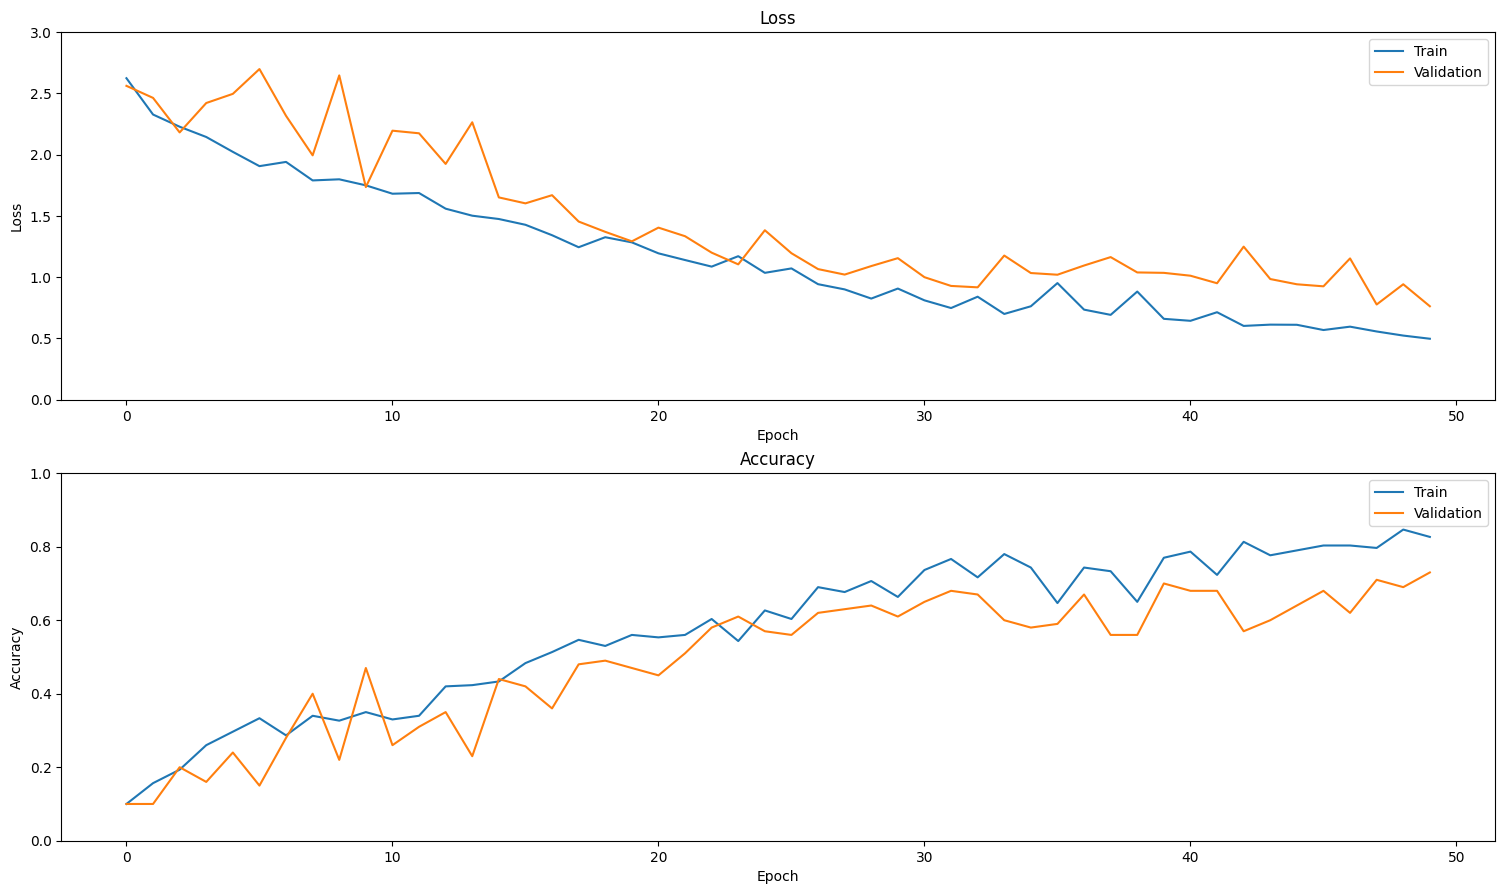

In [18]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## モデルを評価する

Keras `Model.evaluate` を使用して、テストデータセットで損失と精度を取得します。

注意: このチュートリアルのサンプルモデルは、合理的な時間でトレーニングできるように、UCF101 データセットのサブセットを使用しています。ハイパーパラメータのチューニングをさらに行ったり、トレーニングデータを増やすことで、精度と損失を改善できる可能性があります。 

In [19]:
model.evaluate(test_ds, return_dict=True)

      1/Unknown - 1s 1s/step - loss: 0.6765 - accuracy: 0.7500

      2/Unknown - 2s 778ms/step - loss: 0.5328 - accuracy: 0.8125

      3/Unknown - 3s 798ms/step - loss: 0.5907 - accuracy: 0.8333

      4/Unknown - 4s 800ms/step - loss: 0.4661 - accuracy: 0.8750

      5/Unknown - 5s 854ms/step - loss: 0.4147 - accuracy: 0.9000

      6/Unknown - 6s 893ms/step - loss: 0.4544 - accuracy: 0.8958

      7/Unknown - 7s 913ms/step - loss: 0.5637 - accuracy: 0.8393

      8/Unknown - 8s 908ms/step - loss: 0.5582 - accuracy: 0.8438

      9/Unknown - 9s 910ms/step - loss: 0.5607 - accuracy: 0.8333

     10/Unknown - 10s 931ms/step - loss: 0.6155 - accuracy: 0.7875

     11/Unknown - 11s 939ms/step - loss: 0.6489 - accuracy: 0.7841

     12/Unknown - 12s 937ms/step - loss: 0.6659 - accuracy: 0.7708

     13/Unknown - 12s 892ms/step - loss: 0.6833 - accuracy: 0.7700

13/13 [==============================] - 12s 893ms/step - loss: 0.6833 - accuracy: 0.7700


{'loss': 0.6833138465881348, 'accuracy': 0.7699999809265137}

モデルパフォーマンスをさらに可視化するには、[混同行列](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix)を使用します。混同行列では、精度を超えて分類モデルのパフォーマンスを評価することができます。このマルチクラス分類問題の混同行列を作成するために、テストセットの実際の値と予測される値を取得します。 

In [20]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [22]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

      1/Unknown - 2s 2s/step

      2/Unknown - 3s 1s/step

      3/Unknown - 4s 979ms/step

      4/Unknown - 5s 1s/step   

      5/Unknown - 6s 990ms/step

      6/Unknown - 7s 974ms/step

      7/Unknown - 8s 959ms/step

      8/Unknown - 9s 954ms/step

      9/Unknown - 10s 965ms/step

     10/Unknown - 11s 960ms/step

     11/Unknown - 11s 956ms/step

     12/Unknown - 12s 946ms/step

     13/Unknown - 13s 956ms/step

     14/Unknown - 14s 952ms/step

     15/Unknown - 15s 953ms/step

     16/Unknown - 16s 954ms/step

     17/Unknown - 17s 959ms/step

     18/Unknown - 18s 956ms/step

     19/Unknown - 19s 962ms/step

     20/Unknown - 20s 962ms/step

     21/Unknown - 21s 960ms/step

     22/Unknown - 22s 965ms/step

     23/Unknown - 23s 960ms/step

     24/Unknown - 24s 959ms/step

     25/Unknown - 25s 955ms/step

     26/Unknown - 26s 954ms/step

     27/Unknown - 27s 954ms/step

     28/Unknown - 28s 949ms/step

     29/Unknown - 29s 952ms/step

     30/Unknown - 29s 950ms/step

     31/Unknown - 30s 949ms/step

     32/Unknown - 31s 945ms/step

     33/Unknown - 32s 944ms/step

     34/Unknown - 33s 944ms/step

     35/Unknown - 34s 944ms/step

     36/Unknown - 35s 946ms/step

     37/Unknown - 36s 945ms/step

     38/Unknown - 37s 934ms/step

38/38 [==============================] - 37s 936ms/step


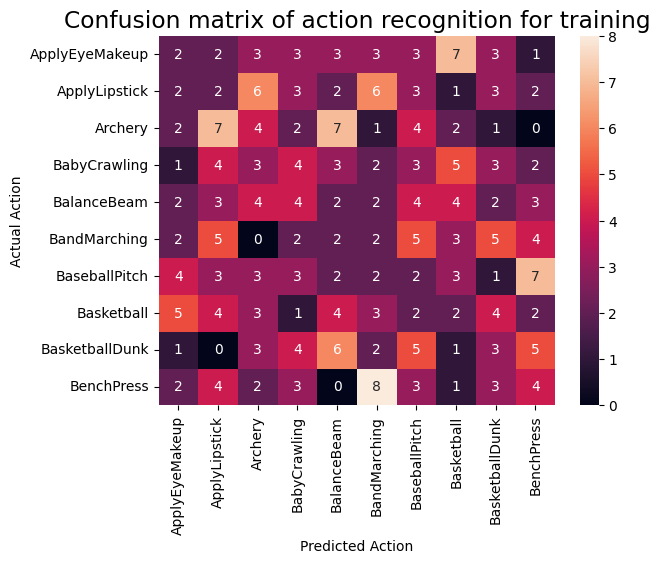

In [23]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

      1/Unknown - 1s 1s/step

      2/Unknown - 2s 768ms/step

      3/Unknown - 3s 773ms/step

      4/Unknown - 4s 790ms/step

      5/Unknown - 5s 847ms/step

      6/Unknown - 6s 897ms/step

      7/Unknown - 7s 911ms/step

      8/Unknown - 8s 906ms/step

      9/Unknown - 9s 908ms/step

     10/Unknown - 10s 927ms/step

     11/Unknown - 11s 938ms/step

     12/Unknown - 12s 934ms/step

     13/Unknown - 12s 890ms/step

13/13 [==============================] - 12s 891ms/step


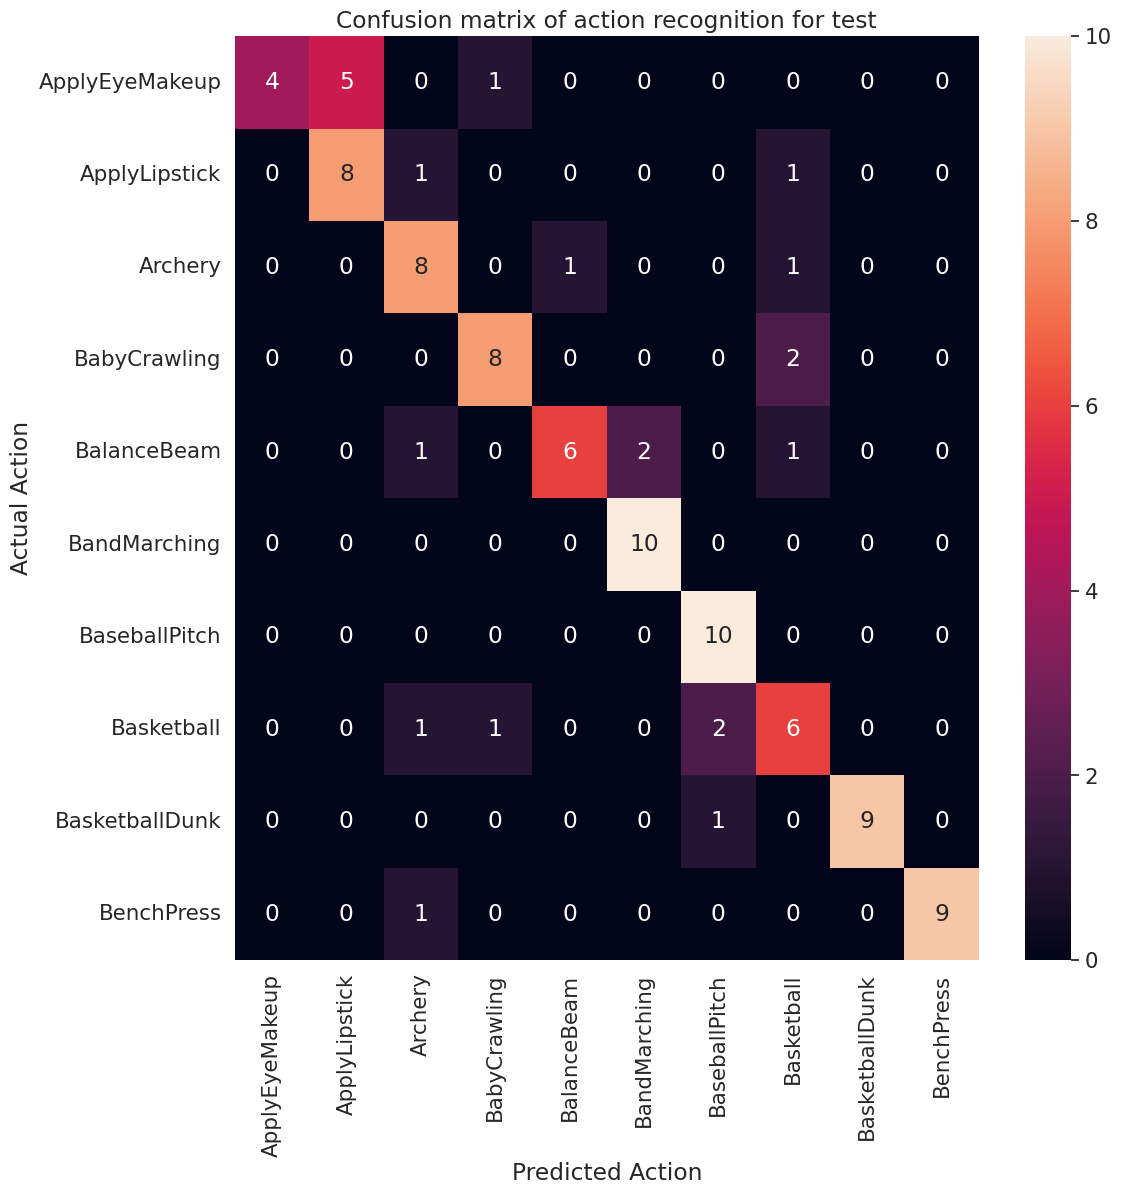

In [24]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

各クラスの適合率と再現率の値は、混同行列を使用して計算することもできます。

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [27]:
precision

{'ApplyEyeMakeup': 1.0,
 'ApplyLipstick': 0.6153846153846154,
 'Archery': 0.6666666666666666,
 'BabyCrawling': 0.8,
 'BalanceBeam': 0.8571428571428571,
 'BandMarching': 0.8333333333333334,
 'BaseballPitch': 0.7692307692307693,
 'Basketball': 0.5454545454545454,
 'BasketballDunk': 1.0,
 'BenchPress': 1.0}

In [28]:
recall

{'ApplyEyeMakeup': 0.4,
 'ApplyLipstick': 0.8,
 'Archery': 0.8,
 'BabyCrawling': 0.8,
 'BalanceBeam': 0.6,
 'BandMarching': 1.0,
 'BaseballPitch': 1.0,
 'Basketball': 0.6,
 'BasketballDunk': 0.9,
 'BenchPress': 0.9}

## 次のステップ

TensorFlow での動画の操作についての詳細は、以下のチュートリアルをご覧ください。

- 動画データを読み込む
- [MoviNet でストリーミングの行動認識を実行する](https://www.tensorflow.org/hub/tutorials/movinet)
- MoviNet を使った動画分類の転移学習